# 零、导入与忽略警告

In [22]:
# =================== 基础工具 ===================
import os
import math
from math import log
import numpy as np
import pandas as pd
from tabulate import tabulate
import textwrap

# =================== 可视化 ===================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import missingno as msno

# =================== 科学计算 (scipy) ===================
from scipy import stats
from scipy.stats import (
    chi2_contingency, f_oneway,
    pointbiserialr, pearsonr,
    mannwhitneyu, brunnermunzel,
    zscore, iqr, skew, kurtosis,
    shapiro
)
from scipy.stats import chi2 as chi2_dist  # chi2 分布对象
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

# =================== 机器学习 (scikit-learn) ===================
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, roc_auc_score
)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import (
    mutual_info_regression, mutual_info_classif,
    f_classif, chi2 as chi2_fs
)
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ========== 缺失值处理 ==========
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer

# =================== 统计建模 (statsmodels) ===================
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.imputation import mice
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =================== 其他统计工具 ===================
import pingouin as pg


In [4]:
import warnings
warnings.filterwarnings('ignore')

# 一、问题定义

## 1.1 Business/Research Need and Research Question
Diabetes is a global chronic disease, and its early identification is critical to reducing complications and alleviating the burden on healthcare systems. The central research need is:

- **To build a predictive model that determines whether an individual has diabetes based on demographic, lifestyle, psychosocial, and medical risk factors.**

The research question can be articulated as:  
*Given a set of features including demographic variables (e.g., age, sex, education, income), lifestyle behaviors (e.g., smoking, alcohol use, physical activity, diet), psychosocial health indicators (e.g., mental and physical unhealthy days), medical history (e.g., stroke, heart disease, hypertension, cholesterol), and healthcare access, can we accurately predict whether an individual is diagnosed with diabetes?*

## 1.2 Task Type
- **Type of task**: Classification (supervised learning)  
- **Target variable**: `Diabetes` 
- The goal is to classify individuals into diabetic or non-diabetic categories based on the input features.

## 1.3 Stakeholders
1. **Public Health Agencies**: Use the model to identify high-risk groups, guide resource allocation, and design preventive strategies.  
2. **Clinicians**: Support risk assessment and provide early intervention for undiagnosed but high-risk individuals.  
3. **Healthcare Insurers**: Optimize resource distribution and cost management through risk stratification.  
4. **Patients and the General Public**: Improve awareness of risk factors, encourage healthier lifestyle changes, and promote self-management.  
5. **Researchers**: Explore the multidimensional determinants of diabetes and contribute to precision medicine studies.

## 1.4 Value and Benefits
- **Early Detection and Prevention**: Enable identification of undiagnosed individuals at high risk of diabetes for timely intervention.  
- **Reduced Healthcare Burden**: Minimize long-term complications (e.g., cardiovascular disease, stroke) and associated costs through prevention.  
- **Decision Support for Health Management**: Provide evidence for healthcare providers and policymakers to design targeted health education and intervention programs.  
- **Equity in Healthcare**: Address disparities by incorporating socioeconomic variables (education, income), highlighting gaps in access to care.  
- **Scientific Contribution**: Advance research in chronic disease prediction with multidimensional health data modeling.

# 二、数据描述

## 2.1 读取数据 
为了通过程序进行数据描述，我们进行了最基础的数据处理：
- 清理第一列ID列
- 转换 Income 列数据类型

In [114]:
# 1. 读取数据集
df = pd.read_csv('diabetes_diagnosis.csv')
print(f"初始数据形状: {df.shape}")

# 2. 清理 Unnamed: 0 列
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
    print("'Unnamed: 0' 列已删除")

# 3. 清理 Income 列
if 'Income' in df.columns:
    df['Income'] = df['Income'].replace('[\$,]', '', regex=True).replace('', np.nan)
    df['Income'] = pd.to_numeric(df['Income'], errors='coerce')
    print(f"'Income' 列已转换为数值型")

初始数据形状: (264802, 23)
'Unnamed: 0' 列已删除
'Income' 列已转换为数值型


## 2.2 数据维度

In [115]:
num_samples, num_columns = df.shape
num_features = num_columns - 1  # 去掉标签列
print(f"数据集维度: {df.shape}, 样本数: {num_samples} 例, 特征数: {num_features} 个")     

数据集维度: (264802, 22), 样本数: 264802 例, 特征数: 21 个


## 2.3 特征类型

唯一值少于20个或 object 类型的数据判定为 categorical_features ，其余为 numeric_features 

这里定义了一个自动区分特征类型工具 ``identify_feature_types(df, verbose=False)``

In [116]:
def identify_feature_types(df, verbose=False, unique_threshold=20):
    """
    区分特征类型：数值型(numeric)与类别型(categorical)

    参数:
    ----
    df : pd.DataFrame
        输入的数据集
    verbose : bool, default=False
        是否打印特征类型表格
    unique_threshold : int, default=20
        唯一值少于该阈值判定为类别型

    返回:
    ----
    numeric_features : list
        数值型特征列表
    categorical_features : list
        类别型特征列表
    """
    feature_types = {}
    numeric_features = []
    categorical_features = []

    for col in df.columns:
        nunique = df[col].nunique(dropna=False)
        if df[col].dtype == 'object' or nunique < unique_threshold:
            feature_types[col] = 'categorical'
            categorical_features.append(col)
        else:
            feature_types[col] = 'numeric'
            numeric_features.append(col)

    if verbose:
        feature_type_df = pd.DataFrame({
            'Feature': list(feature_types.keys()),
            'Type': list(feature_types.values())
        })
        print(tabulate(feature_type_df, headers='keys', tablefmt='grid', showindex=False, stralign='center', numalign='center'))

    return numeric_features, categorical_features

In [117]:
umeric_features, categorical_features = identify_feature_types(df, verbose=True)

+----------------------+-------------+
|       Feature        |    Type     |
+======================+=============+
|      CholCheck       | categorical |
+----------------------+-------------+
|         BMI          |   numeric   |
+----------------------+-------------+
|        Smoker        | categorical |
+----------------------+-------------+
|        Stroke        | categorical |
+----------------------+-------------+
| HeartDiseaseorAttack | categorical |
+----------------------+-------------+
|     PhysActivity     | categorical |
+----------------------+-------------+
|        Fruits        | categorical |
+----------------------+-------------+
|       Veggies        | categorical |
+----------------------+-------------+
|    AnyHealthcare     | categorical |
+----------------------+-------------+
|     NoDocbcCost      | categorical |
+----------------------+-------------+
|    GeneralHealth     | categorical |
+----------------------+-------------+
|    Mental (days)     | 

## 2.4 缺失值

这里我们定义了一个缺失情况可视化工具 ``plot_missing_statistics(df: pd.DataFrame, title: str = 'Missing Value Statistics')``

In [118]:
def plot_missing_statistics(df: pd.DataFrame, title: str = 'Missing Value Statistics'):
    """
    可视化特征缺失值情况（数量+比例），并在图右下角标注总体缺失情况。

    参数:
    ----
    df : pd.DataFrame
        输入的数据集
    title : str, default='Missing Value Statistics'
        图表标题
    """

    # 1. 总体缺失值数量和比例
    total_missing = df.isnull().sum().sum()
    total_rate = total_missing / (df.shape[0] * df.shape[1])

    # 2. 每个特征缺失数量和比例
    missing_count = df.isnull().sum()
    missing_rate = missing_count / len(df)

    missing_df = pd.DataFrame({
        'missing_count': missing_count,
        'missing_rate': missing_rate
    }).sort_values('missing_rate', ascending=False)

    # 3. 平均缺失率
    mean_missing_rate = missing_rate.mean()

    # 4. 颜色映射
    norm = plt.Normalize(missing_df['missing_count'].min(), missing_df['missing_count'].max())
    colors = plt.cm.Blues(norm(missing_df['missing_count']))

    # 5. 绘制
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 柱状图：缺失数量
    ax1.bar(
        missing_df.index,
        missing_df['missing_count'],
        color=colors
    )
    ax1.set_ylabel('Missing Count', fontsize=12)
    ax1.set_xlabel('Feature', fontsize=12)
    ax1.set_xticklabels(missing_df.index, rotation=45, ha='right')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # 折线图：缺失比例
    ax2 = ax1.twinx()
    ax2.plot(
        missing_df.index,
        missing_df['missing_rate'],
        color='red',
        marker='o',
        label='Missing Rate'
    )
    ax2.set_ylabel('Missing Rate', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

    # 平均缺失率虚线
    ax2.axhline(mean_missing_rate, linestyle='--', color='orange', label='Mean Missing Rate')

    # 图例
    ax2.legend(loc='upper right')

    # 在右下角加总体缺失信息
    plt.text(
        0.99, 0.01,
        f"Total Missing: {total_missing} ({total_rate:.2%})",
        transform=fig.transFigure,
        fontsize=12,
        ha='right', va='bottom',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

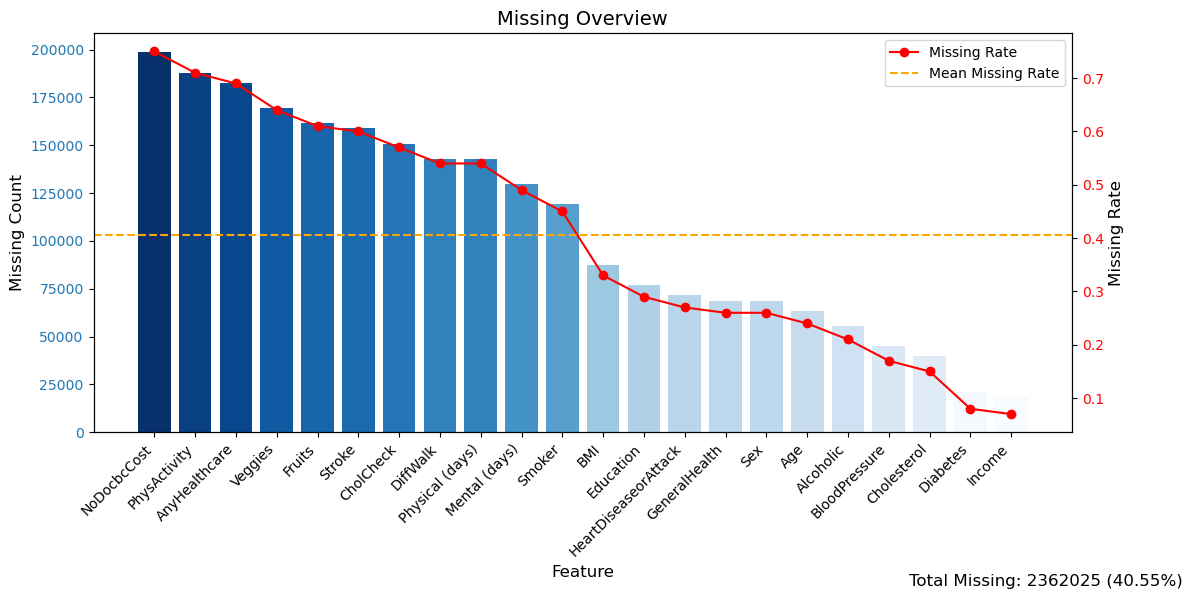

In [11]:
plot_missing_statistics(df, title='Missing Overview')

## 2.5 分布可视化

这里我们定义了 分布可视化工具 ``plot_distributions(df: pd.DataFrame, unique_threshold: int = 20,numeric_title: str = "Numeric Feature Distributions",categorical_title: str = "Categorical Feature Distributions",n_cols: int = 4, wrap_width: int = 50)`` ，调用:
- 连续型特征分布可视化工具 ``plot_numeric_distributions(df: pd.DataFrame, numeric_features: list, title: str = "Numeric Feature Distributions")``
- 离散型特征分布可视化工具 ``plot_categorical_distributions(df: pd.DataFrame, categorical_features: list, n_cols: int = 4, title: str = "Categorical Feature Distributions", wrap_width: int = 50)``

In [59]:
def plot_numeric_distributions(df: pd.DataFrame, numeric_features: list, title: str = "Numeric Feature Distributions"):
    """
    绘制数值型特征的小提琴图，并添加合理的辅助线。
    会自动跳过 DataFrame 中不存在的列，避免 KeyError

    参数:
    ----
    df : pd.DataFrame
        输入数据集
    numeric_features : list
        数值型特征列名
    title : str, default="Numeric Feature Distributions"
        图表标题
    """
    existing_cols = [col for col in numeric_features if col in df.columns]
    missing_cols = [col for col in numeric_features if col not in df.columns]

    if missing_cols:
        print(f"警告：以下数值列在 DataFrame 中不存在，将被跳过：{missing_cols}")

    if not existing_cols:
        print("没有有效的数值特征可绘制。")
        return

    X_num = df[existing_cols]

    plt.figure(figsize=(len(existing_cols) * 3, 6))
    for i, col in enumerate(existing_cols):
        plt.subplot(1, len(existing_cols), i + 1)
        sns.violinplot(y=X_num[col], inner="box", color="skyblue")
        plt.title(col, fontsize=10)
        plt.xlabel("Density")
        plt.ylabel("")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_categorical_distributions(df: pd.DataFrame, categorical_features: list, n_cols: int = 4, title: str = "Categorical Feature Distributions", wrap_width: int = 50):
    """
    绘制分类特征的分布图（含缺失值标记为 Unknown），自动处理标题过长换行。
    会自动跳过 DataFrame 中不存在的列，避免 KeyError
    """
    def wrap_label(label, width=wrap_width):
        return "\n".join(textwrap.wrap(label, width=width))

    existing_cols = [col for col in categorical_features if col in df.columns]
    missing_cols = [col for col in categorical_features if col not in df.columns]

    if missing_cols:
        print(f"⚠️ 警告：以下分类列在 DataFrame 中不存在，将被跳过：{missing_cols}")

    if not existing_cols:
        print("❌ 没有有效的分类特征可绘制。")
        return

    X_plot = df[existing_cols].fillna("Unknown")
    plt.rcParams.update({'font.size': 10})

    n_rows = len(existing_cols) // n_cols + (1 if len(existing_cols) % n_cols > 0 else 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(existing_cols):
        value_counts = X_plot[col].value_counts(dropna=False)
        value_props = value_counts / value_counts.sum()

        norm = plt.Normalize(value_counts.min(), value_counts.max())
        bar_colors = cm.Blues(norm(value_counts.values))

        color_list = ["lightgray" if cat == "Unknown" else bar_colors[idx] 
                      for idx, cat in enumerate(value_counts.index)]

        bars = axes[i].bar(value_counts.index.astype(str), value_counts.values, color=color_list)
        axes[i].set_title(wrap_label(f'{col} Distribution'), fontsize=10) 
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        for label in axes[i].get_xticklabels():
            label.set_horizontalalignment('right')

        for bar, prop in zip(bars, value_props):
            axes[i].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f'{prop:.2%}',
                ha='center',
                va='bottom'
            )

    # 隐藏多余子图
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.99])  # 给 suptitle 留出顶部空间
    plt.show()

In [60]:
def plot_distributions(df: pd.DataFrame, unique_threshold: int = 20,numeric_title: str = "Numeric Feature Distributions",categorical_title: str = "Categorical Feature Distributions",n_cols: int = 4, wrap_width: int = 50):
    """
    分布可视化总函数：区分特征类型并绘制分布图

    参数:
    ----
    df : pd.DataFrame
        输入数据集
    unique_threshold : int, default=20
        唯一值少于该阈值判定为类别型
    numeric_title : str, default="Numeric Feature Distributions"
        数值特征图表标题
    categorical_title : str, default="Categorical Feature Distributions"
        分类特征图表标题
    verbose : bool, default=False
        是否打印特征类型表格
    n_cols : int, default=4
        分类特征子图每行数量
    """
    print("=== 数据集基本信息 ===")
    print(f"样本数: {df.shape[0]}, 特征数: {df.shape[1]}")
    
    # 区分特征类型
    numeric_features, categorical_features = identify_feature_types(df, unique_threshold=unique_threshold)

    # 绘制数值型特征分布
    if numeric_features:
        print("\n=== 连续特征分布（小提琴图） ===")
        plot_numeric_distributions(df, numeric_features, title=numeric_title)
    else:
        print("没有数值型特征可绘制。")
    
    # 绘制分类特征分布
    if categorical_features:
        print("\n=== 分类特征分布（柱状图） ===")
        plot_categorical_distributions(df, categorical_features, n_cols=n_cols, title=categorical_title, wrap_width=wrap_width)
    else:
        print("没有分类特征可绘制。")

=== 数据集基本信息 ===
样本数: 264802, 特征数: 22

=== 连续特征分布（小提琴图） ===


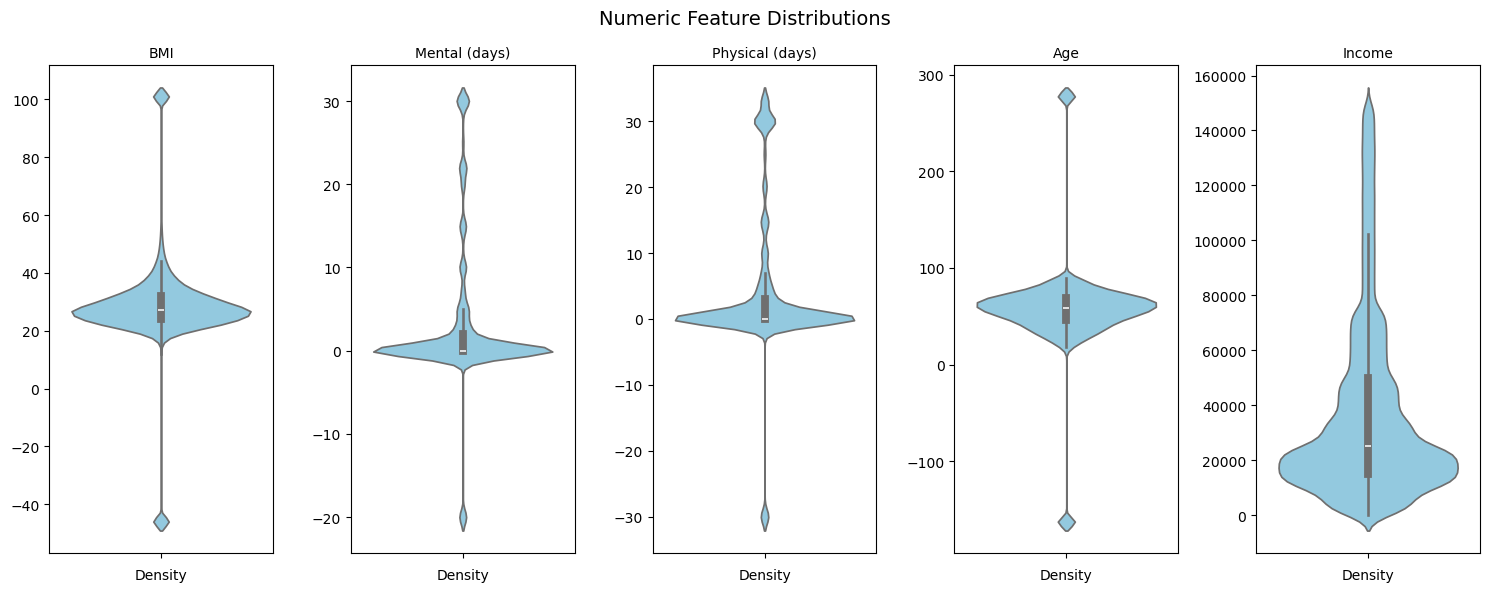


=== 分类特征分布（柱状图） ===


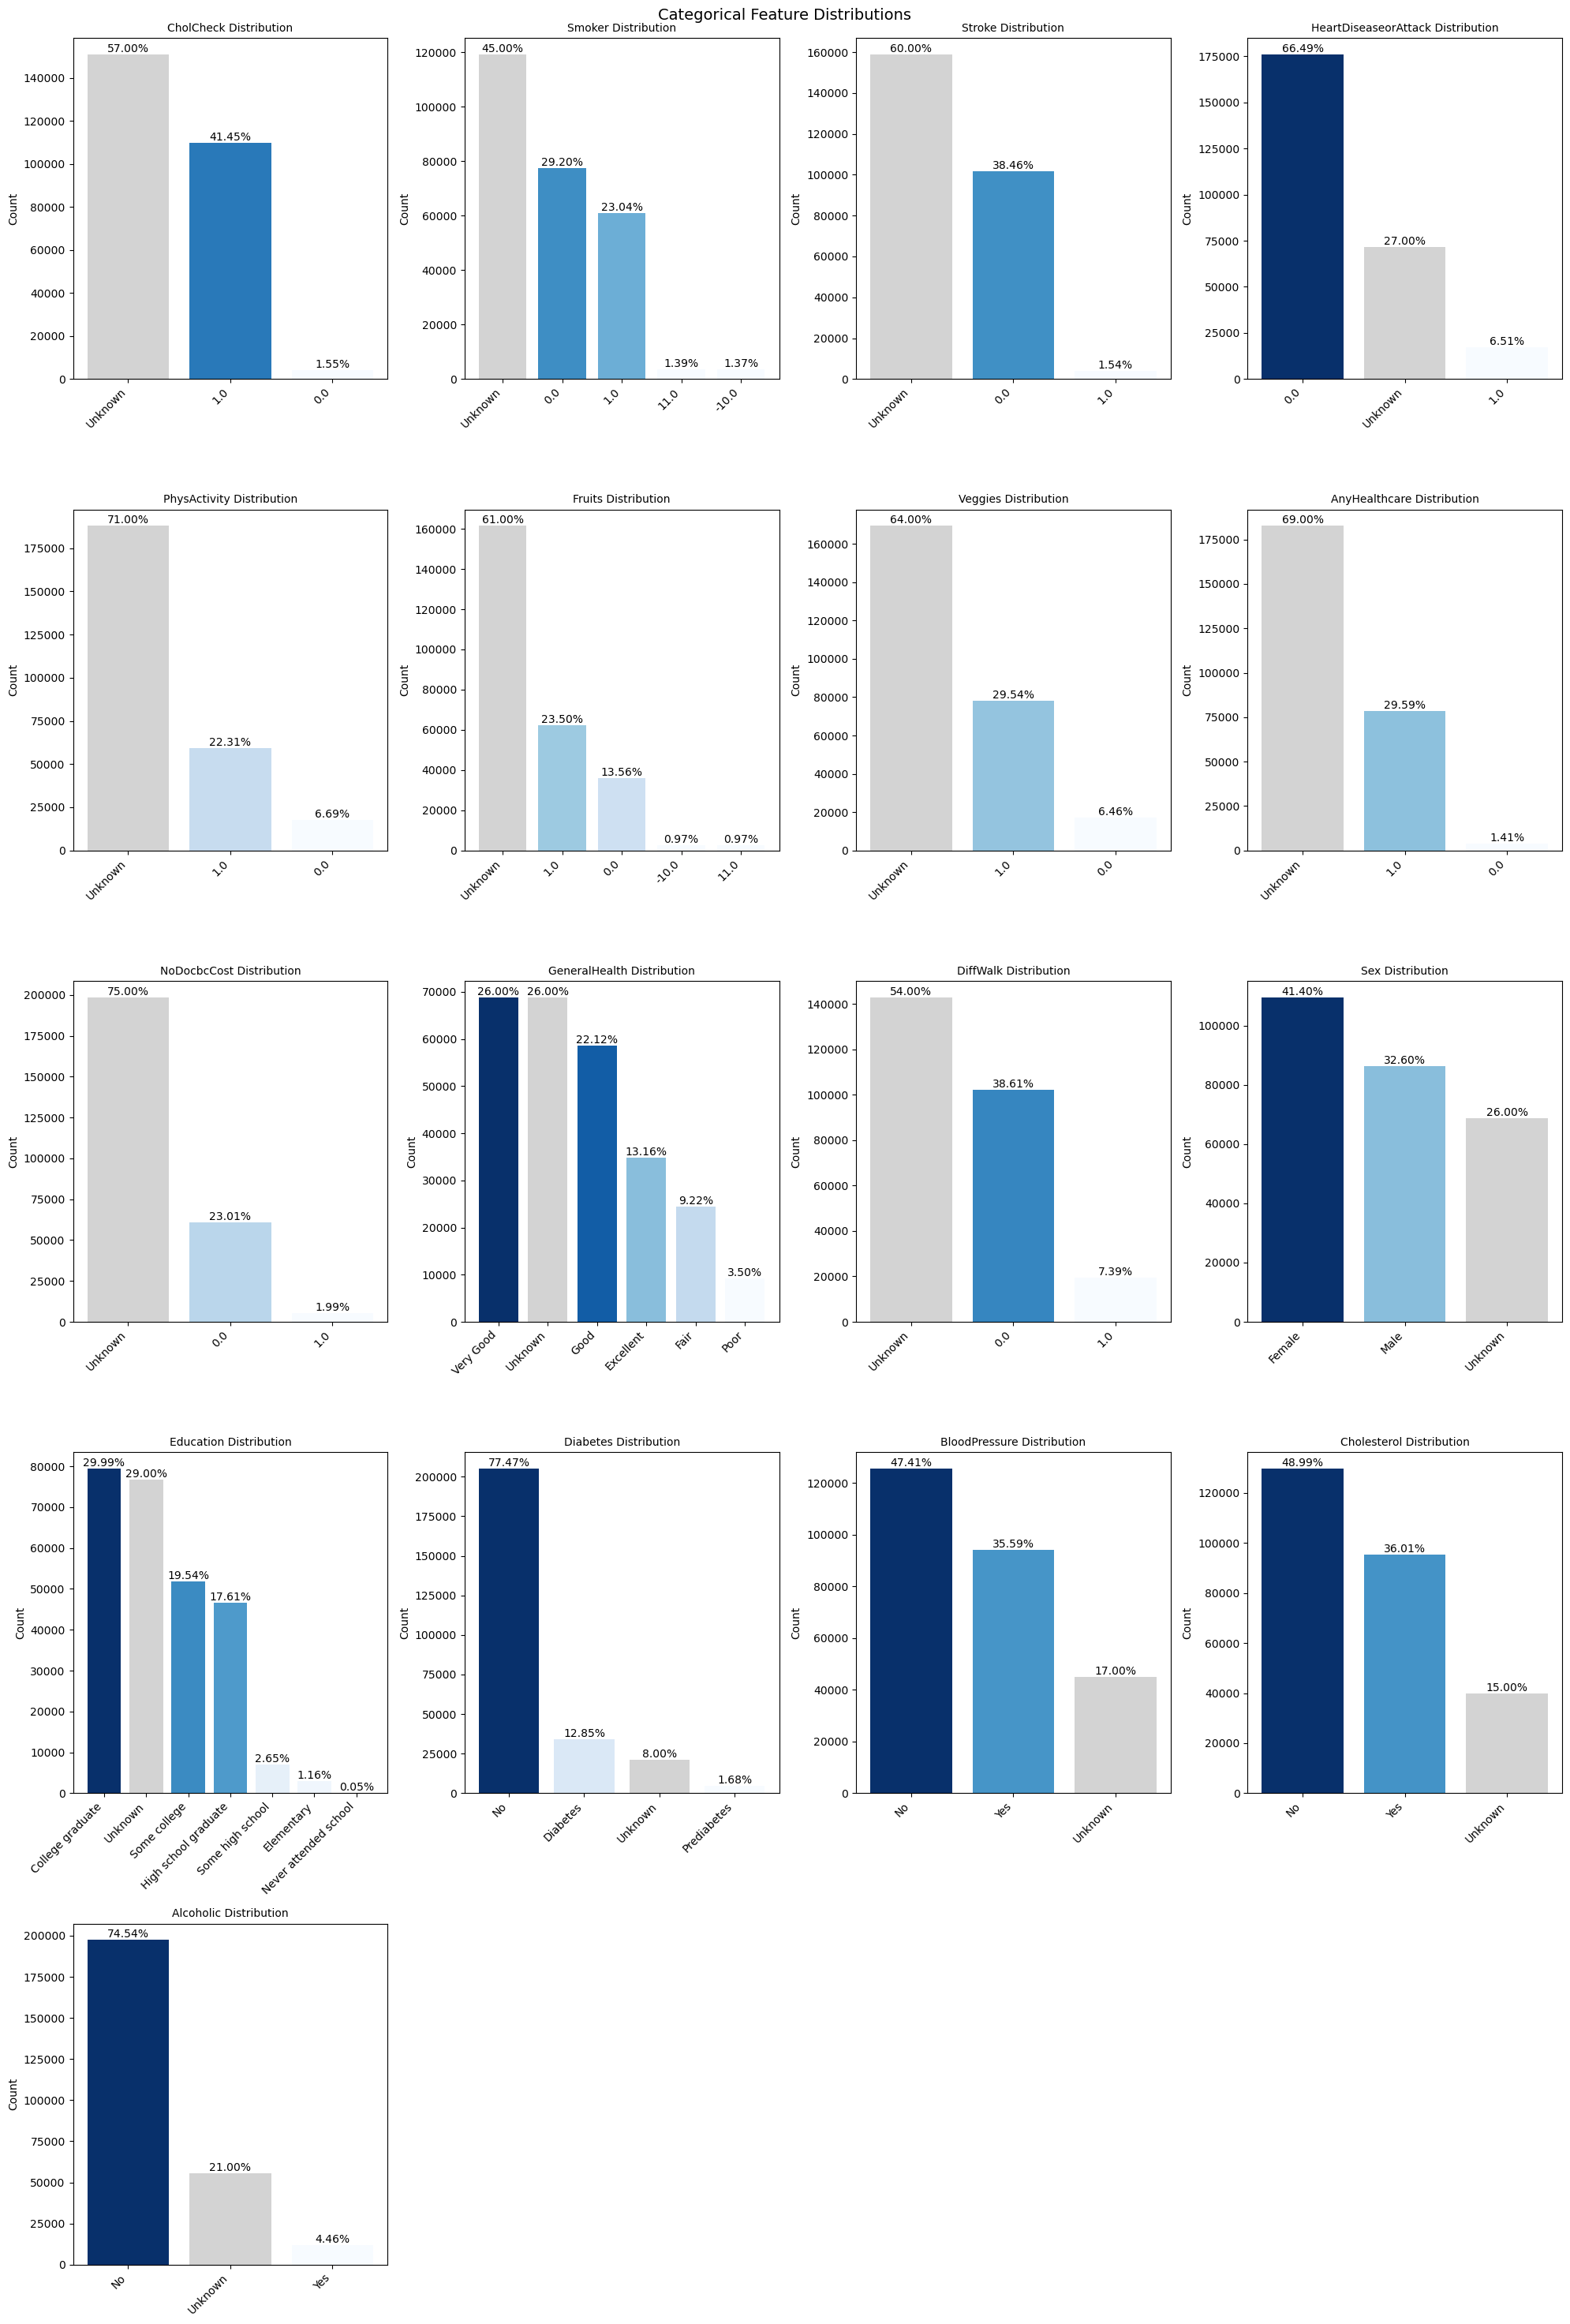

In [61]:
plot_distributions(df)

# 三、数据清洗与处理

分为以下三个部份：
1. **数据清洗** → 保证样本有效性。  
2. **再异常值** → 避免极端值干扰统计与插补。  
3. **再冗余特征** → 优化特征结构，避免冗余噪声。  
4. **最后缺失值** → 在干净、稳定的特征空间中进行插补，确保结果更可靠。  

## 3.1 数据清洗

1. 删除无意义列
    - **操作**：若存在 `Unnamed: 0` 列（通常是索引残留），则删除。  

2. Income 清理
    - **操作**：去除 `$`、`,` 等符号，将空字符串替换为缺失值，并转换为数值型。  

3. 删除 Diabetes 缺失行
    - **操作**：若 `Diabetes`（标签列）为空，则删除该行。  

4. GeneralHealth 映射
    - **映射规则**：  
    - Excellent → 5  
    - Very Good → 4  
    - Good → 3  
    - Fair → 2  
    - Poor → 1  

5. Sex 映射
    - **映射规则**：  
    - Male → 1  
    - Female → 0  
 
6. Education 映射
    - **映射规则**：  
    - Never attended school → 0  
    - Elementary → 1  
    - Some high school → 2  
    - High school graduate → 3  
    - Some college → 4  
    - College graduate → 5  

7. 二分类变量映射
    - **适用列**：`BloodPressure`、`Cholesterol`、`Alcoholic`  
    - **映射规则**：  
    - Yes → 1  
    - No → 0  
  
8. Diabetes 标签映射
    - **映射规则**：  
    - No → 0  
    - Diabetes → 1  
    - Prediabetes → 2  

这里定义了
- 数据清洗工具 ``clean_data(df: pd.DataFrame, verbose: bool = True)``
- 特征 & 标签分离工具 ``split_features_labels(df, label_col='Diabetes', verbose=False)``

In [63]:
def clean_data(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    数据清洗函数：对 diabetes_diagnosis 数据集进行基础清理，保证格式一致与可解析。

    步骤：
    - 删除无意义列
    - Income 转换为数值型
    - 删除 Diabetes 缺失行
    - GeneralHealth, Sex, Education 等字段映射
    - 二分类变量映射
    - Diabetes 标签映射

    参数
    ----
    df : pd.DataFrame
        原始数据集
    verbose : bool, default=True
        是否打印检查日志

    返回
    ----
    df : pd.DataFrame
        清理后的数据集
    """

    # 删除可能存在的无意义索引列
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    # Income 清理（去符号、转数值）
    if 'Income' in df.columns and not pd.api.types.is_numeric_dtype(df['Income']):
        df['Income'] = (
            df['Income']
            .replace('[\$,]', '', regex=True)
            .replace('', np.nan)
        )
        df['Income'] = pd.to_numeric(df['Income'], errors='coerce')

    # 去掉 Diabetes 缺失的行（作为标签列）
    if 'Diabetes' in df.columns:
        df = df.dropna(subset=['Diabetes'])

    # GeneralHealth 映射
    health_map = {"Excellent": 5, "Very Good": 4, "Good": 3, "Fair": 2, "Poor": 1}
    if 'GeneralHealth' in df.columns and not pd.api.types.is_numeric_dtype(df['GeneralHealth']):
        original_vals = set(df["GeneralHealth"].dropna().unique())
        df["GeneralHealth"] = df["GeneralHealth"].map(health_map)
        unmapped = original_vals - set(health_map.keys())
        if unmapped:
            print(f"警告: GeneralHealth 存在未映射值: {unmapped}")
        elif verbose:
            print("GeneralHealth 映射完成，无异常。")

    # Sex 映射
    sex_map = {"Male": 1, "Female": 0}
    if 'Sex' in df.columns and not pd.api.types.is_numeric_dtype(df['Sex']):
        original_vals = set(df["Sex"].dropna().unique())
        df["Sex"] = df["Sex"].map(sex_map)
        unmapped = original_vals - set(sex_map.keys())
        if unmapped:
            print(f"警告: Sex 存在未映射值: {unmapped}")
        elif verbose:
            print("Sex 映射完成，无异常。")

    # Education 映射
    edu_map = {
        "Never attended school": 0,
        "Elementary": 1,
        "Some high school": 2,
        "High school graduate": 3,
        "Some college": 4,
        "College graduate": 5
    }
    if 'Education' in df.columns and not pd.api.types.is_numeric_dtype(df['Education']):
        original_vals = set(df["Education"].dropna().unique())
        df["Education"] = df["Education"].map(edu_map)
        unmapped = original_vals - set(edu_map.keys())
        if unmapped:
            print(f"警告: Education 存在未映射值: {unmapped}")
        elif verbose:
            print("Education 映射完成，无异常。")

    # 二分类变量映射
    binary_map = {"No": 0, "Yes": 1}
    for col in ['BloodPressure', 'Cholesterol', 'Alcoholic']:
        if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
            original_vals = set(df[col].dropna().unique())
            df[col] = df[col].map(binary_map)
            unmapped = original_vals - set(binary_map.keys())
            if unmapped:
                print(f"警告: {col} 存在未映射值: {unmapped}")
            elif verbose:
                print(f"{col} 映射完成，无异常。")

    # Diabetes 映射（标签）
    y_map = {'No': 0, 'Diabetes': 1, 'Prediabetes': 2}
    if 'Diabetes' in df.columns and not pd.api.types.is_numeric_dtype(df['Diabetes']):
        original_vals = set(df["Diabetes"].dropna().unique())
        df['Diabetes'] = df['Diabetes'].map(y_map)
        unmapped = original_vals - set(y_map.keys())
        if unmapped:
            print(f"警告: Diabetes 存在未映射值: {unmapped}")
        elif verbose:
            print("Diabetes 标签映射完成，无异常。")

    return df

In [71]:
def split_features_labels(df, label_col='Diabetes', verbose=False):
    """
    将标签列与特征列分离，并对标签进行数值映射。

    参数:
    ----
    df : pd.DataFrame
        原始数据集
    label_col : str, default='Diabetes'
        标签列名
    verbose : bool, default=False
        是否输出标签统计信息

    返回:
    ----
    X : pd.DataFrame
        特征数据
    y : pd.Series
        标签数据（数值型）
    mapping_rule : dict
        类别到数值的映射规则
    """
    # 特征列
    X = df.drop(columns=[label_col])
    y = df[label_col].copy()

    # 映射规则
    mapping_rule = {'No': 0, 'Diabetes': 1, 'Prediabetes': 2}

    # 判断 y 是否已部分映射为数值
    if y.dtype == 'O' or y.isin(mapping_rule.keys()).any():
        # 只映射未处理的部分
        y = y.map(lambda v: mapping_rule[v] if v in mapping_rule else v)

    # 检查是否仍有异常值
    unique_vals = y.unique()
    expected_vals = set(mapping_rule.values())
    unexpected_vals = [v for v in unique_vals if v not in expected_vals]

    if verbose:
        counts = y.value_counts(dropna=False)
        ratios = y.value_counts(normalize=True, dropna=False)
        result = pd.DataFrame({
            'Value': counts.index.astype('Int64'),
            'Class': counts.index.map({v:k for k,v in mapping_rule.items()}).fillna("Unknown"),
            'Count': counts.values,
            'Proportion': (ratios.loc[counts.index]*100).round(2).astype(str) + '%'
        })
        print(tabulate(result[['Value','Class','Count','Proportion']], headers='keys', tablefmt='grid', showindex=False, stralign='center', numalign='center'))

    # 报告异常值
    if len(unexpected_vals) > 0:
        print(f"警告: 标签列存在未映射或异常值: {unexpected_vals}")
    else:
        if verbose:
            print("标签列检查完成，没有发现异常值。")

    return X, y

In [102]:
df = pd.read_csv('diabetes_diagnosis.csv')
df = clean_data(df, verbose=True)
# plot_distributions(df)
X, y = split_features_labels(df, label_col='Diabetes', verbose=True)

GeneralHealth 映射完成，无异常。
Sex 映射完成，无异常。
Education 映射完成，无异常。
BloodPressure 映射完成，无异常。
Cholesterol 映射完成，无异常。
Alcoholic 映射完成，无异常。
Diabetes 标签映射完成，无异常。
+---------+-------------+---------+--------------+
|  Value  |    Class    |  Count  |  Proportion  |
+=========+=============+=========+==============+
|    0    |     No      | 205133  |    84.2%     |
+---------+-------------+---------+--------------+
|    1    |  Diabetes   |  34026  |    13.97%    |
+---------+-------------+---------+--------------+
|    2    | Prediabetes |  4459   |    1.83%     |
+---------+-------------+---------+--------------+
标签列检查完成，没有发现异常值。


## 3.2 冗余特征处理

在数据集中，特征之间可能存在 **冗余（redundancy）** 或 **重复信息（duplication）**，可能导致：
- **模型估计不稳定**：多重共线性导致系数方差膨胀，回归结果不可靠。
- **信息冗余**：不同特征携带的是相同信息，增加维度却未提升模型解释力。
- **过拟合风险**：噪声在冗余特征间被反复放大，模型泛化能力下降。
- **计算负担加重**：无效特征增加模型复杂度，降低效率。

不同类型的特征之间，冗余的表现形式与检测方法并不相同，我们将冗余关系划分为连续–连续、离散–离散、连续–离散以及多特征共同作用四个部分





其次，离散–离散特征之间的冗余主要体现在类别分布的重合与依赖性。例如“是否吸烟”与“是否饮酒”可能存在较强的联合分布关系。此类冗余通常使用 Cramér’s V、卡方独立性检验或互信息等方法来刻画。如果两者之间强依赖，那么在建模过程中重复保留会降低特征集的独立性和解释性。

第三，连续–离散特征之间的冗余则需要考虑不同尺度下的依赖关系。例如教育水平（离散）与收入（连续）之间往往存在阶梯式的单调关系。在这种情况下，可以通过 ANOVA 方差分析、η² 效应量或基于树模型的分裂增益来刻画相关性。这类冗余的本质在于一个离散分组变量几乎能解释大部分连续变量的变异，因此保留两者往往没有必要。

最后，多特征共同作用的冗余属于更复杂的情况。在真实数据集中，一个目标变量往往并非由单一特征决定，而是由多个特征的线性或非线性组合共同解释。例如，年龄、体重和血压三者联合可能高度预测健康风险。此类冗余无法仅凭两两相关性检测，而需要多元回归、主成分分析（PCA）或基于特征重要性的模型方法（如随机森林、Lasso 回归）来识别。该部分的意义在于提醒我们单一 pairwise 检测不足以揭示全局冗余结构，必须考虑特征之间的协同作用。

综上所述，将冗余检测分为连续–连续、离散–离散、连续–离散与多特征共同作用四个部分，不仅有助于从统计特性上分类讨论问题，还能够为后续特征筛选提供明确的技术路径，使模型既能保持解释性，又能避免信息冗余带来的性能下降。

In [103]:
numeric_features, categorical_features = identify_feature_types(X)

### 3.2.1 连续型 - 连续型

- **潜在问题**：两个连续变量高度线性或单调相关，本质上提供重复信息。
- **检测方法**：
  - **Pearson 相关系数**：检测线性相关性（适用于正态分布变量）。
  - **Spearman 秩相关系数**：检测单调相关性（对异常值和非线性更鲁棒）。
- **判别依据**：若相关系数接近 ±1，说明变量间信息高度重合，其中一个可被视为冗余。

定义了工具 ``plot_numeric_correlations(X: pd.DataFrame, numeric_features: list = None, per_feature_size=0.5)``

In [83]:
def plot_numeric_correlations(
    X: pd.DataFrame, 
    numeric_features: list = None, 
    per_feature_size=0.5, 
    suptitle: str = "Numeric Feature Correlations"
):
    """
    绘制数值型特征的 Pearson 与 Spearman 相关性热力图，图像大小自适应特征数量。

    参数:
    ----
    X : pd.DataFrame
        输入数据集
    numeric_features : list, optional
        需要计算相关性的数值型特征列表。如果为 None 或空列表，则自动选择所有数值型特征
    per_feature_size : float, default=0.5
        每个特征额外分配的图像尺寸，用于动态调整
    suptitle : str, default="Numeric Feature Correlations"
        统一图表标题
    """
    # 如果 numeric_features 没有提供，则使用所有数值型特征
    if not numeric_features:
        numeric_features = X.select_dtypes(include='number').columns.tolist()
        if not numeric_features:
            raise ValueError("数据集中没有数值型特征可以计算相关性。")

    n_features = len(numeric_features)

    # 每张子图占用的尺寸
    width_per_subplot = max(6, n_features * per_feature_size)
    height = max(5, n_features * per_feature_size)

    # 总宽度 = 两张子图宽度 + 子图间距
    total_width = width_per_subplot * 2 + 2  # 2 英寸间隔

    # 计算相关系数矩阵
    pearson_corr = X[numeric_features].corr(method="pearson")
    spearman_corr = X[numeric_features].corr(method="spearman")

    # 绘制子图
    fig, axes = plt.subplots(1, 2, figsize=(total_width, height))

    sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[0])
    axes[0].set_title("Pearson Correlation", fontsize=10)  # 子图标题 10

    sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[1])
    axes[1].set_title("Spearman Correlation", fontsize=10)  # 子图标题 10

    # 添加统一标题
    fig.suptitle(suptitle, fontsize=14)  # 大标题 14

    plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.88)  # 给标题留空间
    plt.show()

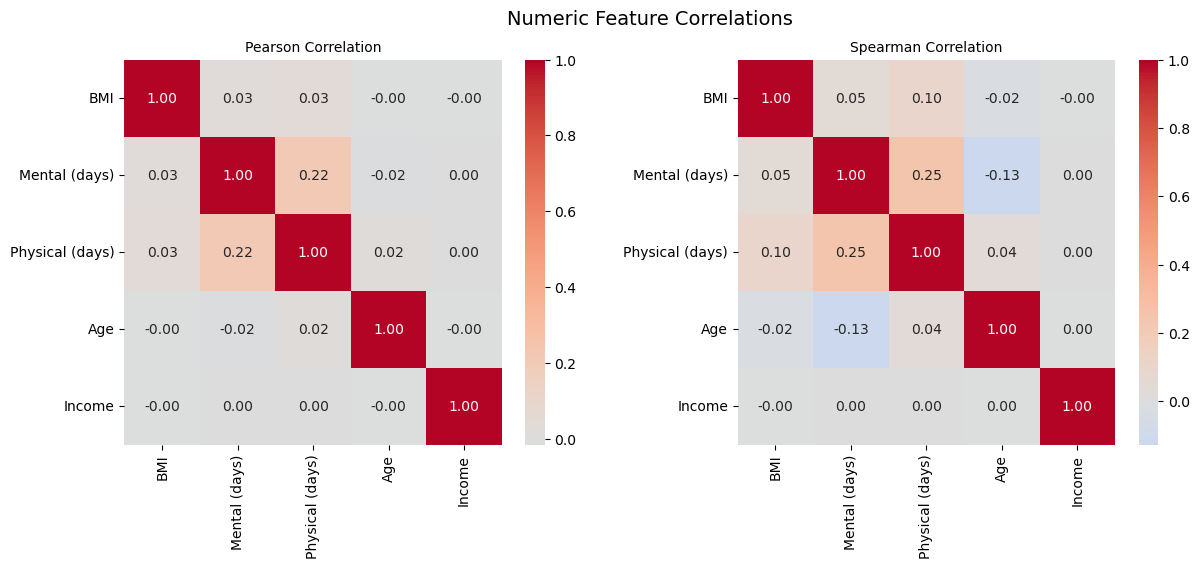

In [104]:
plot_numeric_correlations(X, numeric_features=numeric_features)

最大相关系数（绝对值）为 0.25，即即便是最强的两个连续特征，也只解释了 6.25%（0.25²） 的方差关系，可以得出连续特征之间冗余性低，几乎不存在高度重复信息。

### 3.2.2 离散型 vs 离散型
- **潜在问题**：两个分类变量分布高度依赖，携带的判别信息几乎相同。
- **检测方法**：**Cramér’s V**：基于卡方统计，量化两个分类变量的对称性相关性。
- **判定依据**：Cramér’s V ≈ 1 → 两个变量几乎完全依赖。

定义了
- Cramér’s V 计算工具 ``cramers_v(x, y)``
- 以及对 Cramér’s V 结果对可视化工具 ``plot_cramers_v(X: pd.DataFrame, categorical_features: list = None, per_feature_size=0.5, nunique_threshold=20,suptitle: str = "Cramér’s V Correlations (Categorical Features)")``

In [97]:
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """
    计算 Cramér's V，用于衡量两个类别型变量的相关性。

    参数:
    ----
    x, y : pd.Series
        输入的两个类别型变量

    返回:
    ----
    float
        Cramér's V 值，范围在 [0, 1]
    """
    # 1. 构建列联表（交叉频数表）
    contingency_table = pd.crosstab(x, y)

    # 2. 计算卡方统计量
    chi2, _, _, _ = chi2_contingency(contingency_table)

    # 3. 总样本数
    n_samples = contingency_table.values.sum()

    # 4. 行数和列数
    n_rows, n_cols = contingency_table.shape

    # 5. 自由度的最小值
    min_dim = min(n_rows - 1, n_cols - 1)

    # 6. 代入公式（避免除以零）
    if min_dim == 0:
        return 0.0
    return np.sqrt((chi2 / n_samples) / min_dim)

def plot_cramers_v(X: pd.DataFrame, categorical_features: list = None, per_feature_size=0.5, nunique_threshold=20,suptitle: str = "Cramér’s V Correlations (Categorical Features)"):
    """
    绘制类别型特征的 Cramér's V 相关性热力图。
    自动识别类别型特征：
    - dtype 为 object
    - 或唯一值数量小于 nunique_threshold 的特征

    参数:
    ----
    X : pd.DataFrame
        输入数据集
    categorical_features : list, optional
        类别型特征列表。如果为 None 或空列表，则自动选择符合条件的特征
    per_feature_size : float, default=0.5
        每个特征额外分配的图像尺寸，用于动态调整
    nunique_threshold : int, default=20
        唯一值数量低于该阈值的数值型特征也视为类别型
    suptitle : str, default="Cramér’s V Correlations (Categorical Features)"
        图表统一标题

    返回:
    ----
    None，直接显示热力图
    """
    # 如果用户提供了 categorical_features，先过滤不存在的特征
    if categorical_features:
        valid_features = [col for col in categorical_features if col in X.columns]
        invalid_features = [col for col in categorical_features if col not in X.columns]
        if invalid_features:
            print(f"警告：以下特征在数据中不存在，将被忽略: {invalid_features}")
        categorical_features = valid_features

    # 自动识别类别型特征
    if not categorical_features:
        categorical_features = []
        for col in X.columns:
            nunique = X[col].nunique()
            if X[col].dtype == 'object' or nunique < nunique_threshold:
                categorical_features.append(col)
        if not categorical_features:
            raise ValueError("数据集中没有符合条件的类别型特征。")

    n_features = len(categorical_features)

    # 动态调整图像大小
    width = max(8, n_features * per_feature_size)
    height = max(6, n_features * per_feature_size)

    # 构建 Cramér's V 矩阵
    cramers_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features, dtype=float)
    for col1 in categorical_features:
        for col2 in categorical_features:
            cramers_matrix.loc[col1, col2] = cramers_v(X[col1], X[col2])

    # 绘制热力图
    fig, ax = plt.subplots(figsize=(width, height))
    sns.heatmap(
        cramers_matrix.astype(float),
        annot=True,
        fmt=".2f",
        cmap="Reds",
        cbar_kws={'label': "Cramér's V"},
        ax=ax
    )
    ax.set_title("Cramér’s V Matrix", fontsize=10)  # 子图标题 10
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # 统一大标题
    fig.suptitle(suptitle, fontsize=14)  # 大标题 14
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 给大标题留出空间
    plt.show()

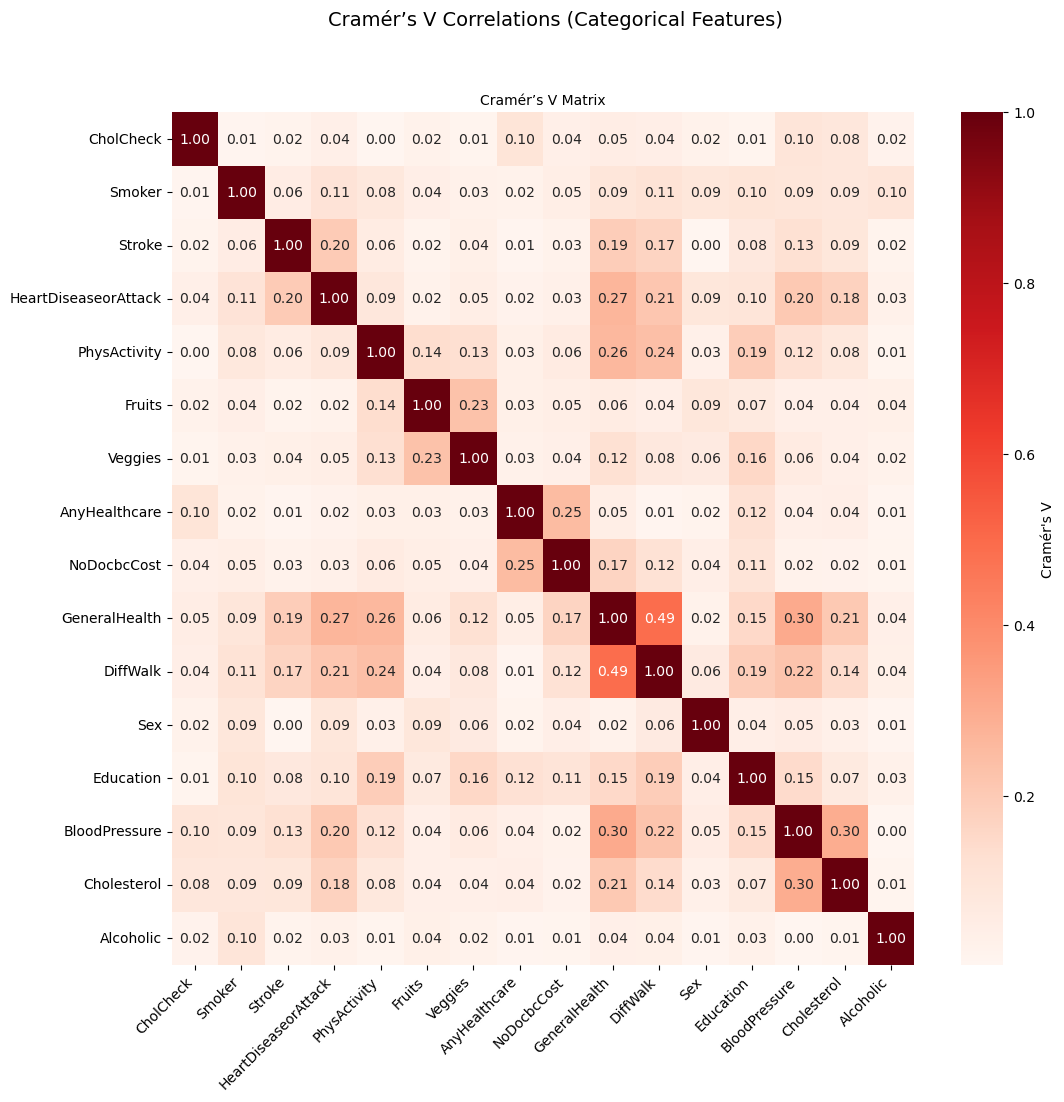

In [105]:
plot_cramers_v(X, categorical_features=categorical_features, per_feature_size=0.7)

最大值为 0.49，对应特征 DiffWalk 与 GeneralHealth，意味着这两个离散特征之间存在一定的信息重叠，DiffWalk 对 GeneralHealth 的分布有一定预测能力，这对特征可能存在部分冗余，可以在后续特征选择或降维时重点关注

### 3.2.3 连续型 vs 离散型
- **潜在问题**：某些连续变量和分类变量之间存在替代关系（redundancy），即分类变量几乎能完全解释连续变量的差异。这种冗余可能导致模型复杂度增加、共线性问题、过拟合风险，同时降低模型解释性。
- **检测方法**：通过 **方差分析 (ANOVA)** 检验连续变量在不同分类水平间是否存在显著差异。ANOVA 的 F 值衡量组间方差与组内方差的比值
- **判断依据**：
  - **F 值大且 p 值显著** → 连续变量在分类水平间差异显著，说明该连续变量部分信息可由分类变量解释（存在冗余）。
  - **F 值小或 p 值不显著** → 连续变量差异不明显，说明其信息独立。

In [111]:
def compute_anova_pair(X: pd.DataFrame, numeric_col: str, categorical_col: str) -> dict:
    """
    计算单个数值特征与单个分类特征的 ANOVA F 检验结果。
    仅保留两列都非缺失的行。

    参数:
    ----
    X : pd.DataFrame
        输入数据集
    numeric_col : str
        数值型特征列名
    categorical_col : str
        离散型特征列名

    返回:
    ----
    dict
        包含 'DiscreteFeature', 'NumericFeature', 'F', 'p'
    """
    # 保留非缺失行
    valid_idx = X[[categorical_col, numeric_col]].dropna().index
    if len(valid_idx) < 2:  # 样本太少
        return {"DiscreteFeature": categorical_col, "NumericFeature": numeric_col,
                "F": np.nan, "p": np.nan}

    X_valid = X.loc[valid_idx, numeric_col].values.reshape(-1, 1)
    y_valid = X.loc[valid_idx, categorical_col].factorize()[0]

    if len(np.unique(y_valid)) < 2:  # 分类水平不足
        return {"DiscreteFeature": categorical_col, "NumericFeature": numeric_col,
                "F": np.nan, "p": np.nan}

    f_score, p_val = f_classif(X_valid, y_valid)
    return {"DiscreteFeature": categorical_col, "NumericFeature": numeric_col,
            "F": float(f_score[0]), "p": float(p_val[0])}

def plot_anova_heatmap(X: pd.DataFrame, numeric_features: list, categorical_features: list,
                  figsize: tuple = (10, 6),
                  suptitle: str = "ANOVA F-values: Continuous vs Discrete Features\n(Stars indicate p-value significance)"):
    """
    批量计算数值型特征与分类特征的 ANOVA F 检验，并绘制热力图。

    参数:
    ----
    X : pd.DataFrame
        输入数据集
    numeric_features : list
        数值型特征列表
    categorical_features : list
        离散型特征列表
    figsize : tuple, default=(10,6)
        图像尺寸
    suptitle : str, optional
        图表标题
    """
    results = []

    for cat_col in categorical_features:
        for num_col in numeric_features:
            # 保留非缺失行
            valid_idx = X[[cat_col, num_col]].dropna().index
            if len(valid_idx) < 2:
                results.append({"DiscreteFeature": cat_col, "NumericFeature": num_col, "F": np.nan, "p": np.nan})
                continue

            X_valid = X.loc[valid_idx, num_col].values.reshape(-1, 1)
            y_valid = X.loc[valid_idx, cat_col].factorize()[0]

            if len(np.unique(y_valid)) < 2:
                results.append({"DiscreteFeature": cat_col, "NumericFeature": num_col, "F": np.nan, "p": np.nan})
                continue

            f_score, p_val = f_classif(X_valid, y_valid)
            results.append({"DiscreteFeature": cat_col, "NumericFeature": num_col,
                            "F": float(f_score[0]), "p": float(p_val[0])})

    anova_df = pd.DataFrame(results)

    # 构建热力图数据
    heatmap_F = anova_df.pivot(index="DiscreteFeature", columns="NumericFeature", values="F")
    heatmap_p = anova_df.pivot(index="DiscreteFeature", columns="NumericFeature", values="p")

    # 构建标注（F 值 + 显著性星号）
    annot_labels = heatmap_F.copy().astype(str)
    for i in range(heatmap_F.shape[0]):
        for j in range(heatmap_F.shape[1]):
            f_val = heatmap_F.iloc[i, j]
            p_val = heatmap_p.iloc[i, j]
            stars = ""
            if p_val < 0.001:
                stars = "***"
            elif p_val < 0.01:
                stars = "**"
            elif p_val < 0.05:
                stars = "*"
            annot_labels.iloc[i, j] = f"{f_val:.2f}{stars}"

    # 绘图
    plt.figure(figsize=figsize)
    sns.heatmap(
        heatmap_F,
        annot=annot_labels,
        fmt="",
        cmap="Reds",
        cbar_kws={'label': 'ANOVA F value'}
    )
    plt.title(suptitle, fontsize=14)
    plt.ylabel("Discrete Features")
    plt.xlabel("Continuous Features")
    plt.tight_layout()
    plt.show()

    return anova_df  # 同时返回结果，便于后续分析

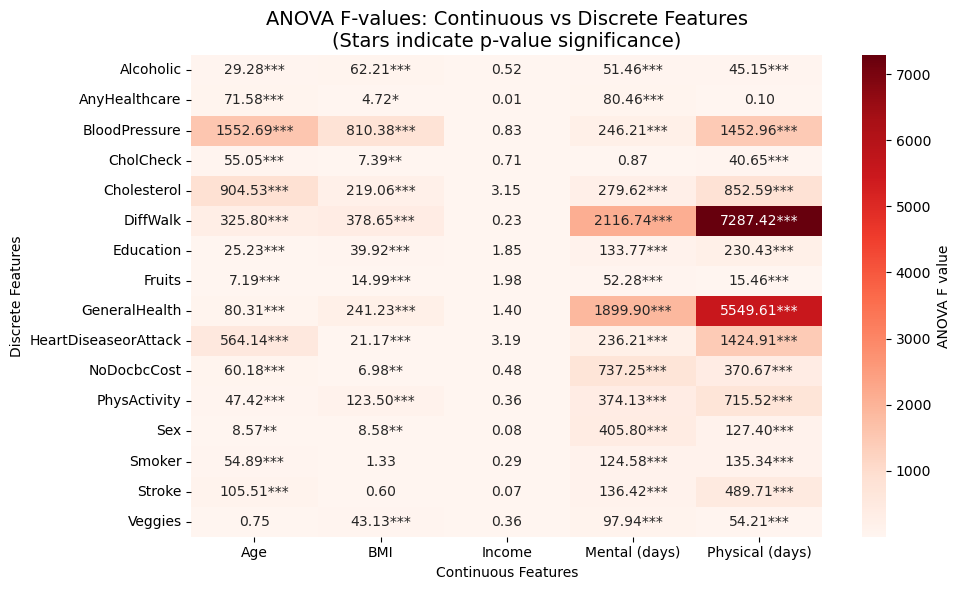

In [113]:
res_df = plot_anova_heatmap(df, numeric_features, categorical_features)

Income 几乎所有离散特征对应的 F 值都非常小，p 值远大于 0.05 → 表明收入在不同类别的离散特征间没有显著差异。

BloodPressure、DiffWalk、GeneralHealth 与多连续变量（BMI、Mental (days)、Physical (days)、Age）的 F 值极大，p 值几乎为 0

### 3.2.4 多特征共同作用
- **潜在问题**：某个特征可能不是与单一变量相关，而是能被多个特征线性或非线性组合近似重建。
- **检测方法**：**线性回归替代性 (R²)**：用其他所有特征回归预测该变量，若 R² 高，则冗余度高。
- **推断依据**：R² ≈ 1：该特征几乎完全由其他特征线性组合得到，可视为冗余。

### 3.1 冗余和重复特征处理

在数据集中，特征之间可能存在 **冗余（redundancy）** 或 **重复信息（duplication）**，其危害包括：
- **模型估计不稳定**：多重共线性导致系数方差膨胀，回归结果不可靠。
- **信息冗余**：不同特征携带的是相同信息，增加维度却未提升模型解释力。
- **过拟合风险**：噪声在冗余特征间被反复放大，模型泛化能力下降。
- **计算负担加重**：无效特征增加模型复杂度，降低效率。

因此，需要根据特征类型和依赖模式，采用相应方法检测冗余。

#### 3.1.1 连续型 vs 连续型

- **潜在问题**：两个连续变量高度线性或单调相关，本质上提供重复信息。
- **检测方法**：
  - **Pearson 相关系数**：检测线性相关性（适用于正态分布变量）。
  - **Spearman 秩相关系数**：检测单调相关性（对异常值和非线性更鲁棒）。
- **理论依据**：若相关系数接近 ±1，说明变量间信息高度重合，其中一个可被视为冗余。

In [193]:
def plot_numeric_correlations(X: pd.DataFrame, numeric_features: list = None, per_feature_size=0.5):
    """
    绘制数值型特征的 Pearson 与 Spearman 相关性热力图，图像大小自适应特征数量。

    参数:
    ----
    X : pd.DataFrame
        输入数据集
    numeric_features : list, optional
        需要计算相关性的数值型特征列表。如果为 None 或空列表，则自动选择所有数值型特征
    per_feature_size : float, default=0.5
        每个特征额外分配的图像尺寸，用于动态调整

    返回:
    ----
    None, 直接显示热力图
    """
    # 如果 numeric_features 没有提供，则使用所有数值型特征
    if not numeric_features:
        numeric_features = X.select_dtypes(include='number').columns.tolist()
        if not numeric_features:
            raise ValueError("数据集中没有数值型特征可以计算相关性。")

    n_features = len(numeric_features)

    # 每张子图占用的尺寸
    width_per_subplot = max(6, n_features * per_feature_size)
    height = max(5, n_features * per_feature_size)

    # 总宽度 = 两张子图宽度 + 子图间距
    total_width = width_per_subplot * 2 + 2  # 2 英寸间隔

    # 计算相关系数矩阵
    pearson_corr = X[numeric_features].corr(method="pearson")
    spearman_corr = X[numeric_features].corr(method="spearman")

    # 绘制子图
    fig, axes = plt.subplots(1, 2, figsize=(total_width, height))

    sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[0])
    axes[0].set_title("Pearson Correlation")

    sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[1])
    axes[1].set_title("Spearman Correlation")

    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # 调整子图间距
    plt.show()

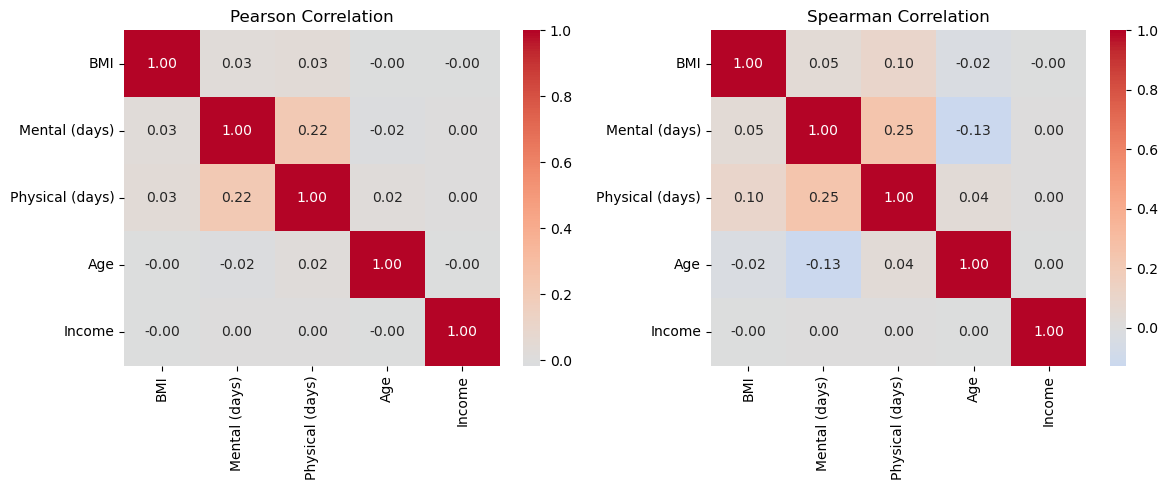

In [186]:
plot_numeric_correlations(X, numeric_features=numeric_features)

最大相关系数（绝对值）为 0.25，即即便是最强的两个连续特征，也只解释了 6.25%（0.25²） 的方差关系，可以得出连续特征之间冗余性低，几乎不存在高度重复信息。

最大相关系数（绝对值）为 0.25，即即便是最强的两个连续特征，也只解释了 6.25%（0.25²） 的方差关系，可以得出连续特征之间冗余性低，几乎不存在高度重复信息。

#### 3.1.2 离散型 vs 离散型
- **潜在问题**：两个分类变量分布高度依赖，携带的判别信息几乎相同。
- **检测方法**：
  - **Cramér’s V**：基于卡方统计，量化两个分类变量的对称性相关性。
- **理论依据**：
  - Cramér’s V ≈ 1 → 两个变量几乎完全依赖。

In [205]:
def cramers_v(x, y):
    """
    计算两列的 Cramér's V 值。

    参数:
    ----
    x, y : pd.Series
        两个类别型特征列

    返回:
    ----
    float, Cramér's V 值
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2/n) / (min(k-1, r-1))) if min(k-1, r-1) > 0 else 0.0

def plot_cramers_v(X: pd.DataFrame, categorical_features: list = None, per_feature_size=0.5, nunique_threshold=20):
    """
    绘制类别型特征的 Cramér's V 相关性热力图。
    自动识别类别型特征：
    - dtype 为 object
    - 或唯一值数量小于 nunique_threshold 的特征

    参数:
    ----
    X : pd.DataFrame
        输入数据集
    categorical_features : list, optional
        类别型特征列表。如果为 None 或空列表，则自动选择符合条件的特征
    per_feature_size : float, default=0.5
        每个特征额外分配的图像尺寸，用于动态调整
    nunique_threshold : int, default=20
        唯一值数量低于该阈值的数值型特征也视为类别型

    返回:
    ----
    None，直接显示热力图
    """
    # 如果用户提供了 categorical_features，先过滤不存在的特征
    if categorical_features:
        valid_features = [col for col in categorical_features if col in X.columns]
        invalid_features = [col for col in categorical_features if col not in X.columns]
        if invalid_features:
            print(f"警告：以下特征在数据中不存在，将被忽略: {invalid_features}")
        categorical_features = valid_features

    # 自动识别类别型特征
    if not categorical_features:
        categorical_features = []
        for col in X.columns:
            nunique = X[col].nunique()
            if X[col].dtype == 'object' or nunique < nunique_threshold:
                categorical_features.append(col)
        if not categorical_features:
            raise ValueError("数据集中没有符合条件的类别型特征。")

    n_features = len(categorical_features)

    # 动态调整图像大小
    width = max(8, n_features * per_feature_size)
    height = max(6, n_features * per_feature_size)

    # 构建 Cramér's V 矩阵
    cramers_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features, dtype=float)
    for col1 in categorical_features:
        for col2 in categorical_features:
            cramers_matrix.loc[col1, col2] = cramers_v(X[col1], X[col2])

    # 绘制热力图
    plt.figure(figsize=(width, height))
    sns.heatmap(
        cramers_matrix.astype(float),
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        cbar_kws={'label': "Cramér's V"}
    )
    plt.title("Cramér’s V (Categorical Features)")
    plt.xticks(rotation=45, ha='right')  # 自动旋转 x 轴标签
    plt.tight_layout()
    plt.show()

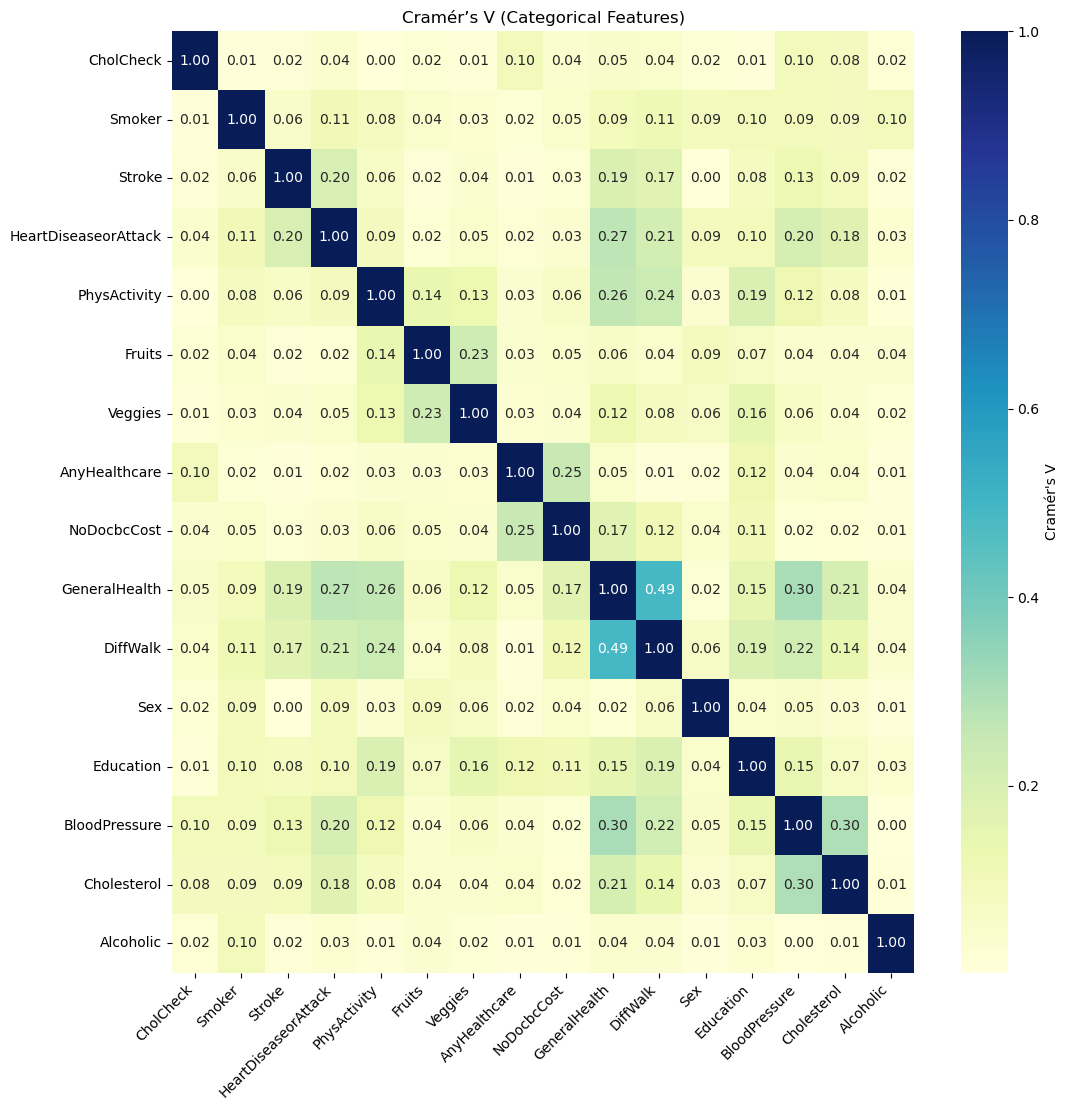

In [202]:
plot_cramers_v(X, categorical_features=categorical_features, per_feature_size=0.7)

最大值为 0.49，对应特征 DiffWalk 与 GeneralHealth，意味着这两个离散特征之间存在一定的信息重叠，DiffWalk 对 GeneralHealth 的分布有一定预测能力，这对特征可能存在部分冗余，可以在后续特征选择或降维时重点关注

#### 3.1.3 连续型 vs 离散型
- **潜在问题**：某些连续变量和分类变量之间存在替代关系（redundancy），即分类变量几乎能完全解释连续变量的差异。这种冗余可能导致模型复杂度增加、共线性问题、过拟合风险，同时降低模型解释性。
- **检测方法**：通过 **方差分析 (ANOVA)** 检验连续变量在不同分类水平间是否存在显著差异。ANOVA 的 F 值衡量组间方差与组内方差的比值：
  - **F 值大且 p 值显著** → 连续变量在分类水平间差异显著，说明该连续变量部分信息可由分类变量解释（存在冗余）。
  - **F 值小或 p 值不显著** → 连续变量差异不明显，说明其信息独立。
- **理论依据**：
  1. ANOVA 是检验组均值差异的标准统计方法，可量化连续变量对分类变量的响应程度。
  2. 若连续变量被分类变量划分的方差占比高，说明信息重复或替代性强。
  3. 该方法对多连续 vs 多离散组合均可应用，通过构建 F 值矩阵，可系统识别冗余关系，为特征选择和降维提供依据。

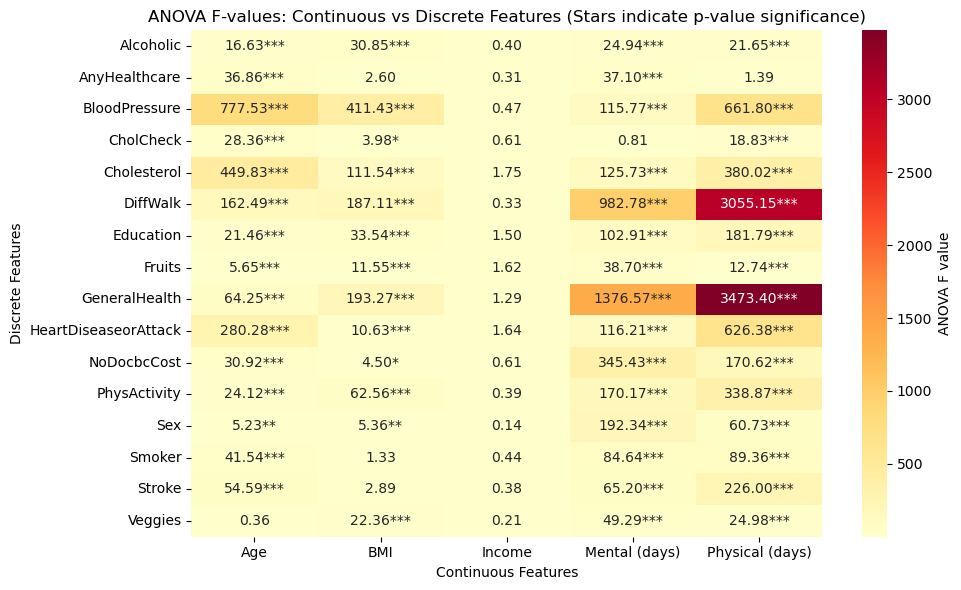

In [14]:
# 1. 确保数值型特征没有缺失
X_num_filled = X[numeric_features].fillna(X[numeric_features].median())

anova_results = []

# 2. 遍历每个离散特征，计算连续特征的 ANOVA F 值
for cat_col in categorical_features:
    # 将离散特征 factorize 为整数
    y_cat = X[cat_col].factorize()[0]

    # 对每个连续特征做 ANOVA F 检验
    f_scores, p_values = f_classif(X_num_filled, y_cat)
    for feat, f, p in zip(numeric_features, f_scores, p_values):
        anova_results.append({
            "DiscreteFeature": cat_col,
            "NumericFeature": feat,
            "F": f,
            "p": p
        })

anova_df = pd.DataFrame(anova_results)

# 构建热力图数据
heatmap_F = anova_df.pivot(index="DiscreteFeature", columns="NumericFeature", values="F")
heatmap_p = anova_df.pivot(index="DiscreteFeature", columns="NumericFeature", values="p")

# 4. 构建标注：F值 + 显著性星号
annot_labels = heatmap_F.copy().astype(str)
for i in range(heatmap_F.shape[0]):
    for j in range(heatmap_F.shape[1]):
        f_val = heatmap_F.iloc[i, j]
        p_val = heatmap_p.iloc[i, j]
        # 添加显著性星号
        stars = ""
        if p_val < 0.001:
            stars = "***"
        elif p_val < 0.01:
            stars = "**"
        elif p_val < 0.05:
            stars = "*"
        annot_labels.iloc[i, j] = f"{f_val:.2f}{stars}"

# 可视化
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_F, 
    annot=annot_labels, 
    fmt="", 
    cmap="YlOrRd", 
    cbar_kws={'label': 'ANOVA F value'}
)
plt.title("ANOVA F-values: Continuous vs Discrete Features (Stars indicate p-value significance)")
plt.ylabel("Discrete Features")
plt.xlabel("Continuous Features")
plt.tight_layout()
plt.show()

Income 几乎所有离散特征对应的 F 值都非常小，p 值远大于 0.05 → 表明收入在不同类别的离散特征间没有显著差异。
DiffWalk 和 GeneralHealth 与多连续变量（BMI、Mental (days)、Physical (days)、Age）的 F 值极大，p 值几乎为 0 → 显示 GeneralHealth 的不同类别下，这些连续特征分布差异显著，也表明DiffWalk 和 GeneralHealth高度关联

#### 3.1.4 多特征共同作用
- **潜在问题**：某个特征可能不是与单一变量相关，而是能被多个特征线性或非线性组合近似重建。
- **检测方法**：
  - **线性回归替代性 (R²)**：用其他所有特征回归预测该变量，若 R² 高，则冗余度高。
- **理论依据**：
  - R² ≈ 1：该特征几乎完全由其他特征线性组合得到，可视为冗余。

In [15]:
redundancy_scores = {}

for target_col in X.columns:
    # 删除目标列缺失的行
    mask = X[target_col].notna()
    X_subset = X.loc[mask].copy()
    
    y = X_subset[target_col]
    others = X_subset.drop(columns=[target_col])
    
    # 对连续特征填充缺失值
    for col in numeric_features:
        if col != target_col:
            others[col] = others[col].fillna(others[col].median())
    
    # 分类特征已映射为数值，不需要 one-hot 编码，只需填充缺失
    for col in categorical_features:
        if col != target_col:
            others[col] = others[col].fillna(others[col].mode()[0])

    # 拟合线性回归
    model = LinearRegression()
    model.fit(others, y)
    preds = model.predict(others)

    # 计算 R²
    redundancy_scores[target_col] = r2_score(y, preds)

# 输出结果表格
table = [(feat, f"{score:.3f}") for feat, score in redundancy_scores.items()]
print(tabulate(table, headers=["Feature", "R²"], tablefmt="grid"))

+----------------------+-------+
| Feature              |    R² |
+======================+=======+
| CholCheck            | 0.016 |
+----------------------+-------+
| BMI                  | 0.01  |
+----------------------+-------+
| Smoker               | 0.002 |
+----------------------+-------+
| Stroke               | 0.052 |
+----------------------+-------+
| HeartDiseaseorAttack | 0.095 |
+----------------------+-------+
| PhysActivity         | 0.077 |
+----------------------+-------+
| Fruits               | 0.002 |
+----------------------+-------+
| Veggies              | 0.029 |
+----------------------+-------+
| AnyHealthcare        | 0.031 |
+----------------------+-------+
| NoDocbcCost          | 0.051 |
+----------------------+-------+
| GeneralHealth        | 0.256 |
+----------------------+-------+
| Mental (days)        | 0.066 |
+----------------------+-------+
| Physical (days)      | 0.144 |
+----------------------+-------+
| DiffWalk             | 0.208 |
+---------

GeneralHealth 的 R² 值最大，约 26% 的信息可被其他特征线性预测。Income 的 R² 值为 0，说明几乎完全 不可由其他特征线性预测，信息独立性高，与之前ANOVA检验结果一致。综合各方面分析，GeneralHealth 是最大冗余特征，而 DiffWalk 与 GeneralHealth 的潜在信息重复也值得重点关注；其他低 R² 特征信息独立性高，应优先保留。

### 3.2 异常值处理

离散型变量的数值通常是编码后的类别标签，其数值本身并不具备可比较的大小关系，也没有明确的量化意义。  
  - 在这种情况下，针对离散型变量直接进行异常值检测没有统计意义，因为数值大小并不表示强度或量度关系。  
  - 若误将离散变量的编码值作为连续数值处理，可能导致错误剔除或修改类别，从而破坏原有类别信息。
因此，异常值处理仅针对连续型变量进行，确保处理的数值有实际量化意义，并不会改变类别结构。

#### 3.2.1 连续数据分布

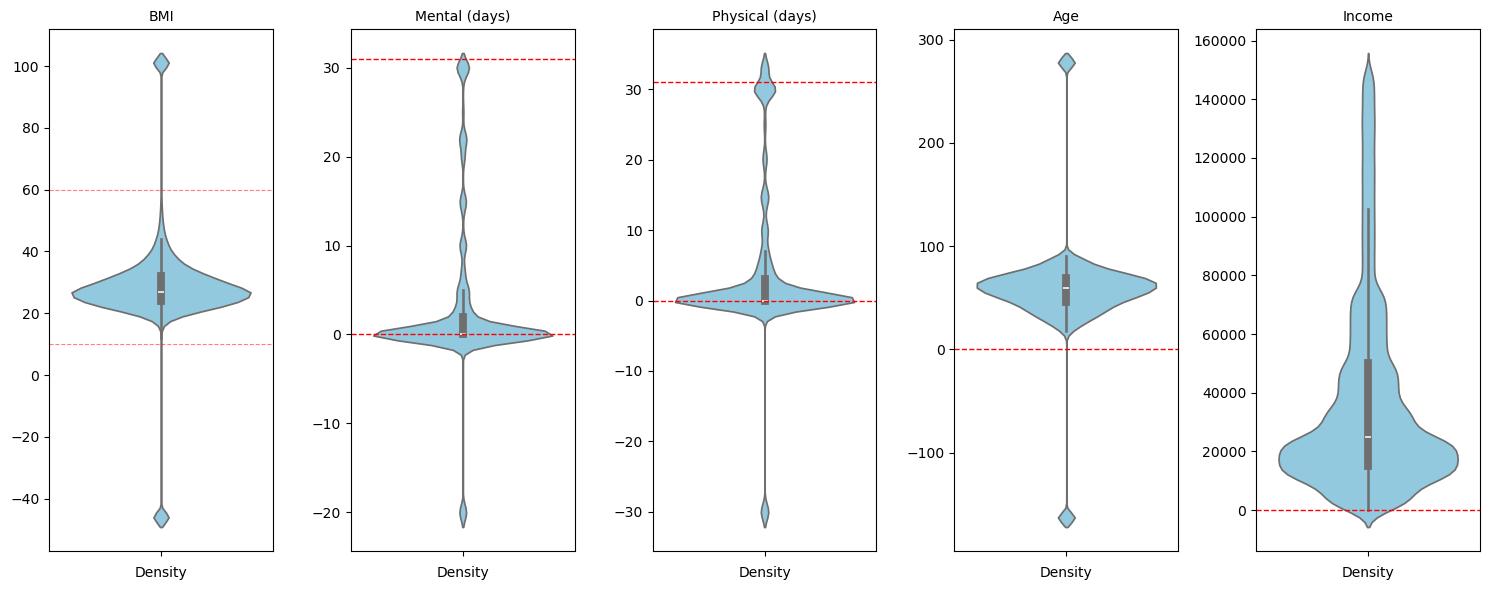

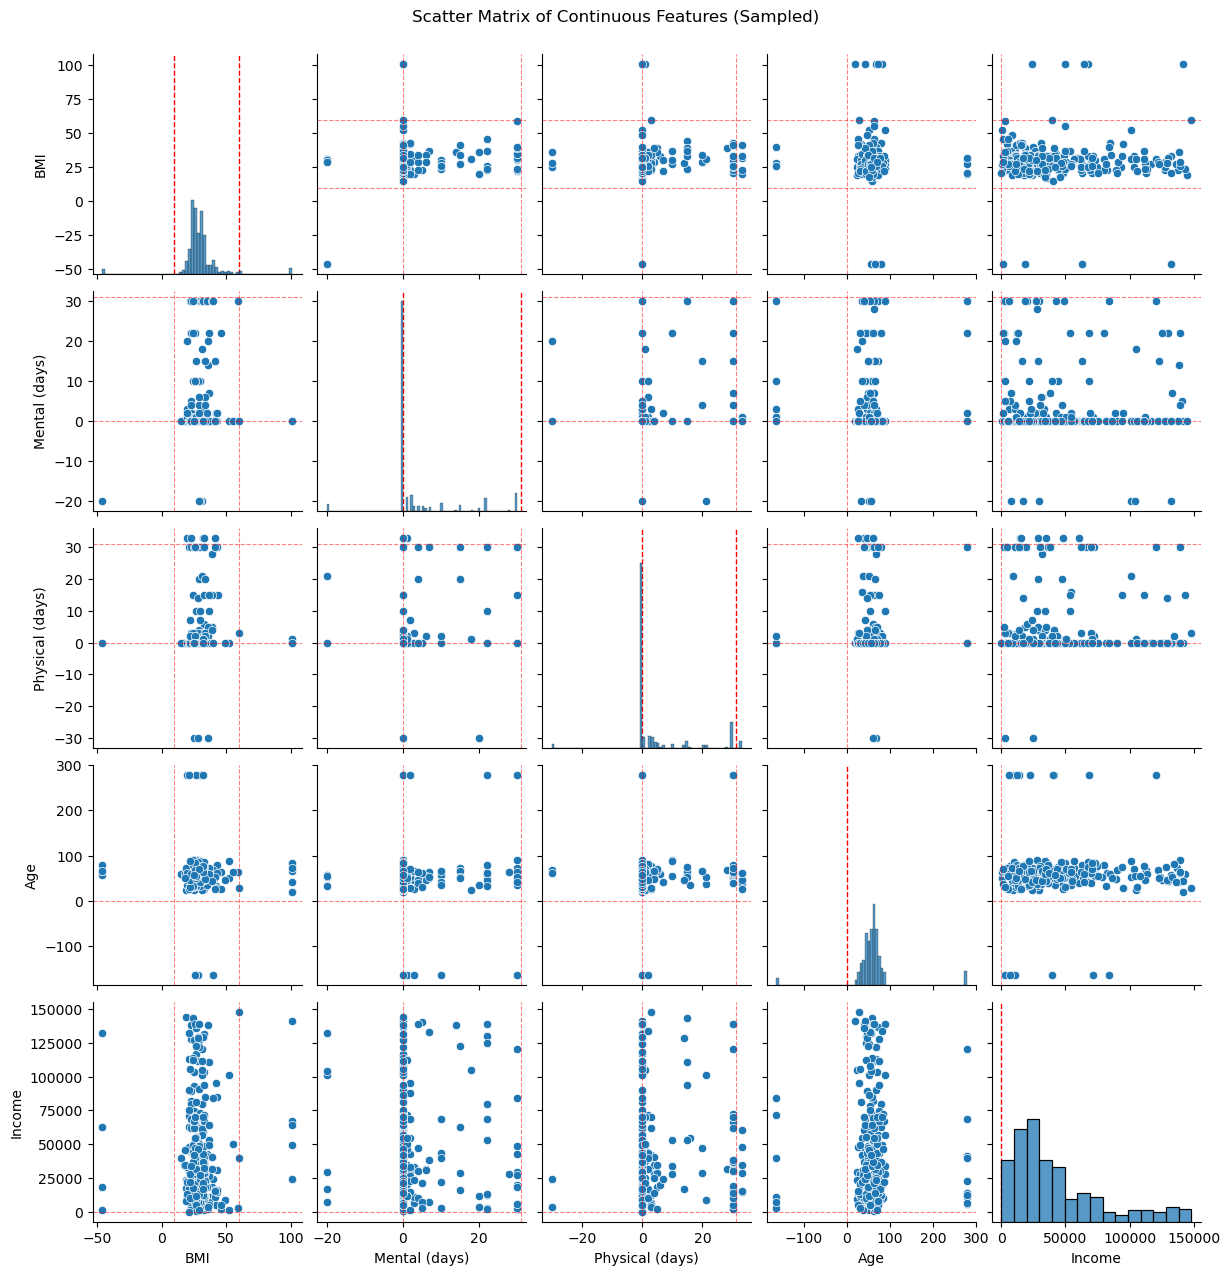

In [16]:
# 数值型特征子集
X_num = X[numeric_features]

# -------- 1. 小提琴图 --------
plt.figure(figsize=(len(numeric_features)*3, 6))
for i, col in enumerate(numeric_features):
    plt.subplot(1, len(numeric_features), i+1)
    sns.violinplot(y=X_num[col], inner="box", color="skyblue")
    plt.title(col, fontsize=10)
    plt.xlabel("Density")
    plt.ylabel("")

    # 添加辅助线
    if col.lower() == "bmi":
        plt.axhline(10, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        plt.axhline(60, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
    elif col.lower() in ["mental (days)", "physical (days)"]:
        plt.axhline(0, color="red", linestyle="--", linewidth=1)
        plt.axhline(31, color="red", linestyle="--", linewidth=1)
    elif col.lower() in ["age", "income"]:
        plt.axhline(0, color="red", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


# -------- 2. 散点矩阵 --------
sampled_X = X_num.sample(min(500, len(X_num)), random_state=42)
g = sns.pairplot(sampled_X)
g.fig.suptitle("Scatter Matrix of Continuous Features (Sampled)", y=1.02)

# 遍历子图加辅助线
for i, row_var in enumerate(g.y_vars):
    for j, col_var in enumerate(g.x_vars):
        ax = g.axes[i, j]

        # 对角线：直方图 → 竖线
        if i == j:
            if row_var.lower() == "bmi":
                ax.axvline(10, color="red", linestyle="--", linewidth=1)
                ax.axvline(60, color="red", linestyle="--", linewidth=1)
            elif row_var.lower() in ["mental (days)", "physical (days)"]:
                ax.axvline(0, color="red", linestyle="--", linewidth=1)
                ax.axvline(31, color="red", linestyle="--", linewidth=1)
            elif row_var.lower() in ["age", "income"]:
                ax.axvline(0, color="red", linestyle="--", linewidth=1)

        # 非对角线：散点图 → 横线+竖线
        else:
            # y 轴（行变量）
            if row_var.lower() == "bmi":
                ax.axhline(10, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
                ax.axhline(60, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            elif row_var.lower() in ["mental (days)", "physical (days)"]:
                ax.axhline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
                ax.axhline(31, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            elif row_var.lower() in ["age", "income"]:
                ax.axhline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)

            # x 轴（列变量）
            if col_var.lower() == "bmi":
                ax.axvline(10, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
                ax.axvline(60, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            elif col_var.lower() in ["mental (days)", "physical (days)"]:
                ax.axvline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
                ax.axvline(31, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            elif col_var.lower() in ["age", "income"]:
                ax.axvline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)

plt.show()

在本数据集中，数值型特征包括 **BMI (Body Mass Index)**、**Age**、**Income**、以及涉及天数的 **Mental (days)** 和 **Physical (days)**。结合统计学原则、医学和社会学背景，可得以下结论：

1. **理论范围与背景知识**  
   - **BMI**：根据世界卫生组织（WHO）标准，人体BMI通常在 **10–60** 之间。BMI <10 或 >60 极端异常，通常为测量或录入错误。  
   - **Age（年龄）**：理论上应大于等于 0。负值或极端异常均不符合生物学规律。  
   - **Mental (days) / Physical (days)**：天数应在 **0–31** 之间。负值或大于31均为异常数据。  
   - **Income（收入）**：社会经济背景允许收入分布较宽，因此即便出现偏态或极端值，也可以认为在可接受范围内，不直接视为异常。  

2. **观测到的异常情况**  
   - **集中出现的异常值**：  
     - Mental (days)：-20  
     - Physical (days)：-30, 33  
     - BMI：-46, 101  
     - Age：-163, 278  
   - 这些值均超出理论合理范围，且可能源于数据采集过程中的人工编码或特殊标记，尚不明确其具体含义。  
   - 基于统计学稳健性原则，这类异常值会对均值、方差、回归模型等分析产生显著影响，应当剔除。  

#### 3.2.2 初步异常值处理
- **处理范围**：
  - BMI < 0 或 = 101 → NaN  
  - Age < 0 或 = 278 → NaN  
  - Mental (days) < 0 或 > 31 → NaN  
  - Physical (days) < 0 或 > 31 → NaN  
之后对BMI进行更深入分析

In [17]:
df, X, y = load_preprocess_plot('diabetes_diagnosis.csv', numeric_features, categorical_features)

df_clean = df.copy()
n_rows = len(df)

# 定义异常条件
conditions = {
    'BMI': (df['BMI'] < 0) | (df['BMI'] == 101),
    'Age': (df['Age'] < 0) | (df['Age'] == 278),
    'Mental (days)': (df['Mental (days)'] < 0) | (df['Mental (days)'] > 31),
    'Physical (days)': (df['Physical (days)'] < 0) | (df['Physical (days)'] > 31)
}

# 统计每列异常数量和占比
anomaly_summary = []
for col, cond in conditions.items():
    count = cond.sum()
    ratio = count / n_rows * 100
    anomaly_summary.append([col, count, f"{ratio:.2f}%"])
    
    # 替换异常为 NaN
    df_clean.loc[cond, col] = np.nan

# 输出表格
print(tabulate(anomaly_summary, headers=['Feature', 'Replaced as NaN', 'Proportion'], tablefmt='grid', stralign='center', numalign='center'))

# Save cleaned data
output_filename = "diabetes_diagnosis_initial_anomaly_handling.csv"
df_clean.to_csv(output_filename, index=False, encoding="utf-8-sig")

print(f"Data saved as: {os.path.abspath(output_filename)}")

+-----------------+-------------------+--------------+
|     Feature     |  Replaced as NaN  |  Proportion  |
+=================+===================+==============+
|       BMI       |       8144        |    3.34%     |
+-----------------+-------------------+--------------+
|       Age       |       9283        |    3.81%     |
+-----------------+-------------------+--------------+
|  Mental (days)  |       3093        |    1.27%     |
+-----------------+-------------------+--------------+
| Physical (days) |       5667        |    2.33%     |
+-----------------+-------------------+--------------+
Data saved as: /Users/guocy/Projects/5310_a1/diabetes/diabetes_diagnosis_initial_anomaly_handling.csv


#### 3.2.3 对BMI的进一步异常值分析

=== 数据集基本信息 ===
维度: (243618, 22)
=== 连续特征分布（小提琴图） ===


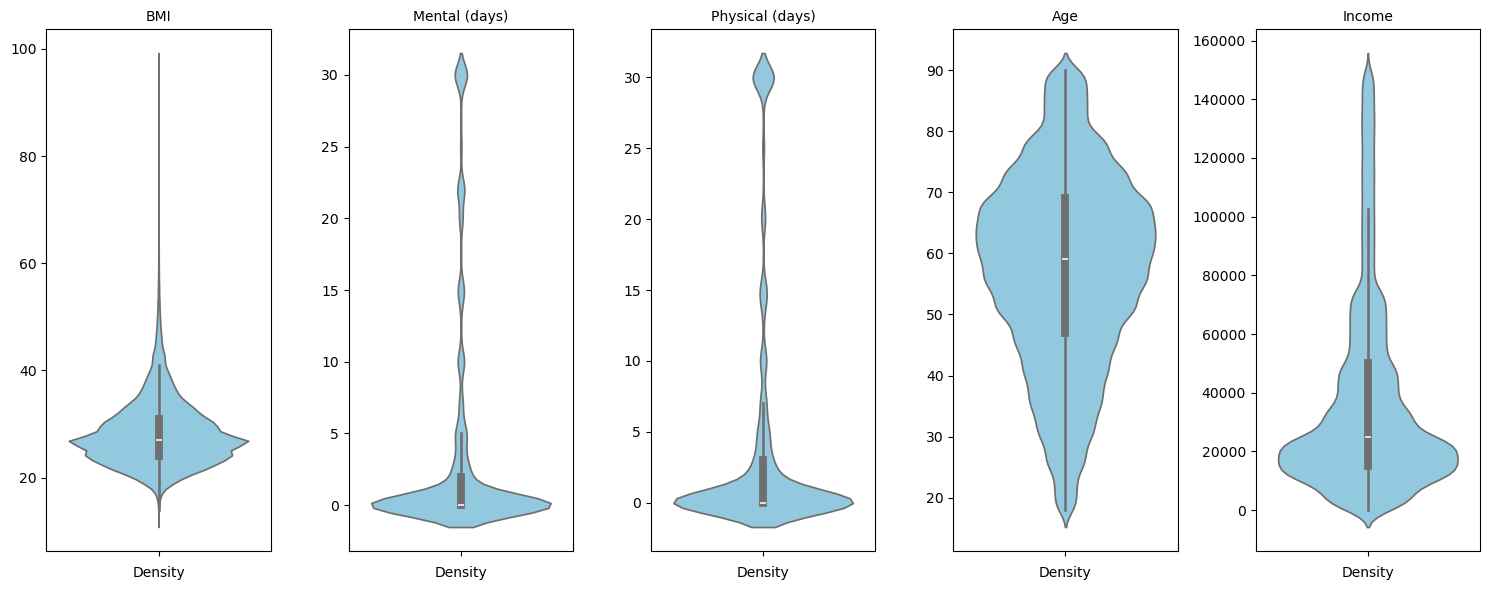


=== 分类特征分布（柱状图） ===


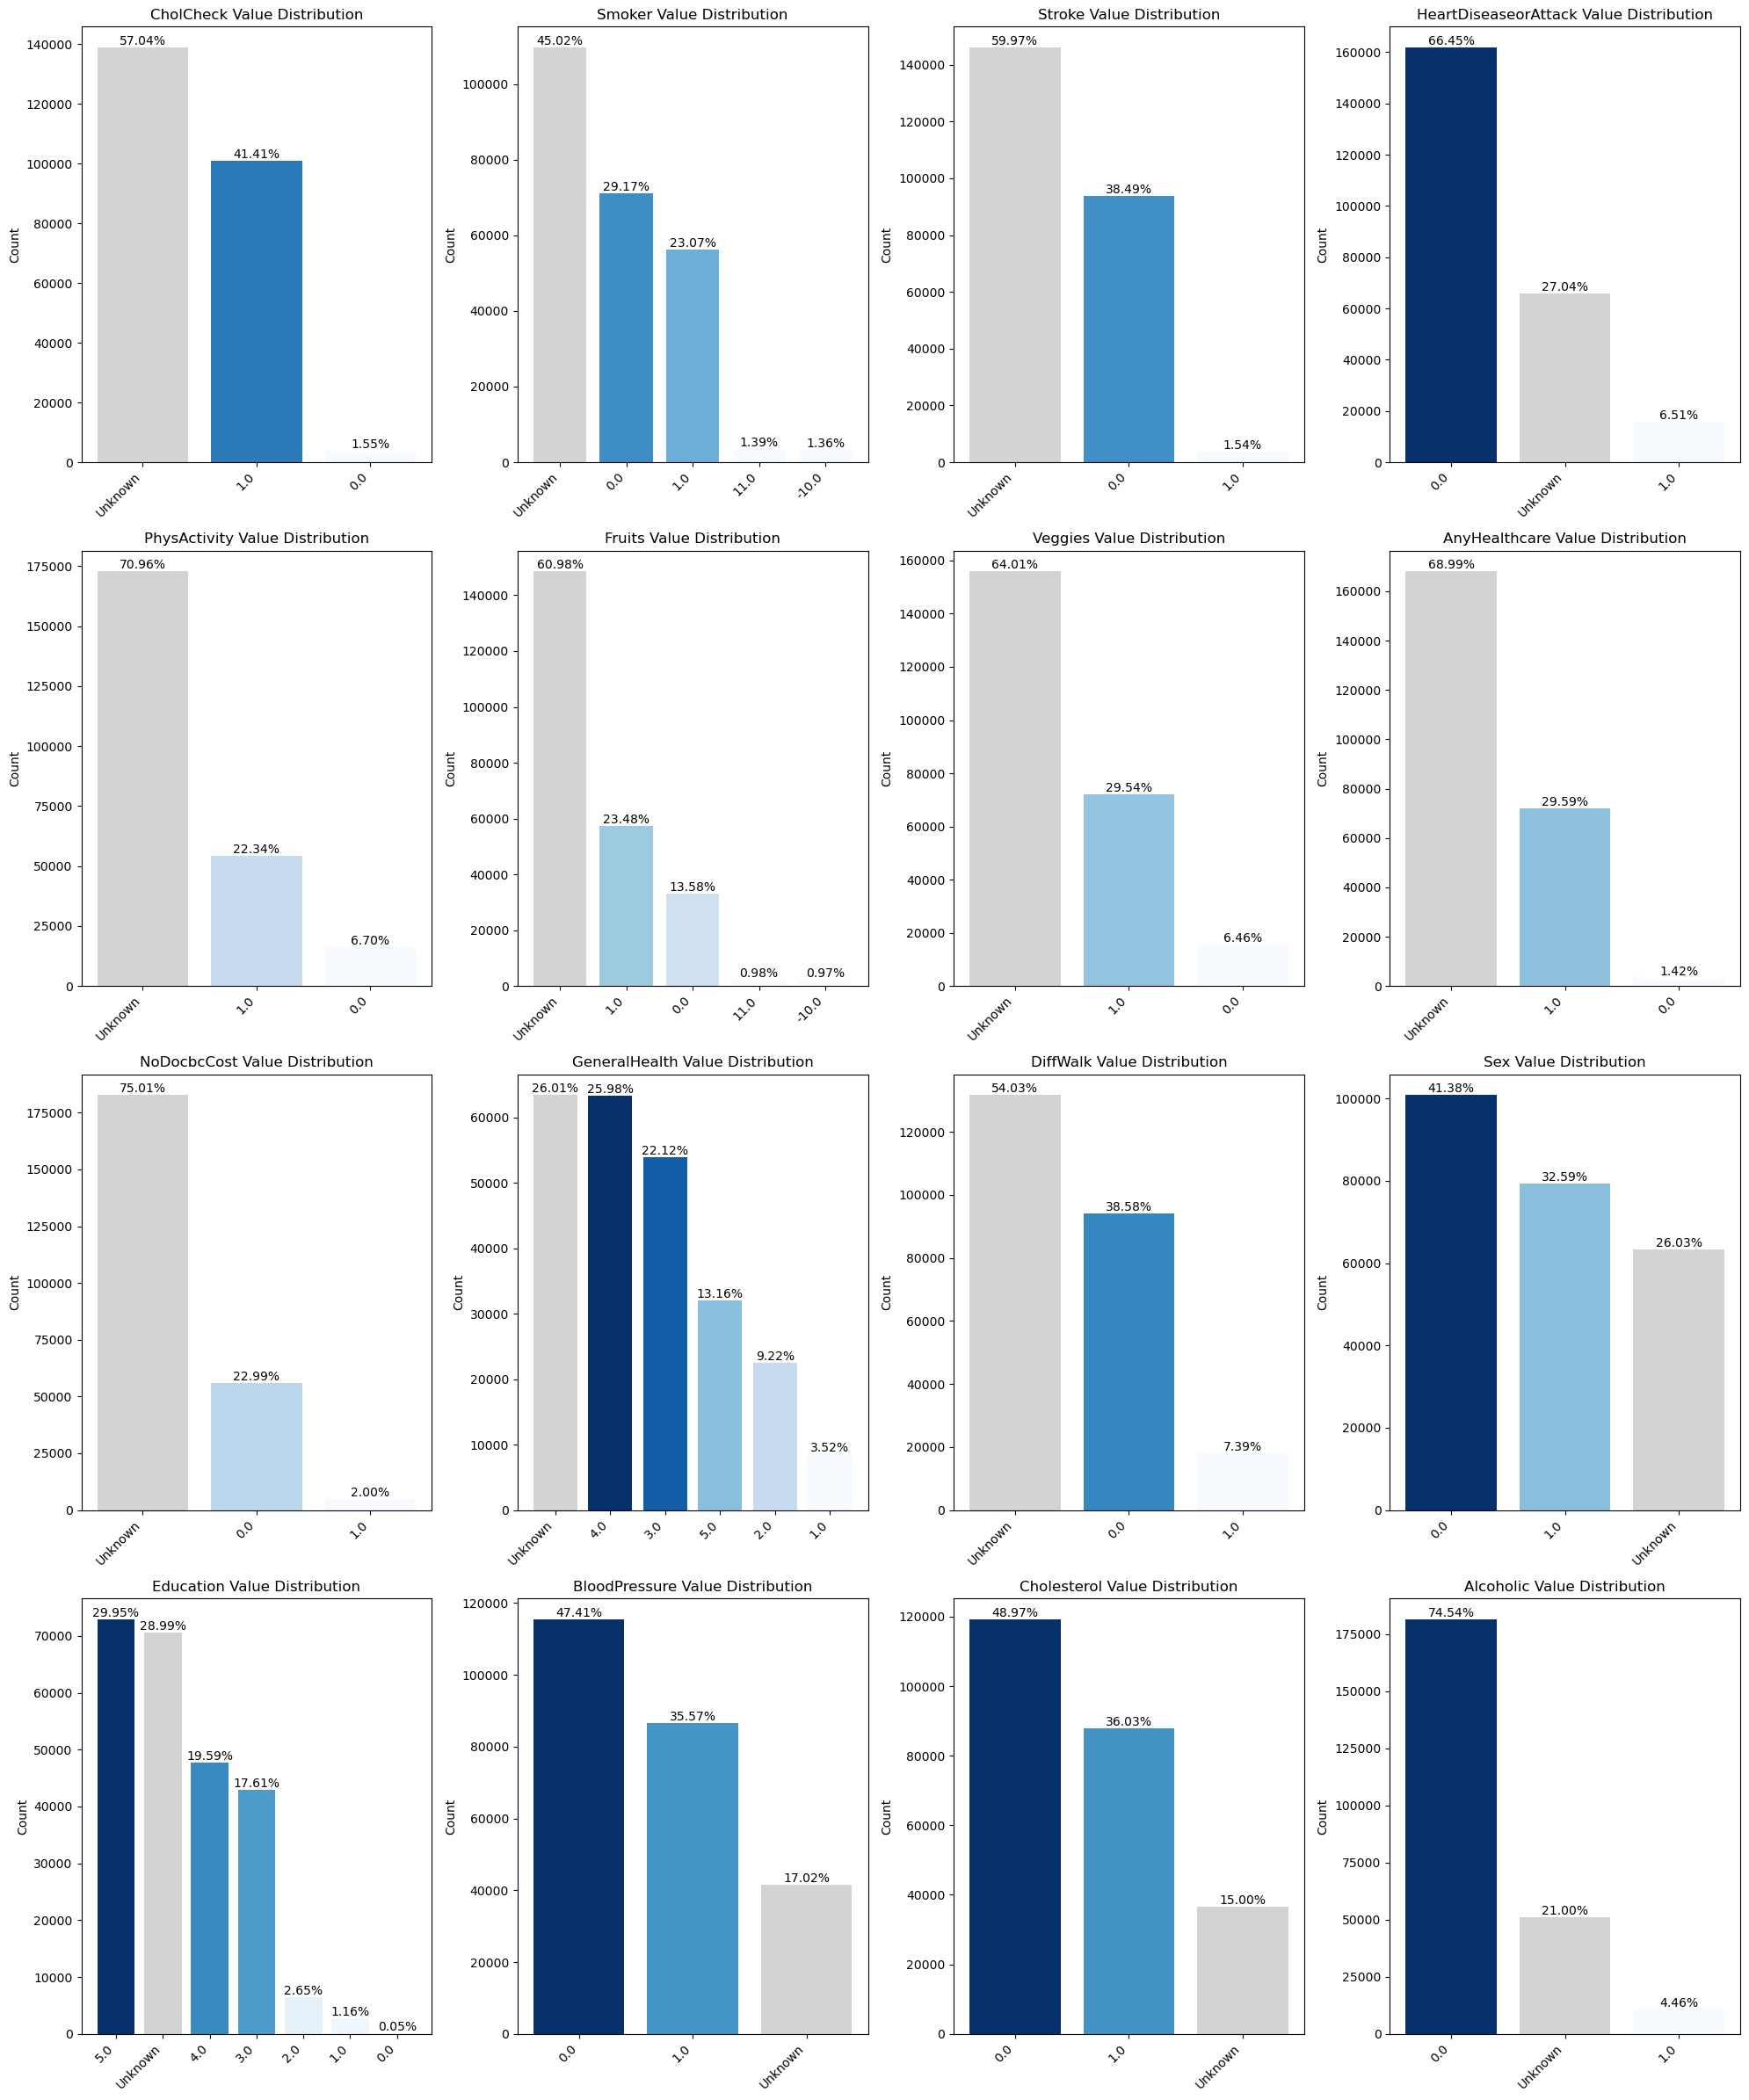

=== 缺失值信息（柱状图） ===


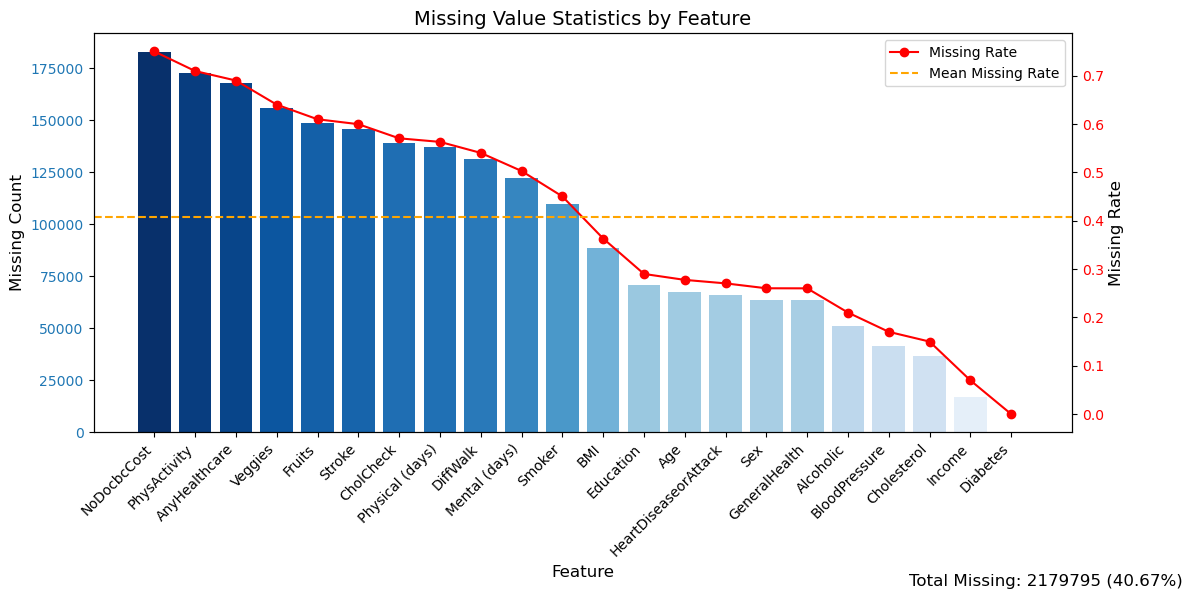

In [18]:
df, X, y = load_preprocess_plot('diabetes_diagnosis_initial_anomaly_handling.csv', numeric_features, categorical_features, do_plot=True)

+--------------+-----------+
| Statistic    |     Value |
+==============+===========+
| Count        | 155137.00 |
+--------------+-----------+
| Mean         |     28.39 |
+--------------+-----------+
| Std          |      6.62 |
+--------------+-----------+
| Min          |     12.00 |
+--------------+-----------+
| 25%          |     24.00 |
+--------------+-----------+
| 50% (Median) |     27.00 |
+--------------+-----------+
| 75%          |     31.00 |
+--------------+-----------+
| Max          |     98.00 |
+--------------+-----------+
| IQR          |      7.00 |
+--------------+-----------+
| Skewness     |      2.13 |
+--------------+-----------+
| Kurtosis     |     10.99 |
+--------------+-----------+
Lower outliers: 17 (0.0%)
Upper outliers: 6041 (3.9%)


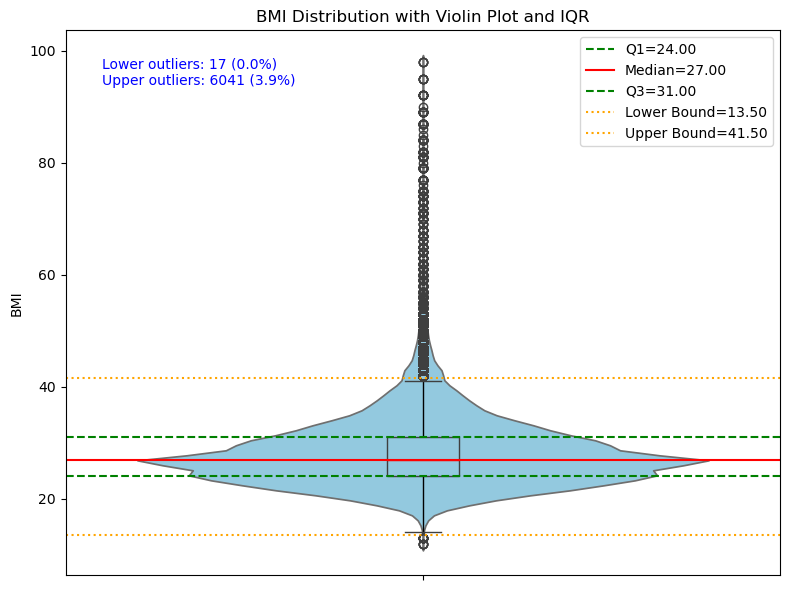

In [19]:
# --- 1. 提取非 NaN BMI ---
bmi = df['BMI'].dropna()

# --- 2. 计算统计特征 ---
Q1 = bmi.quantile(0.25)
Median = bmi.median()
Q3 = bmi.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

bmi_stats = {
    'Count': len(bmi),
    'Mean': bmi.mean(),
    'Std': bmi.std(),
    'Min': bmi.min(),
    '25%': Q1,
    '50% (Median)': Median,
    '75%': Q3,
    'Max': bmi.max(),
    'IQR': IQR,
    'Skewness': bmi.skew(),
    'Kurtosis': bmi.kurtosis()
}
print(tabulate(bmi_stats.items(), headers=['Statistic','Value'], tablefmt='grid', floatfmt=".2f"))

# --- 3. 计算超出 IQR 范围样本数量和比例 ---
lower_outliers = bmi[bmi < lower_bound]
upper_outliers = bmi[bmi > upper_bound]

n_lower = len(lower_outliers)
n_upper = len(upper_outliers)
pct_lower = n_lower / len(bmi) * 100
pct_upper = n_upper / len(bmi) * 100

outlier_text = f"Lower outliers: {n_lower} ({pct_lower:.1f}%)\nUpper outliers: {n_upper} ({pct_upper:.1f}%)"
print(outlier_text)

# --- 4. 绘制小提琴图 ---
fig, ax = plt.subplots(figsize=(8,6))
sns.violinplot(y=bmi, inner=None, color='skyblue', ax=ax)
sns.boxplot(y=bmi, width=0.1, showcaps=True, boxprops={'facecolor':'none'},
            whiskerprops={'color':'black'}, medianprops={'color':'red'}, ax=ax)

# 标注 Q1, Median, Q3 和上下界
ax.axhline(Q1, color='green', linestyle='--', label=f'Q1={Q1:.2f}')
ax.axhline(Median, color='red', linestyle='-', label=f'Median={Median:.2f}')
ax.axhline(Q3, color='green', linestyle='--', label=f'Q3={Q3:.2f}')
ax.axhline(lower_bound, color='orange', linestyle=':', label=f'Lower Bound={lower_bound:.2f}')
ax.axhline(upper_bound, color='orange', linestyle=':', label=f'Upper Bound={upper_bound:.2f}')

# --- 5. 在左上角标注超出 IQR 样本数量和比例 ---
ax.text(0.05, 0.95, outlier_text, transform=ax.transAxes,
        fontsize=10, color='blue', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

ax.set_ylabel('BMI')
ax.set_title('BMI Distribution with Violin Plot and IQR')
ax.legend()
plt.tight_layout()
plt.show()

整体 BMI 数据分析显示，样本量为 155137，均值 28.39 高于中位数 27.00，说明整体分布明显右偏（右尾较长）。标准差为 6.62，极值范围从 12 到 98，偏度 2.13、峰度 10.99 进一步表明数据右偏且集中在中低 BMI 范围。

通过计算 IQR（Q3-Q1=7），下界和上界分别为 Q1-1.5*IQR=13.5 和 Q3+1.5*IQR=41.5。实际数据中，低于下界的样本有 17，占比约 0.0%，高于上界的样本有 6041，占比 3.9%，这些异常值主要集中在高 BMI 区间。

基于此，为了分析不同 BMI 区间对糖尿病（包括 Prediabetes）患病风险的影响，我们结合理论值 10-60、IQR 上下界和中位数，将 BMI 分为 5 个区间进行亚组分析。亚组分析的目的是在控制总体分布偏态的前提下，进一步通过可视化和 Mann-Whitney U 检验量化每个 BMI 区间糖尿病组与非糖尿病组的 BMI 分布差异，从而识别各亚组的风险趋势。

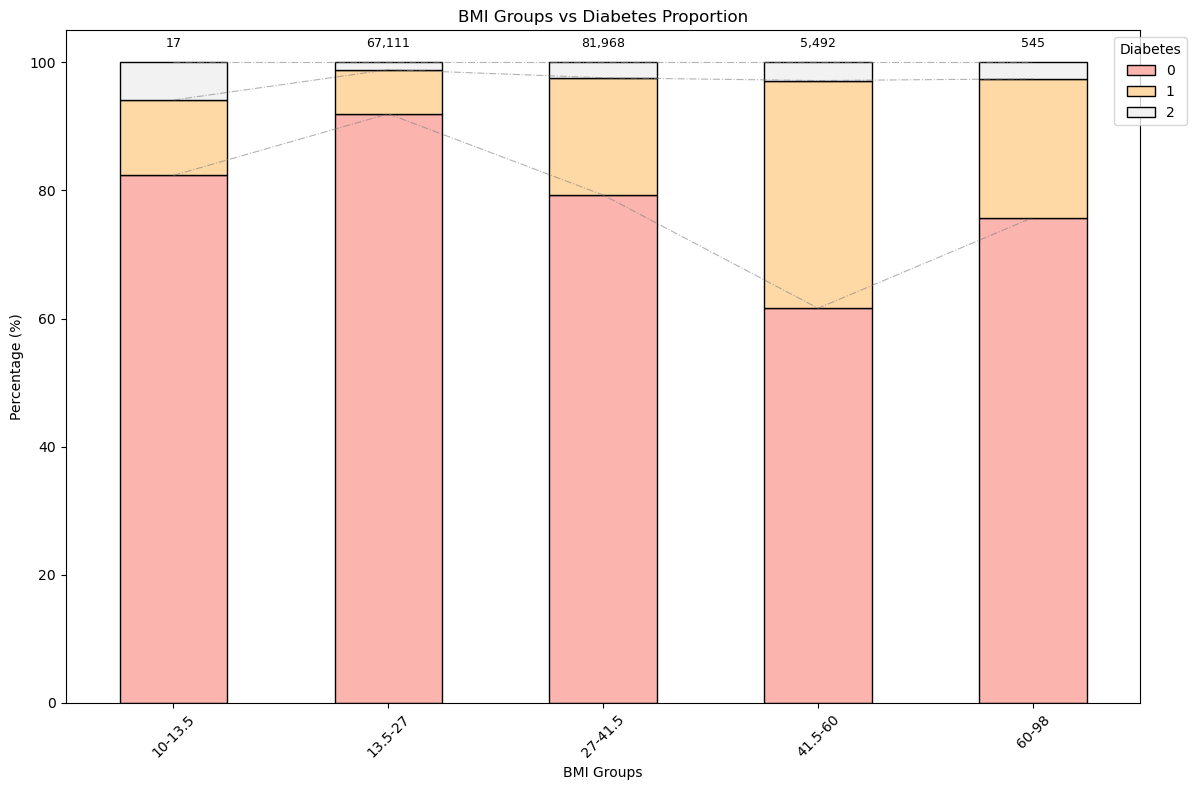

In [20]:
theo_min, theo_max = 10, 60

# === 2. Define bins ===
bins = [theo_min, lower_bound, Median, upper_bound, theo_max, df['BMI'].max()]
labels = ["10-13.5", "13.5-27", "27-41.5", "41.5-60", "60-98"]

bmi_data = df[['BMI','Diabetes']].dropna()
bmi_data['BMI_group'] = pd.cut(bmi_data['BMI'], bins=bins, labels=labels, right=False)

# === 3. Group stats ===
group_stats = (
    bmi_data.groupby('BMI_group')['Diabetes']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0) * 100
)
group_counts = bmi_data['BMI_group'].value_counts().sort_index()

# === 4. Plot ===
fig, ax = plt.subplots(figsize=(12,8))
group_stats.plot(kind='bar', stacked=True, ax=ax, colormap="Pastel1", edgecolor="black")

# Add counts inside the bars (just below the top border)
for i, (group, count) in enumerate(group_counts.items()):
    bar_height = group_stats.loc[group].sum()  # 该柱子的总比例（应为100）
    ax.text(
        i, 
        bar_height + 2,   # 在柱体顶部再往上 2 个单位
        f"{count:,}", 
        ha='center', 
        va='bottom',      # 用 bottom，让文字底部对齐到指定位置
        fontsize=9, 
        color='black'
    )

# === 5. Add trend lines along category boundaries ===
cumsum = group_stats.cumsum(axis=1)

# draw thin lines connecting boundaries between bars
for col in cumsum.columns:
    ax.plot(
        range(len(labels)),
        cumsum[col].values,
        marker=None,
        linestyle='-.',
        linewidth=0.8,
        color='gray',
        alpha=0.6
    )

plt.title("BMI Groups vs Diabetes Proportion")
plt.ylabel("Percentage (%)")
plt.xlabel("BMI Groups")
plt.xticks(rotation=45, ha='center')
plt.legend(title="Diabetes", bbox_to_anchor=(1.05,1))
plt.ylim(0, 105)  # leave margin for text
plt.tight_layout()
plt.show()

In [21]:
bmi_data = df[['BMI','Diabetes']].dropna().copy()
bmi_data['Has_Diabetes'] = bmi_data['Diabetes'].apply(lambda x: 1 if x in [1,2] else 0)
bmi_data['BMI_group'] = pd.cut(bmi_data['BMI'], bins=bins, labels=labels, right=False)

results = []
for group, subset in bmi_data.groupby('BMI_group'):
    no_dm = subset[subset['Has_Diabetes']==0]['BMI']
    dm = subset[subset['Has_Diabetes']==1]['BMI']
    n1, n2 = len(no_dm), len(dm)

    if n1 > 1 and n2 > 1:
        stat, p = mannwhitneyu(no_dm, dm, alternative='two-sided')
        n1n2 = n1 * n2
        mid = n1n2 / 2

        # rank-biserial correlation
        r_rb = (2 * stat) / n1n2 - 1  

        # 判断 U 更接近哪里
        distances = {
            "0": abs(stat - 0),
            "mid": abs(stat - mid),
            "max": abs(stat - n1n2)
        }
        closest = min(distances, key=distances.get)

        results.append([
            group,
            len(subset),
            n1,
            n2,
            no_dm.median(),
            dm.median(),
            f"{stat:.2e}",
            f"{p:.2e}",
            f"{n1n2:.2e}",
            closest,
            f"{r_rb:.3f}"
        ])
    else:
        results.append([
            group,
            len(subset),
            n1,
            n2,
            no_dm.median() if n1>0 else None,
            dm.median() if n2>0 else None,
            None, None, None, None, None
        ])

# 用 tabulate 输出
headers = ["BMI_group", "Total", "NoDM_n", "DM_n", "Median_NoDM", "Median_DM",
           "U_stat", "p_value", "n1·n2", "U更接近", "r_rb"]
print(tabulate(results, headers=headers, tablefmt="grid"))

+-------------+---------+----------+--------+---------------+-------------+--------------+-----------+--------------+-----------+--------+
| BMI_group   |   Total |   NoDM_n |   DM_n |   Median_NoDM |   Median_DM |       U_stat |   p_value |        n1·n2 | U更接近   |   r_rb |
+=============+=========+==========+========+===============+=============+==============+===========+==============+===========+========+
| 10-13.5     |      17 |       14 |      3 |            13 |          13 |    13.5      |  0.265    |    42        | mid       | -0.357 |
+-------------+---------+----------+--------+---------------+-------------+--------------+-----------+--------------+-----------+--------+
| 13.5-27     |   67111 |    61716 |   5395 |            24 |          24 |     1.38e+08 |  7.68e-99 |     3.33e+08 | mid       | -0.171 |
+-------------+---------+----------+--------+---------------+-------------+--------------+-----------+--------------+-----------+--------+
| 27-41.5     |   81968 |    6

具体分析显示，不同 BMI 区间的 Mann-Whitney U 检验结果与流行病学理论一致，即 BMI 越高，糖尿病风险越大。
- 10-13.5 区间样本量极少，且 Mann-Whitney U 检验不显著，尽管该区间表面趋势与总体相反，但样本量不足以提供可靠证据，因此不能据此删除该区间的数据。
- 13.5-27 区间检验显著，提示低至中 BMI 群体糖尿病风险随 BMI 增加而升高。
- 27-41.5 区间差异更加显著，中位数分别为 30 vs 32，进一步验证中高 BMI 与糖尿病风险的正相关。
- 41.5-60 区间样本量较小但检验仍显著，中位数相近，表明高 BMI 群体糖尿病风险的趋势与整体一致，证据不足以支持删除。
- 60-98 区间显示中位数差异明显且 Mann-Whitney U 显著，提示极高 BMI 群体可能存在趋势逆转或异常风险分布，在分析中删除以保证总体趋势的稳健性。

In [22]:
df, X, y = load_preprocess_plot('diabetes_diagnosis_initial_anomaly_handling.csv', numeric_features, categorical_features, do_plot=False)

before_count = df['BMI'].notna().sum()
df.loc[df['BMI'] > 60, 'BMI'] = np.nan
after_count = df['BMI'].notna().sum()

# --- 统计替换数量和比例 ---
replaced_count = before_count - after_count
total_count = len(df)
proportion = replaced_count / total_count * 100

# --- 构造结果表 ---
result = [
    ["BMI", replaced_count, f"{proportion:.2f}%"]
]

print(tabulate(result, headers=["Feature", "Replaced as NaN", "Proportion"], tablefmt="grid"))

# Save cleaned data
output_filename = "diabetes_diagnosis_anomaly_handling.csv"
df.to_csv(output_filename, index=False, encoding="utf-8-sig")

print(f"Data saved as: {os.path.abspath(output_filename)}")

+-----------+-------------------+--------------+
| Feature   |   Replaced as NaN | Proportion   |
+===========+===================+==============+
| BMI       |               503 | 0.21%        |
+-----------+-------------------+--------------+
Data saved as: /Users/guocy/Projects/5310_a1/diabetes/diabetes_diagnosis_anomaly_handling.csv


#### 3.2.4 异常值处理结果检查

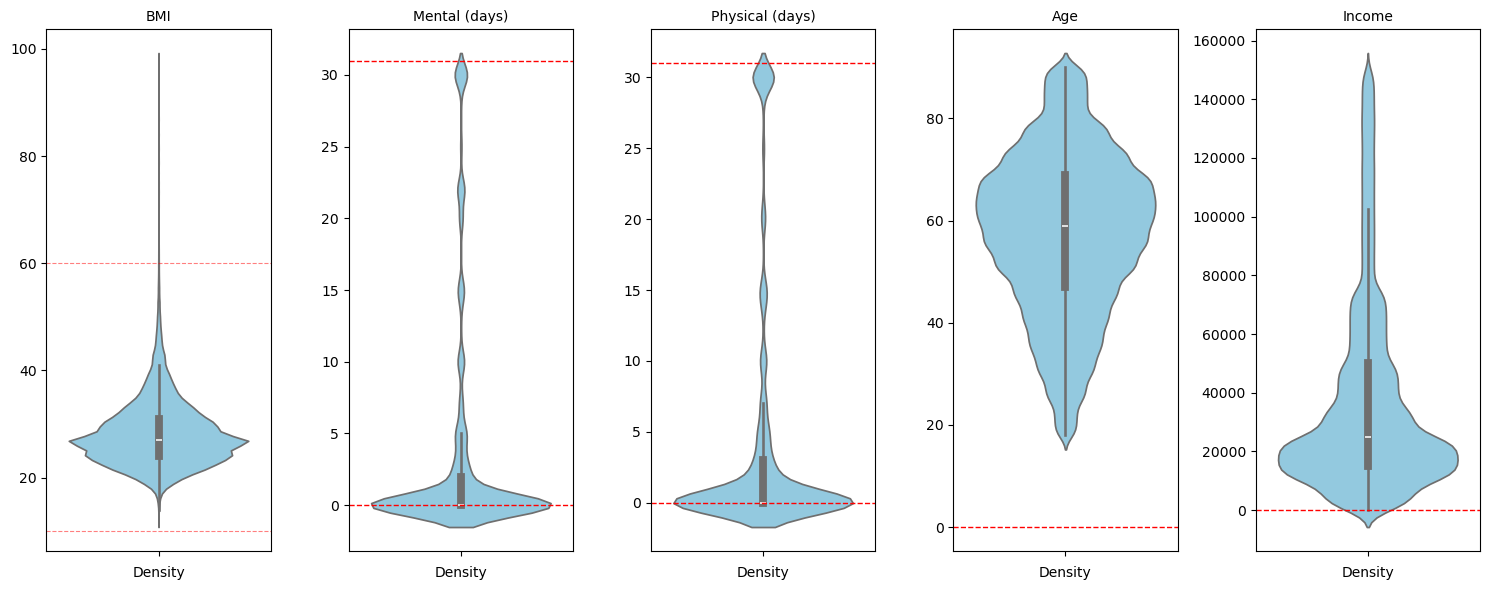

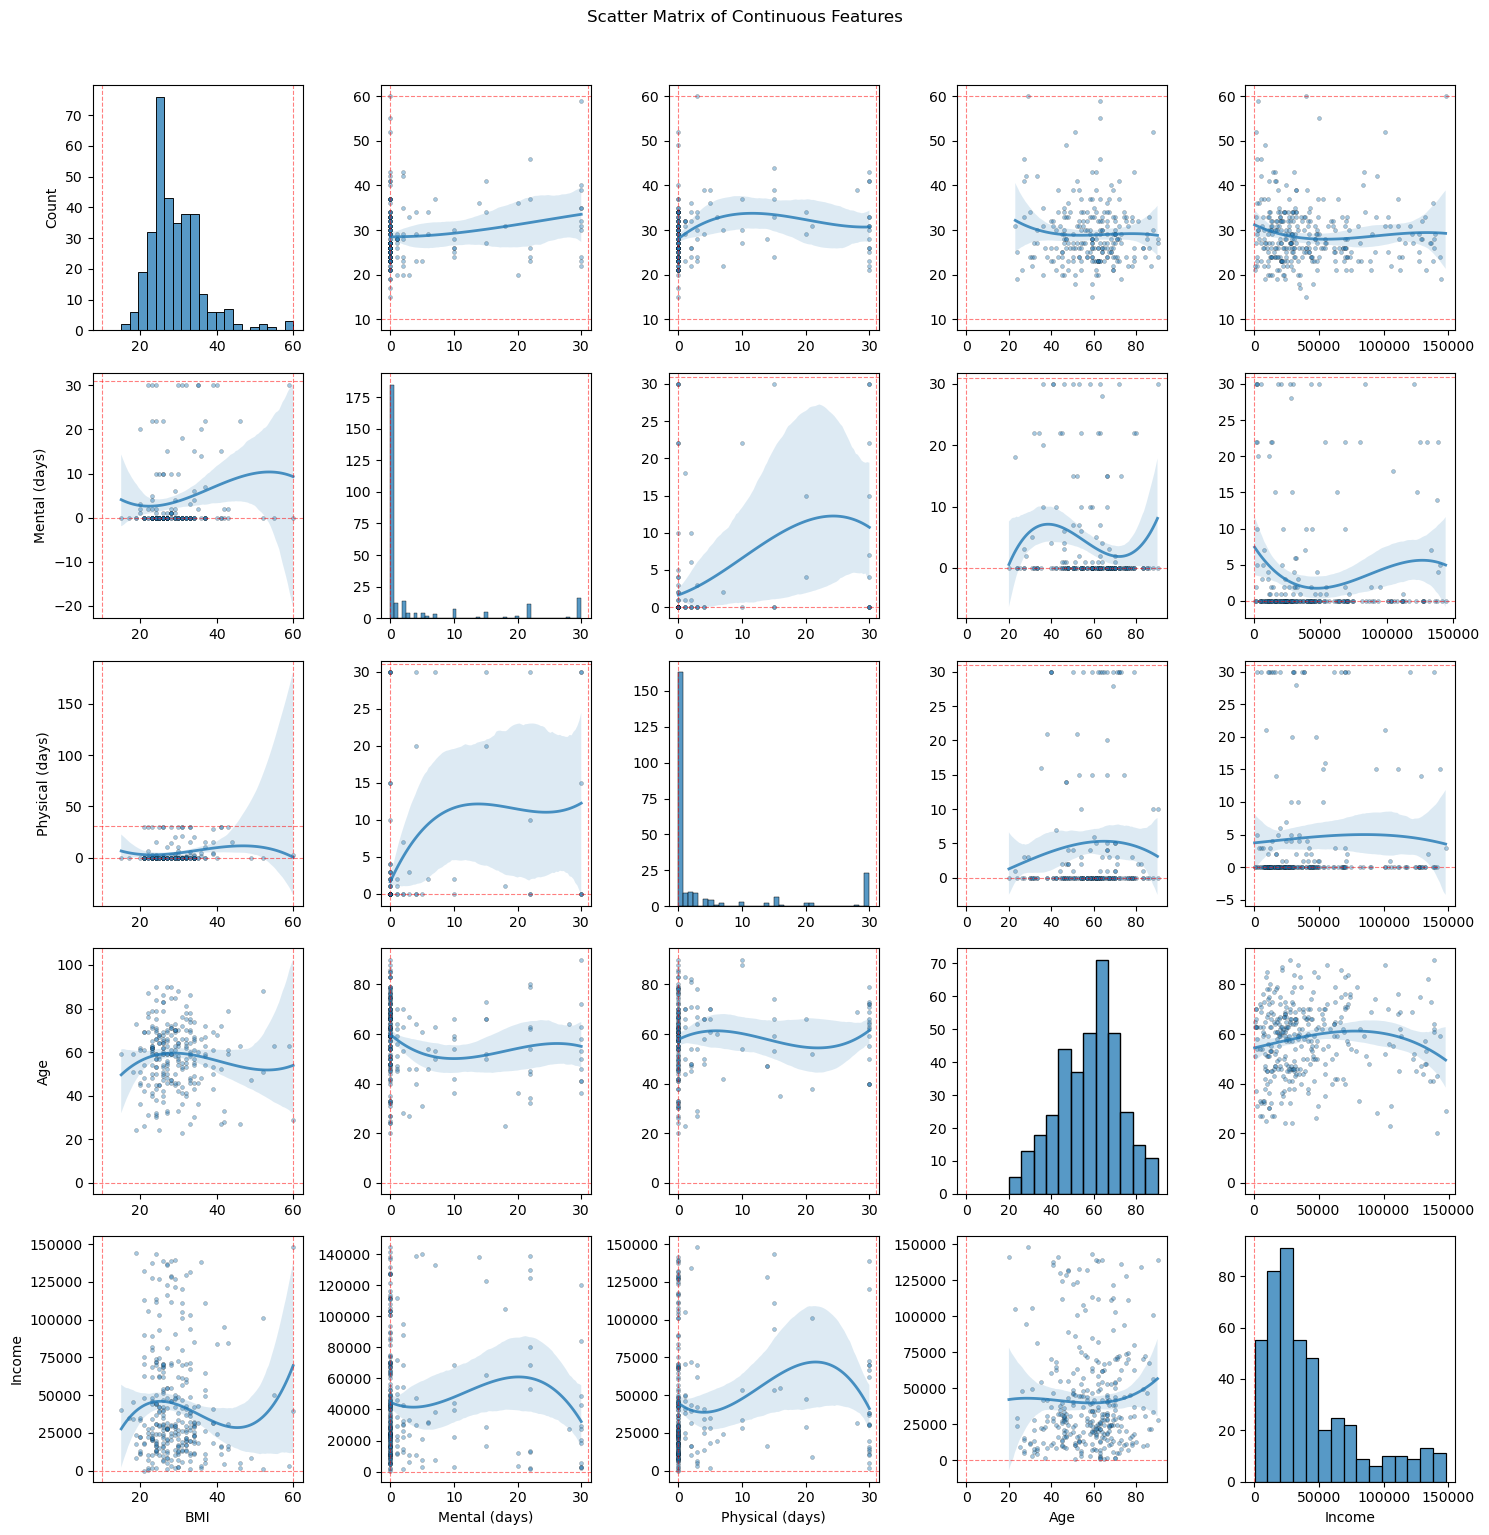

In [23]:
# -------- 1. Violin Plots --------
plt.figure(figsize=(len(numeric_features)*3, 6))
for i, col in enumerate(numeric_features):
    plt.subplot(1, len(numeric_features), i+1)
    sns.violinplot(y=X[col], inner="box", color="skyblue")
    plt.title(col, fontsize=10)
    plt.xlabel("Density")
    plt.ylabel("")

    # Reference lines
    if col.lower() == "bmi":
        plt.axhline(10, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        plt.axhline(60, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
    elif col.lower() in ["mental (days)", "physical (days)"]:
        plt.axhline(0, color="red", linestyle="--", linewidth=1)
        plt.axhline(31, color="red", linestyle="--", linewidth=1)
    elif col.lower() in ["age", "income"]:
        plt.axhline(0, color="red", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


# -------- 2. Scatter Matrix --------
sampled_X = X.sample(min(500, len(X)), random_state=42).reset_index(drop=True)
features = list(numeric_features)
n = len(features)

fig, axes = plt.subplots(n, n, figsize=(max(6, n*3), max(6, n*3)), squeeze=False)
fig.suptitle("Scatter Matrix of Continuous Features", y=1.02)

def add_ref_lines(ax, varname, axis='x'):
    name = varname.lower()
    if axis == 'x':
        if name == "bmi":
            ax.axvline(10, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            ax.axvline(60, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        elif name in ["mental (days)", "physical (days)"]:
            ax.axvline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            ax.axvline(31, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        elif name in ["age", "income"]:
            ax.axvline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
    else:
        if name == "bmi":
            ax.axhline(10, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            ax.axhline(60, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        elif name in ["mental (days)", "physical (days)"]:
            ax.axhline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
            ax.axhline(31, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        elif name in ["age", "income"]:
            ax.axhline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.5)

for i, yvar in enumerate(features):
    for j, xvar in enumerate(features):
        ax = axes[i, j]
        if i == j:
            sns.histplot(sampled_X[xvar].dropna(), bins='auto', edgecolor="black", ax=ax)
            add_ref_lines(ax, xvar, axis='x')
        else:
            sns.regplot(
                data=sampled_X, x=xvar, y=yvar, ax=ax,
                order=3,
                line_kws={"lw": 2, "alpha": 0.8},
                scatter_kws={"s": 8, "alpha": 0.4, "edgecolor": "k", "linewidths": 0.3}
            )
            add_ref_lines(ax, xvar, axis='x')
            add_ref_lines(ax, yvar, axis='y')

        if j > 0:
            ax.set_ylabel("")
        if i < n - 1:
            ax.set_xlabel("")

plt.tight_layout()
plt.show()


在对清洗后的连续型变量构建“散点矩阵”后，可以观察到以下结果：

1. **异常值检查**  
   各特征的小提琴图与散点矩阵中均未见明显极端异常值（outlier）。尤其是 BMI，经 IQR 方法筛查后，高于 60 的样本已被处理为缺失值，图中未再出现异常点，保证了整体分布的合理性。

2. **变量间关系与趋势**  
   二项式拟合避免了线性假设的过度简化，更贴近变量间的潜在非线性关系。与临床常识一致的趋势增强了结果的解释力

### 3.3 缺失值处理

In [24]:
df, X, y = load_preprocess_plot('diabetes_diagnosis_anomaly_handling.csv', numeric_features, categorical_features, do_plot=False)

#### 3.3.1 缺失模式判定

由于数据缺失比较严重，所以我们要进行缺失模式的判断，以决定后续的缺失值处理策略。选择下面几个方面进行判断是为了**从直观、建模、依赖性和统计显著性多角度验证缺失机制**，确保对缺失类型的判断科学可靠：

- **直观可视方法**：通过缺失矩阵可视化可观察缺失值在样本和特征维度上是否随机分布，若未出现成块聚集或规律性则支持MCAR。这一方法直观、快速，可初步排除明显的结构性缺失。

- **建模检验法**：通过回归法检测时以缺失指示变量为因变量做线性回归，若模型R²接近0且MSE接近基准误差则说明缺失与其他特征无关，符合MCAR。此方法量化了缺失与其他变量的线性关系，提供统计依据。

- **缺失间依赖性检验**：通过缺失模式相关性矩阵计算特征间缺失的相关性，若矩阵接近对角阵且无显著相关性则表明缺失事件独立，符合MCAR。这可以判断不同特征缺失是否相互依赖，进一步支持MCAR假设。

- **统计显著性检验**：通过Little’s MCAR test，对整体缺失模式进行假设检验。若 P 值 > 0.05，则无法拒绝 MCAR 假设，表明缺失可能是完全随机的。这提供了正式的统计显著性证据。

##### 3.3.1.1 缺失矩阵

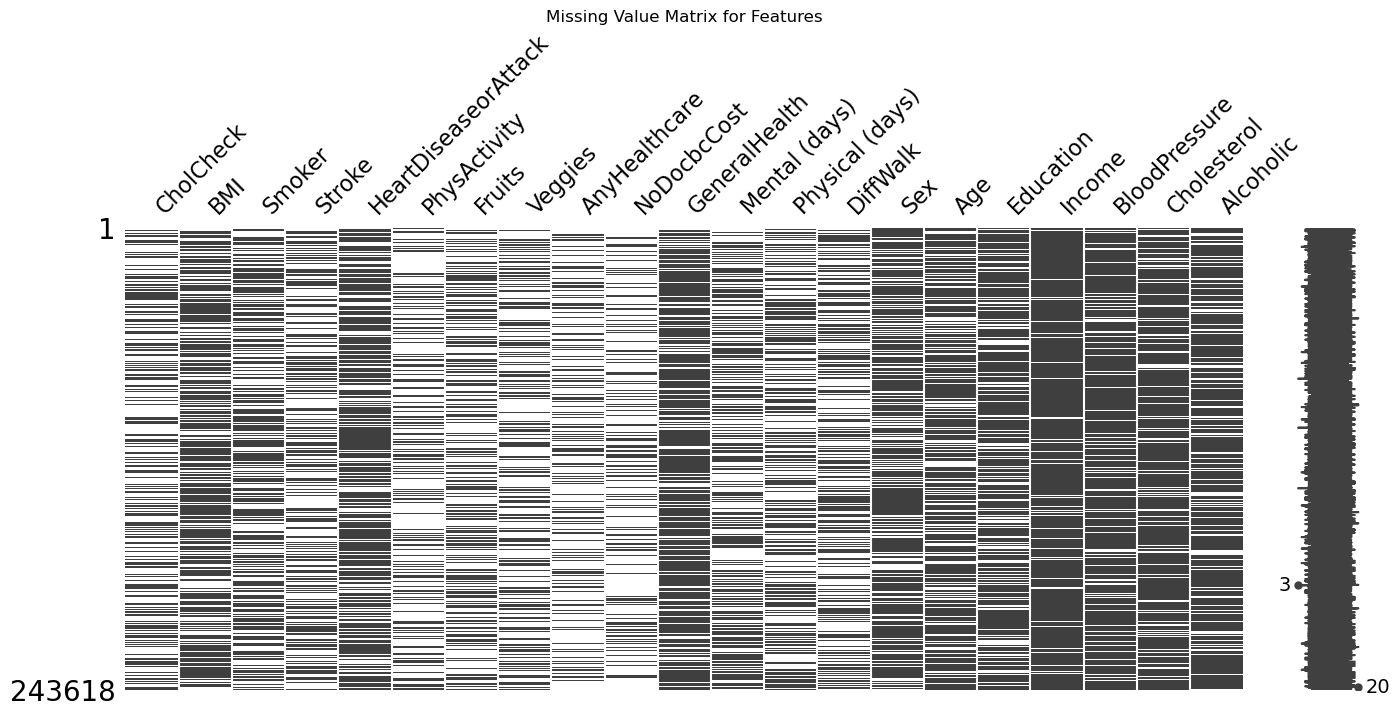

In [25]:
# 对特征集 X 进行缺失矩阵可视化，观察缺失值的分布和聚集情况
msno.matrix(X, figsize=(16, 6), sparkline=True)
plt.title("Missing Value Matrix for Features")
plt.show()

##### 3.3.1.2 回归法检测

+----------------------+--------------+-----------+----------------+-------------+
|       Variable       |      R²      |    MSE    |  Baseline_MSE  |  MSE_Diff   |
+======================+==============+===========+================+=============+
|         Age          | -5.63174e-05 | 0.200204  |    0.200193    | 1.12743e-05 |
+----------------------+--------------+-----------+----------------+-------------+
|         Sex          | -5.86632e-05 | 0.193145  |    0.193134    | 1.13299e-05 |
+----------------------+--------------+-----------+----------------+-------------+
|        Fruits        | -6.06095e-05 |  0.2378   |    0.237785    | 1.4412e-05  |
+----------------------+--------------+-----------+----------------+-------------+
|    GeneralHealth     | -7.87771e-05 |  0.19353  |    0.193515    | 1.52446e-05 |
+----------------------+--------------+-----------+----------------+-------------+
|     NoDocbcCost      | -8.76845e-05 | 0.187701  |    0.187685    | 1.6457e-05  |
+---

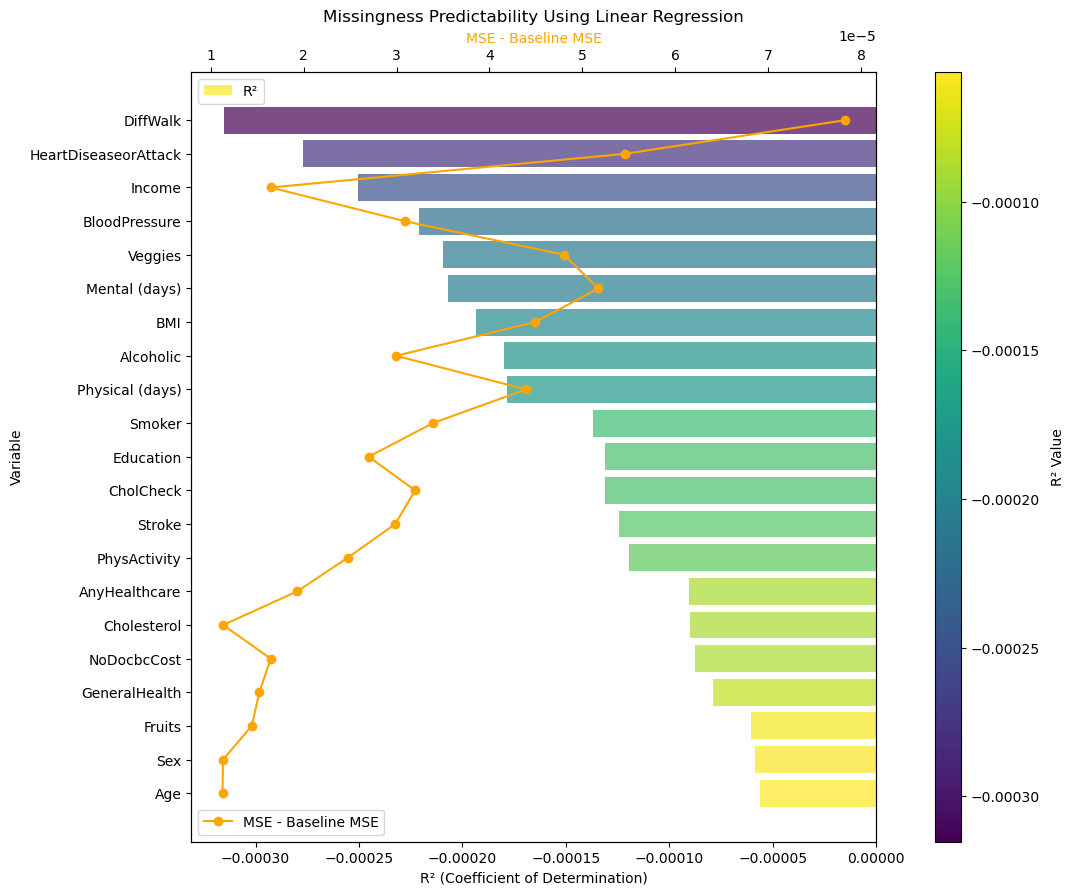

In [26]:
# 1. 构建缺失指示变量
def create_missing_indicators(X):
    return X.isnull().astype(int)

# 2. 线性回归检测缺失模式可预测性
def handle_missingness_with_linear_regression(X):
    missing_indicator = create_missing_indicators(X)
    predictability_scores = []

    for col in X.columns:
        indicator = missing_indicator[col]
        other_vars = X.drop(columns=[col]).copy()

        # One-Hot 编码
        if other_vars.select_dtypes(include=['object']).shape[1] > 0:
            other_vars = pd.get_dummies(other_vars, drop_first=True)

        # 填补缺失
        other_vars = other_vars.fillna(other_vars.mean())

        X_train, X_test, y_train, y_test = train_test_split(
            other_vars, indicator, test_size=0.2, random_state=0
        )

        # 模型训练
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # 模型误差
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # 基准误差：预测均值
        baseline_pred = np.full_like(y_test, y_test.mean(), dtype=float)
        baseline_mse = mean_squared_error(y_test, baseline_pred)

        predictability_scores.append((col, r2, mse, baseline_mse))

    return pd.DataFrame(predictability_scores, columns=['Variable', 'R²', 'MSE', 'Baseline_MSE'])

# 3. 计算结果
predictability_df = handle_missingness_with_linear_regression(X)
predictability_df = predictability_df.sort_values(by='R²', ascending=False)
predictability_df['MSE_Diff'] = predictability_df['MSE'] - predictability_df['Baseline_MSE']

print(tabulate(predictability_df, headers='keys', tablefmt='grid', showindex=False, stralign='center', numalign='center'))

# 4. 可视化
fig, ax1 = plt.subplots(figsize=(10, 10))

# R² 渐变色柱状图
norm = plt.Normalize(vmin=predictability_df['R²'].min(), vmax=predictability_df['R²'].max())
cmap = plt.get_cmap('viridis')
bars = ax1.barh(
    predictability_df['Variable'],
    predictability_df['R²'],
    color=cmap(norm(predictability_df['R²'])),
    label='R²',
    alpha=0.7
)
ax1.set_xlabel('R² (Coefficient of Determination)')
ax1.set_ylabel('Variable')
ax1.set_title('Missingness Predictability Using Linear Regression')

# 第二个轴：MSE - Baseline MSE
ax2 = ax1.twiny()
ax2.plot(
    predictability_df['MSE_Diff'],
    predictability_df['Variable'],
    color='orange',
    marker='o',
    label='MSE - Baseline MSE'
)
ax2.set_xlabel('MSE - Baseline MSE', color='orange')

# 这里改名为 scalar_mapper，避免和 statsmodels 冲突
scalar_mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
scalar_mapper.set_array([])
cbar = fig.colorbar(
    scalar_mapper,
    ax=[ax1, ax2],
    location='right',
    pad=0.02,
    fraction=0.04,
    aspect=30
)
cbar.set_label('R² Value', labelpad=8)

# 图例
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()

##### 3.3.1.3 相关性矩阵

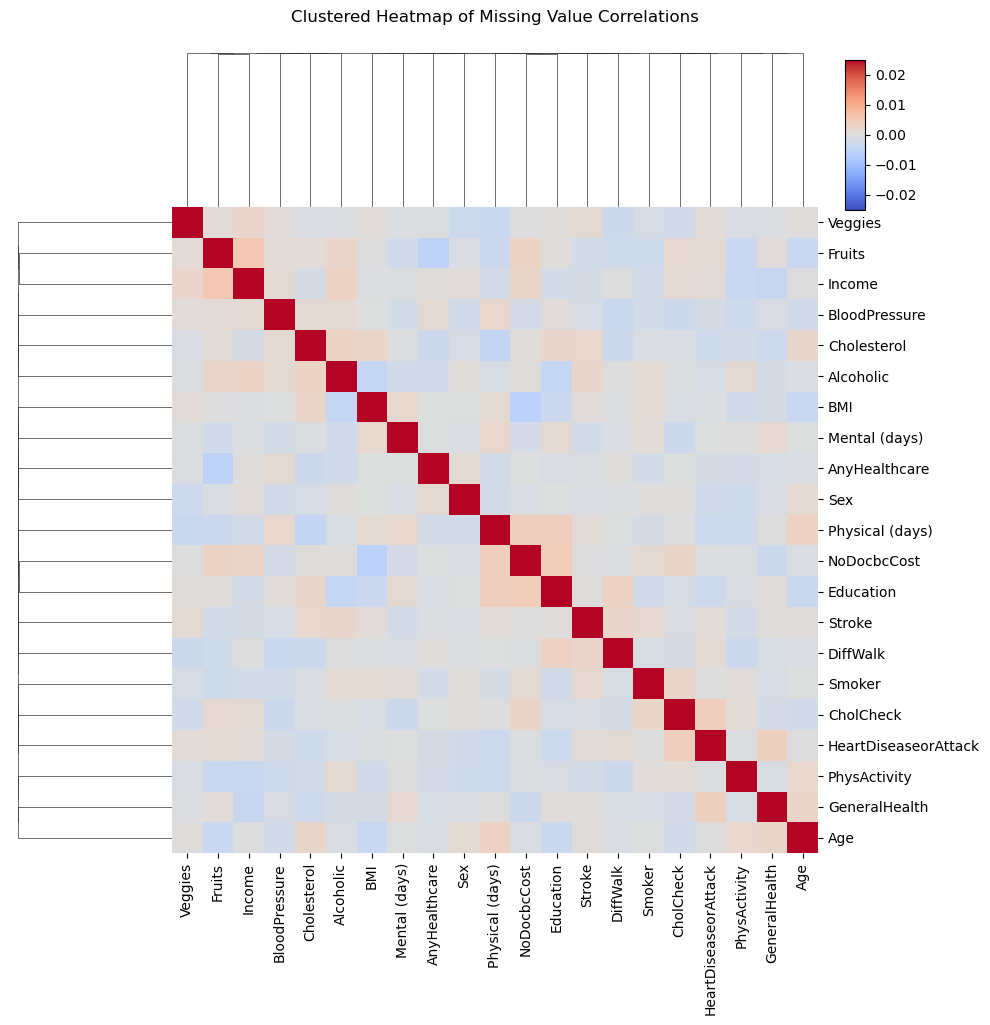

In [27]:
# 生成缺失矩阵 (1=缺失, 0=非缺失)
missing_matrix = X.isnull().astype(int)

# 计算缺失模式的相关性矩阵
corr_matrix = missing_matrix.corr()

# 选择相关性显示的范围
vmin = -0.025
vmax = 0.025

# 建立主图
g = sns.clustermap(
    corr_matrix,
    method="average",
    metric="euclidean",
    cmap="coolwarm",
    vmin=vmin, vmax=vmax,
    figsize=(10, 10),
    cbar_pos=None  # 去掉默认色条
)

# 在右上角新建一个 axes
cax = g.fig.add_axes([0.85, 0.82, 0.02, 0.15])  
# 参数依次是 [left, bottom, width, height]，可调节位置和大小

# 添加色条（避免覆盖 sm）
scalar_map = plt.cm.ScalarMappable(
    cmap="coolwarm", norm=plt.Normalize(vmin=vmin, vmax=vmax)
)
g.fig.colorbar(scalar_map, cax=cax)

plt.suptitle("Clustered Heatmap of Missing Value Correlations", y=1.02)
plt.show()


##### 3.3.1.4 Little's MCAR Test Result

In [28]:
def little_mcar_test(data, alpha=0.05):
    # 计算缺失值的模式矩阵
    missing_matrix = data.isnull().astype(int)

    # 计算每对变量的相关性矩阵
    corr_matrix = missing_matrix.corr()

    # 计算差异矩阵
    diff_matrix = corr_matrix - np.mean(corr_matrix.values)

    # 计算统计量
    chi2_stat = np.sum(diff_matrix.values ** 2)

    # 计算自由度
    dfree = data.shape[1] * (data.shape[1] - 1) / 2

    # 计算 p 值
    p_value = 1 - chi2_dist.cdf(chi2_stat, dfree)  # 注意使用 chi2_dist

    return chi2_stat, dfree, p_value

chi2_stat, dfree, p_value = little_mcar_test(X)

print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"Degrees of Freedom: {dfree}")
print(f"P-Value: {p_value:.4f}")

# 分析
if p_value > 0.05:
    print("P > 0.05, 无法拒绝 MCAR 假设，数据可能为 MCAR")
else:
    print("P <= 0.05, 拒绝 MCAR 假设，数据可能不是 MCAR")

Chi-Square Statistic: 20.0168
Degrees of Freedom: 210.0
P-Value: 1.0000
P > 0.05, 无法拒绝 MCAR 假设，数据可能为 MCAR


#### 3.3.2 缺失值处理方案制定

**缺失率划分经验参数**

- **缺失率 < 20%**：直接均值/中位数插补，不删除。  
- **缺失率 20%-50%**：采用 MICE 插补。   
- **缺失率 > 50%**：结合预测价值判断，若特征重要则用 MICE，否则删除。  

对MCAR数据的缺失值处理主要有如下几种方法：

1. **Complete-case analysis（删除样本）**  
   - 对 MCAR 无偏，但由于大部分特征缺失率 >30%，会丢弃大量样本，导致有效样本量显著下降，方差增大，不适合当前数据集。

2. **删除缺失率过高的特征**  
   - 可减少噪声引入，但会丢失部分信息。需要深入研究标准。

3. **Mean/Median Imputation（均值/中位数填充）**  
   - 对数值型特征适用，可在保证 MCAR 假设下填补缺失值  
   - 简单快速，但会低估方差，削弱变量间相关性  
   - 对缺失率较高（>40%）的特征填补可能产生较大偏差

4. **MICE（多重插补）**  
   - 可保留方差和变量间关系，适合 MCAR  
   - 迭代插补时需注意收敛和缺失率对稳定性的影响  
   - 当前由于限制不使用线性回归外的预测方法，可选择使用基于现有特征的线性迭代插补

考虑到本数据集中缺失值数量较多，若仅依赖单一且简单的缺失值处理方法，将不可避免地导致有效样本量的显著下降和估计方差的异常波动。因此，我们不采用单一策略，而是结合多种方法，形成分层的综合处理方案：

   - **第一步**：由于大部份特征的缺失率都超过50%，全部删除会损失过多的信息，因此我们适当放宽对缺失率的容忍。的对缺失率>50%的特征，结合预测价值、缺失率、变量重要性等各方面进行综合评估，决定是否保留并使用 MICE。 
   - **第二步**：对缺失率 **5%–30%** 的特征，系统采用 MICE 进行插补，保证信息最大化利用。   
   - **第三步**：对缺失率低于 **5%** 的特征，直接采用均值或中位数插补，不做删除。   

这一过程的核心在于制定特征删除标准，其本质是 **Missing–Information Tradeoff**：即在缺失率与特征预测力之间寻求平衡。

**Missing–Information Tradeoff 框架**
- **高信息量 + 高缺失率**  
特征对目标变量具有较强解释力，但缺失严重 → 可暂保留，建模阶段再评估。  
- **低信息量 + 高缺失率**  
特征贡献有限且缺失严重 → 直接删除以减少噪声。  
- **低信息量 + 低缺失率**  
特征稳定但预测价值有限 → 视具体建模需求决定。  
- **高信息量 + 低缺失率**  
理想特征，应优先保留。  

#### 3.3.3 特征缺失率分层

In [29]:
def categorize_features_by_missingness(X: pd.DataFrame):
    # 计算缺失率
    missing_ratio = X.isnull().mean()

    # 分类
    high_missing = missing_ratio[missing_ratio > 0.50].index.tolist()
    medium_missing = missing_ratio[(missing_ratio >= 0.20) & (missing_ratio <= 0.50)].index.tolist()
    low_missing = missing_ratio[missing_ratio < 0.20].index.tolist()

    return {
        "high_missing(>50%)": high_missing,
        "medium_missing(20%-50%)": medium_missing,
        "low_missing(<20%)": low_missing
    }

In [30]:
categorized_missingness = categorize_features_by_missingness(X)
print(tabulate(categorized_missingness, headers='keys', tablefmt='grid', showindex=False, stralign='center', numalign='center'))

+----------------------+---------------------------+---------------------+
|  high_missing(>50%)  |  medium_missing(20%-50%)  |  low_missing(<20%)  |
+======================+===========================+=====================+
|      CholCheck       |            BMI            |       Income        |
+----------------------+---------------------------+---------------------+
|        Stroke        |          Smoker           |    BloodPressure    |
+----------------------+---------------------------+---------------------+
|     PhysActivity     |   HeartDiseaseorAttack    |     Cholesterol     |
+----------------------+---------------------------+---------------------+
|        Fruits        |       GeneralHealth       |                     |
+----------------------+---------------------------+---------------------+
|       Veggies        |            Sex            |                     |
+----------------------+---------------------------+---------------------+
|    AnyHealthcare     | 

#### 3.3.4 高缺失特征评估方法

##### 3.3.4.1 预测力量化方法

在三分类任务 ($Y\in\{1,2,3\}$) 中，我们定义特征的预测能力为 **分类效能 (Classification Effectiveness, CE)**，即特征在解释或减少目标变量不确定性方面的有效程度。根据特征类型，CE 可通过以下两类统计量严格量化：

**(1) 连续型特征：ANOVA η²**

$$
\eta^2 \;=\; \frac{\mathrm{SS}_{\text{between}}}{\mathrm{SS}_{\text{total}}},
$$

其中  
$$
\mathrm{SS}_{\text{between}}=\sum_{k=1}^3 n_k(\bar{x}_k-\bar{x})^2, 
\quad
\mathrm{SS}_{\text{total}}=\sum_{i=1}^n (x_i-\bar{x})^2.
$$  

- $\eta^2$ 衡量组间均值差异在总体方差中所占比例。  
- 若 $\eta^2$ 较大，说明不同类别的 $X$ 分布均值显著分离，从而观测 $X$ 能减少对 $Y$ 的不确定性。  
- 在概率模型框架下，组间均值差异与类别条件密度的可分性单调相关，因此 $\eta^2$ 与信息增益呈单调关系，可视为连续型特征预测力的合理替代度量。

**(2) 离散型特征：Cramér’s V**

$$
V \;=\; \sqrt{\frac{\chi^2/n}{\min(r-1,k-1)}},
\qquad
\chi^2=\sum_{i=1}^r\sum_{j=1}^k\frac{(O_{ij}-E_{ij})^2}{E_{ij}},
$$

其中 $r$ 为特征 $X$ 的类别数，$k=3$ 为目标 $Y$ 的类别数。

- $V\in[0,1]$ 是基于卡方统计的无量纲关联强度，衡量 $X$ 与 $Y$ 的偏离独立程度。  
- 若 $V$ 较大，表示 $X$ 在不同 $Y$ 类别下的分布差异显著，因此 $X$ 的观测能有效降低 $Y$ 的不确定性。  
- 数学上，$\chi^2/n$ 在接近独立时可视为互信息（或 KL 散度）的线性近似，因此 $V$ 与信息论度量在依赖性检验中保持一致性，可作为离散型特征预测力的替代指标。

##### 3.3.4.3 信息保留量化方法

- 每个观测 $i$ 在特征 $j$ 上对目标的贡献信息量记为 $I_{ij}$。  
- 特征 $j$ 的平均信息量（无缺失）定义为分类效能 CE：

$$
\mathrm{CE}_j \;=\; \frac{1}{n}\sum_{i=1}^{n} I_{ij}.
$$

设缺失指示 $M_{ij}\in\{0,1\}$（1 表示缺失）。在 MCAR 假设下，缺失观测视为不提供信息：

$$
I_{ij}^{\mathrm{effective}} \;=\; I_{ij}\,(1 - M_{ij}).
$$

因此特征 \(j\) 的总体**有效分类效能**为：

$$
\mathrm{EffCE}_j \;=\; \frac{1}{n}\sum_{i=1}^{n} I_{ij}(1 - M_{ij})
\;=\; \mathrm{CE}_j \cdot (1 - MR_j),
$$

其中 $\displaystyle MR_j=\frac{1}{n}\sum_{i=1}^n M_{ij}$ 为缺失率。

有效观测数为

$$
n_{\mathrm{obs},j} \;=\; n\cdot(1 - MR_j).
$$

估计一个特征真实效用时的**估计不确定性**（方差）与有效样本量成反比。为在决策中反映“样本量不足导致的可靠性下降”，采用与有效样本量成比例的惩罚因子：
$$
\text{ReliabilityFactor}_j \propto \frac{n_{\mathrm{obs},j}}{n} \;=\; (1 - MR_j).
$$ 

将有效信息量与可靠性因子相乘，得到最终用于特征筛选的量化指标 **信息保留指数（IRI）**：

$$
\mathrm{IRI}_j \;=\; \mathrm{EffCE}_j \cdot \frac{n_{\mathrm{obs},j}}{n}.
$$

代入 $\mathrm{EffCE}_j$ 与 $n_{\mathrm{obs},j}$ 的表达式，得到简洁形式：

$$
\mathrm{IRI}_j \;=\; \mathrm{CE}_j \cdot (1 - MR_j)\cdot (1 - MR_j)
\;=\; \mathrm{CE}_j \cdot (1 - MR_j)^2.
$$

- 第一项 $(1-MR_j)$ 已把可用信息按观测比例缩减；  
- 第二项以 $\frac{n_{\mathrm{obs}}}{n}$ 形式引入对估计可信度的线性惩罚，反映有效样本减少会降低估计稳定性与可推广性。

##### 3.3.4.3 特征删除标准的阈值

为实现 Missing–Information Tradeoff，在特征删除决策中，需要同时考虑特征的预测信息量与缺失率。对连续型特征使用 η²，离散型特征使用 Cramér’s V，两者均归一化到 [0,1]，在 IRI 指标中统一度量：

$$
\mathrm{IRI}_j = \mathrm{CE}_j \cdot (1 - MR_j)^2
$$

- $CE_j$：连续型特征为 η²，离散型特征为 Cramér’s V  
- $MR_j$：特征 j 的缺失率  
- $IRI_j$ ∈ [0,1]，值越大说明特征信息量高且缺失率低，价值越大

阈值分层策略：
| 阈值范围 | 动作 | 说明 |
|-----------|------|------|
| $IRI_j ≥ 0.1$ | Keep | 信息量高且缺失率可控，优先保留 |
| $0.02 ≤ IRI_j < 0.1$ | Review | 信息量有限或缺失率较高，需人工/策略判断 |
| $IRI_j < 0.02$ | Remove | 信息量低且缺失率高，直接删除以减少噪声 |

#### 3.3.5 高缺失特征评估与处理

In [31]:
# ---------------------- CE 计算 ----------------------
def anova_eta_squared(x, y):
    df = pd.DataFrame({'x': x, 'y': y}).dropna()
    if df['x'].nunique() <= 1 or df['y'].nunique() <= 1:
        return 0.0
    model = smf.ols('x ~ C(y)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    ss_between = anova_table['sum_sq']['C(y)']
    ss_total = anova_table['sum_sq'].sum()
    return ss_between / ss_total if ss_total > 0 else 0.0


def cramers_v(x, y):
    df = pd.DataFrame({'x': x, 'y': y}).dropna()
    if df['x'].nunique() <= 1 or df['y'].nunique() <= 1:
        return 0.0
    confusion_matrix = pd.crosstab(df['x'], df['y'])
    chi2 = stats.chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


# ---------------------- IRI 计算 ----------------------
def compute_feature_metrics(X: pd.DataFrame, y: pd.Series, feature_types: dict):
    results = []

    # 保证 y 是分类
    if not pd.api.types.is_categorical_dtype(y):
        y = pd.Categorical(y)

    for col in X.columns:
        x = X[col]
        mr = x.isna().mean()  # 缺失率

        if feature_types[col] == 'numeric':
            ce = anova_eta_squared(x, y)
        else:
            ce = cramers_v(x.astype(str), y.astype(str))

        iri = ce * (1 - mr) ** 2

        if iri >= 0.1:
            decision = "Keep"
        elif iri >= 0.02:
            decision = "Review"
        else:
            decision = "Remove"

        results.append({
            "Feature": col,
            "Type": feature_types[col],
            "CE": ce,
            "MR": mr,
            "IRI": iri,
            "Decision": decision
        })

    return pd.DataFrame(results).sort_values(by="IRI", ascending=False)

In [32]:
high_missing_features = categorized_missingness["high_missing(>50%)"]
X_high = X[high_missing_features]
high_missing_metrics = compute_feature_metrics(X_high, y, feature_types)
print(tabulate(high_missing_metrics, headers='keys', tablefmt='grid', showindex=False, stralign='center', numalign='center'))

+-----------------+-------------+------------+----------+-------------+------------+
|     Feature     |    Type     |     CE     |    MR    |     IRI     |  Decision  |
+=================+=============+============+==========+=============+============+
|    DiffWalk     | categorical |  0.104729  | 0.540284 |  0.0221332  |   Review   |
+-----------------+-------------+------------+----------+-------------+------------+
|     Stroke      | categorical | 0.0443657  | 0.599681 | 0.00710985  |   Remove   |
+-----------------+-------------+------------+----------+-------------+------------+
| Physical (days) |   numeric   | 0.0319669  | 0.563066 | 0.00610284  |   Remove   |
+-----------------+-------------+------------+----------+-------------+------------+
|    CholCheck    | categorical | 0.0321319  | 0.570418 | 0.00592965  |   Remove   |
+-----------------+-------------+------------+----------+-------------+------------+
|  PhysActivity   | categorical | 0.0447304  | 0.709578 | 0.00377

数据驱动的特征筛选与流行病学理论可能存在不一致，这并非模型错误，而是：
- 数据质量与分布限制了效应检测；
- 方法本身只捕捉直接贡献，忽略了间接效应；
- 理论提供了因果通路的“补充视角”。

因此，**在特征剔除前，必须结合理论背景进行验证**：以统计指标作为参考，结合变量在理论上的相关性，以保证模型的稳健性与医学可解释性。我们按照如下方面进行综合评估：

- **因果角色**：上游危险因素（cause）/ 并发症或下游后果（effect/mediator）/ 医疗行为与可及性（utilization/SES，易做碰撞因子collider）。  
- **相关方式**：直接（生物学或行为机制明确）/ 间接（通过肥胖、胰岛素抵抗、慢病管理路径）/ 反向（主要为糖尿病后果）。  
- **信息含量**：连续 > 有序分级 > 二值；同一构念优先保留信息更丰富者。  
- **缺失处理提示**：缺失率 **20%–50% → MICE**；**>50% → 结合预测价值审阅**；**<20% → 简单插补可接受**。  
- **建模定位**：预测因子（predictor）/ 混杂控制（confounder）/ 仅描述或剔除（drop）。

| 变量 | 因果角色 | 相关方式 | 类型与信息量 | 理论强度 | 建议 |
|---|---|---|---|---|---|
| **DiffWalk（行走困难）** | 下游并发症（神经病变、外周血管病变） | **反向/间接** | 多为二值或粗分级，信息量中等-低 | **中等偏强**（并发症信号） | **保留** |
| **Stroke（卒中史）** | 共病/下游后果（糖尿病升高卒中风险） | 间接 | 二值，信息量低 | 中等 | **保留** |
| **CholCheck（是否做过血脂检查）** | 医疗行为/利用 | 间接，**易为碰撞因子** | 二值，信息量低 | 弱-中 | **剔除** |
| **Physical (days)（体力活动天数）** | 上游生活方式危险因素 | **直接**（改善胰岛素敏感性） | **连续**，信息量高 | **中等** | **保留** |
| **PhysActivity（是否有体力活动）** | 上游生活方式危险因素 | 直接 | 二值，信息量低 | 中等 | **备选** |
| **Veggies（蔬菜摄入）** | 上游饮食因素 | 直接/间接 | 常为二值或粗分级 | 中等 | **备选** |
| **Fruits（水果摄入）** | 上游饮食因素 | 直接/间接 | 常为二值或粗分级 | 中等 | **备选** |
| **NoDocbcCost（因费用无法就医）** | SES/医疗可及性 | 间接，**潜在碰撞因子** | 二值 | 弱-中 | **剔除** |
| **AnyHealthcare（是否有医保）** | SES/保障 | 间接，**潜在碰撞因子** | 二值 | 弱 | **剔除** |

在综合统计结果与理论预期的双重考量下，本次特征筛选的最终结果如下：

**剔除特征**
- **CholCheck**（是否检查胆固醇）  
  - **原因**：几乎为所有人群的常规健康检查内容，缺乏区分度；在数据集中表现为信息量极低，对糖尿病风险预测的边际贡献有限。
- **NoDocbcCost**（因经济原因未能就医）  
  - **原因**：主要反映医疗可及性，虽可能影响糖尿病的长期管理，但与糖尿病发病的直接因果关系较弱，预测价值有限。
- **AnyHealthcare**（是否有任何医疗保障）  
  - **原因**：同样更多反映社会经济和保障因素，与糖尿病发病风险的直接机制关联度低，在数据中表现出极低的信息贡献。

**保留特征**
- **DiffWalk**（步行困难）  
  - **因果逻辑**：运动能力下降与糖尿病相关并可能反映糖尿病并发症（如神经病变、血管病变），因此保留。  
- **Stroke**（是否中风）  
  - **因果逻辑**：中风与糖尿病均与动脉粥样硬化、代谢紊乱高度相关，中风史可作为糖尿病风险的间接指标。  
- **Physical (days)**（体力活动天数）  
  - **因果逻辑**：生活方式相关因素与糖尿病关系明确，运动不足是已知危险因素，因此保留。  

**备选保留特征**
- **PhysActivity**（是否有体力活动）  
  - 与 Physical (days) 在信息上存在重叠，但二值化变量可提供简化的行为模式表征，适合作为补充特征。  
- **Veggies**（蔬菜摄入）  
  - 膳食结构与糖尿病风险密切相关，虽在本数据集中未表现出强信息量，但从理论上应予以保留。  
- **Fruits**（水果摄入）  
  - 同样属于生活方式变量，反映营养摄入情况，保留可为后续模型提供潜在的补充信息。  

**策略说明**
考虑到后续模型预测任务的目标是最大限度地捕捉与糖尿病相关的多维信号，本次特征筛选在严格剔除信息量极低且无明显因果逻辑支撑的变量后，对于存在理论支撑但统计贡献有限的变量（如膳食、体力活动二值变量），仍予以“备选保留”。这类特征可在后续建模过程中进一步通过正则化或特征重要性评估进行动态调整，而不应在初始阶段过早丢弃。

**最终保留集：**
- **必留**：DiffWalk、Stroke、Physical (days)  
- **备选保留**：PhysActivity、Veggies、Fruits  
- **剔除**：CholCheck、NoDocbcCost、AnyHealthcare



In [52]:
df, X, y = load_preprocess_plot('diabetes_diagnosis_anomaly_handling.csv', numeric_features, categorical_features, do_plot=False)

df = df.drop(columns=["CholCheck", "NoDocbcCost", "AnyHealthcare"])

print(df.columns)

# Save cleaned data
output_filename = "diabetes_diagnosis_drop.csv"
df.to_csv(output_filename, index=False, encoding="utf-8-sig")

print(f"Data saved as: {os.path.abspath(output_filename)}")

Index(['BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity',
       'Fruits', 'Veggies', 'GeneralHealth', 'Mental (days)',
       'Physical (days)', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Diabetes', 'BloodPressure', 'Cholesterol', 'Alcoholic'],
      dtype='object')
Data saved as: /Users/guocy/Projects/5310_a1/diabetes/diabetes_diagnosis_drop.csv


#### 3.3.6 多重插补

=== 数据集基本信息 ===
维度: (243618, 19)
=== 连续特征分布（小提琴图） ===


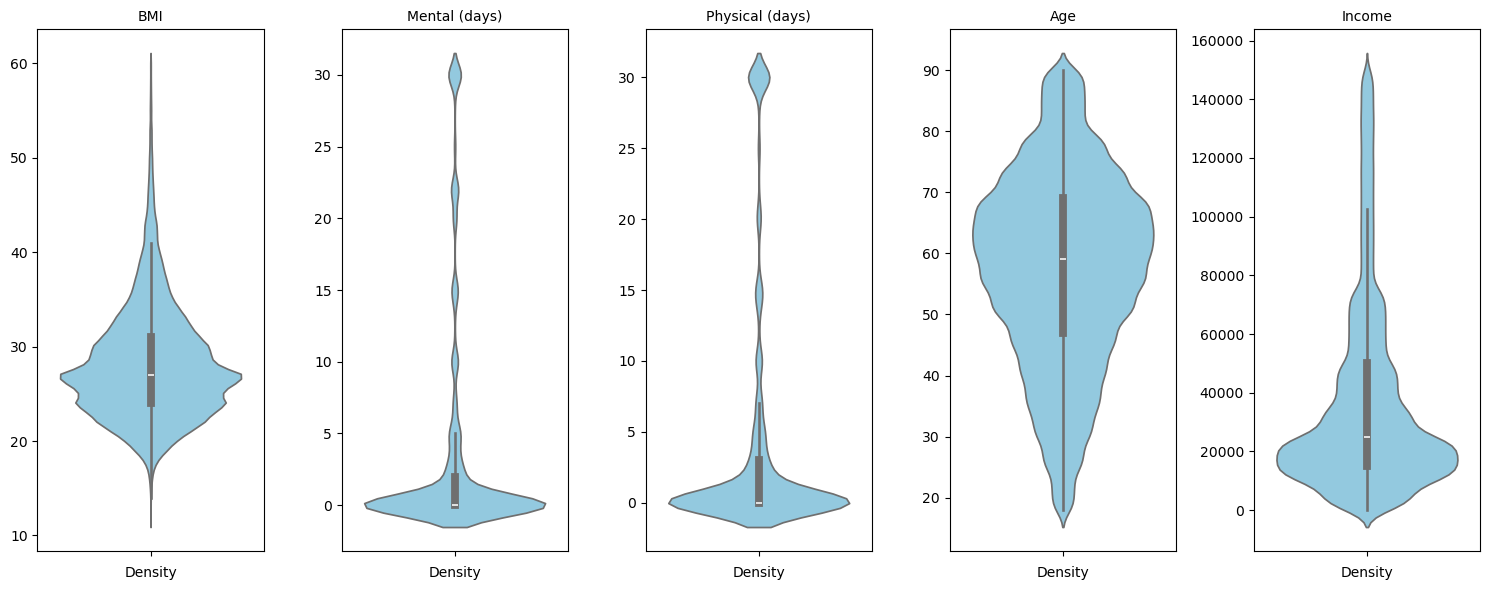


=== 分类特征分布（柱状图） ===
⚠️ 警告：以下分类列在 DataFrame 中不存在，将被跳过：['CholCheck', 'AnyHealthcare', 'NoDocbcCost']


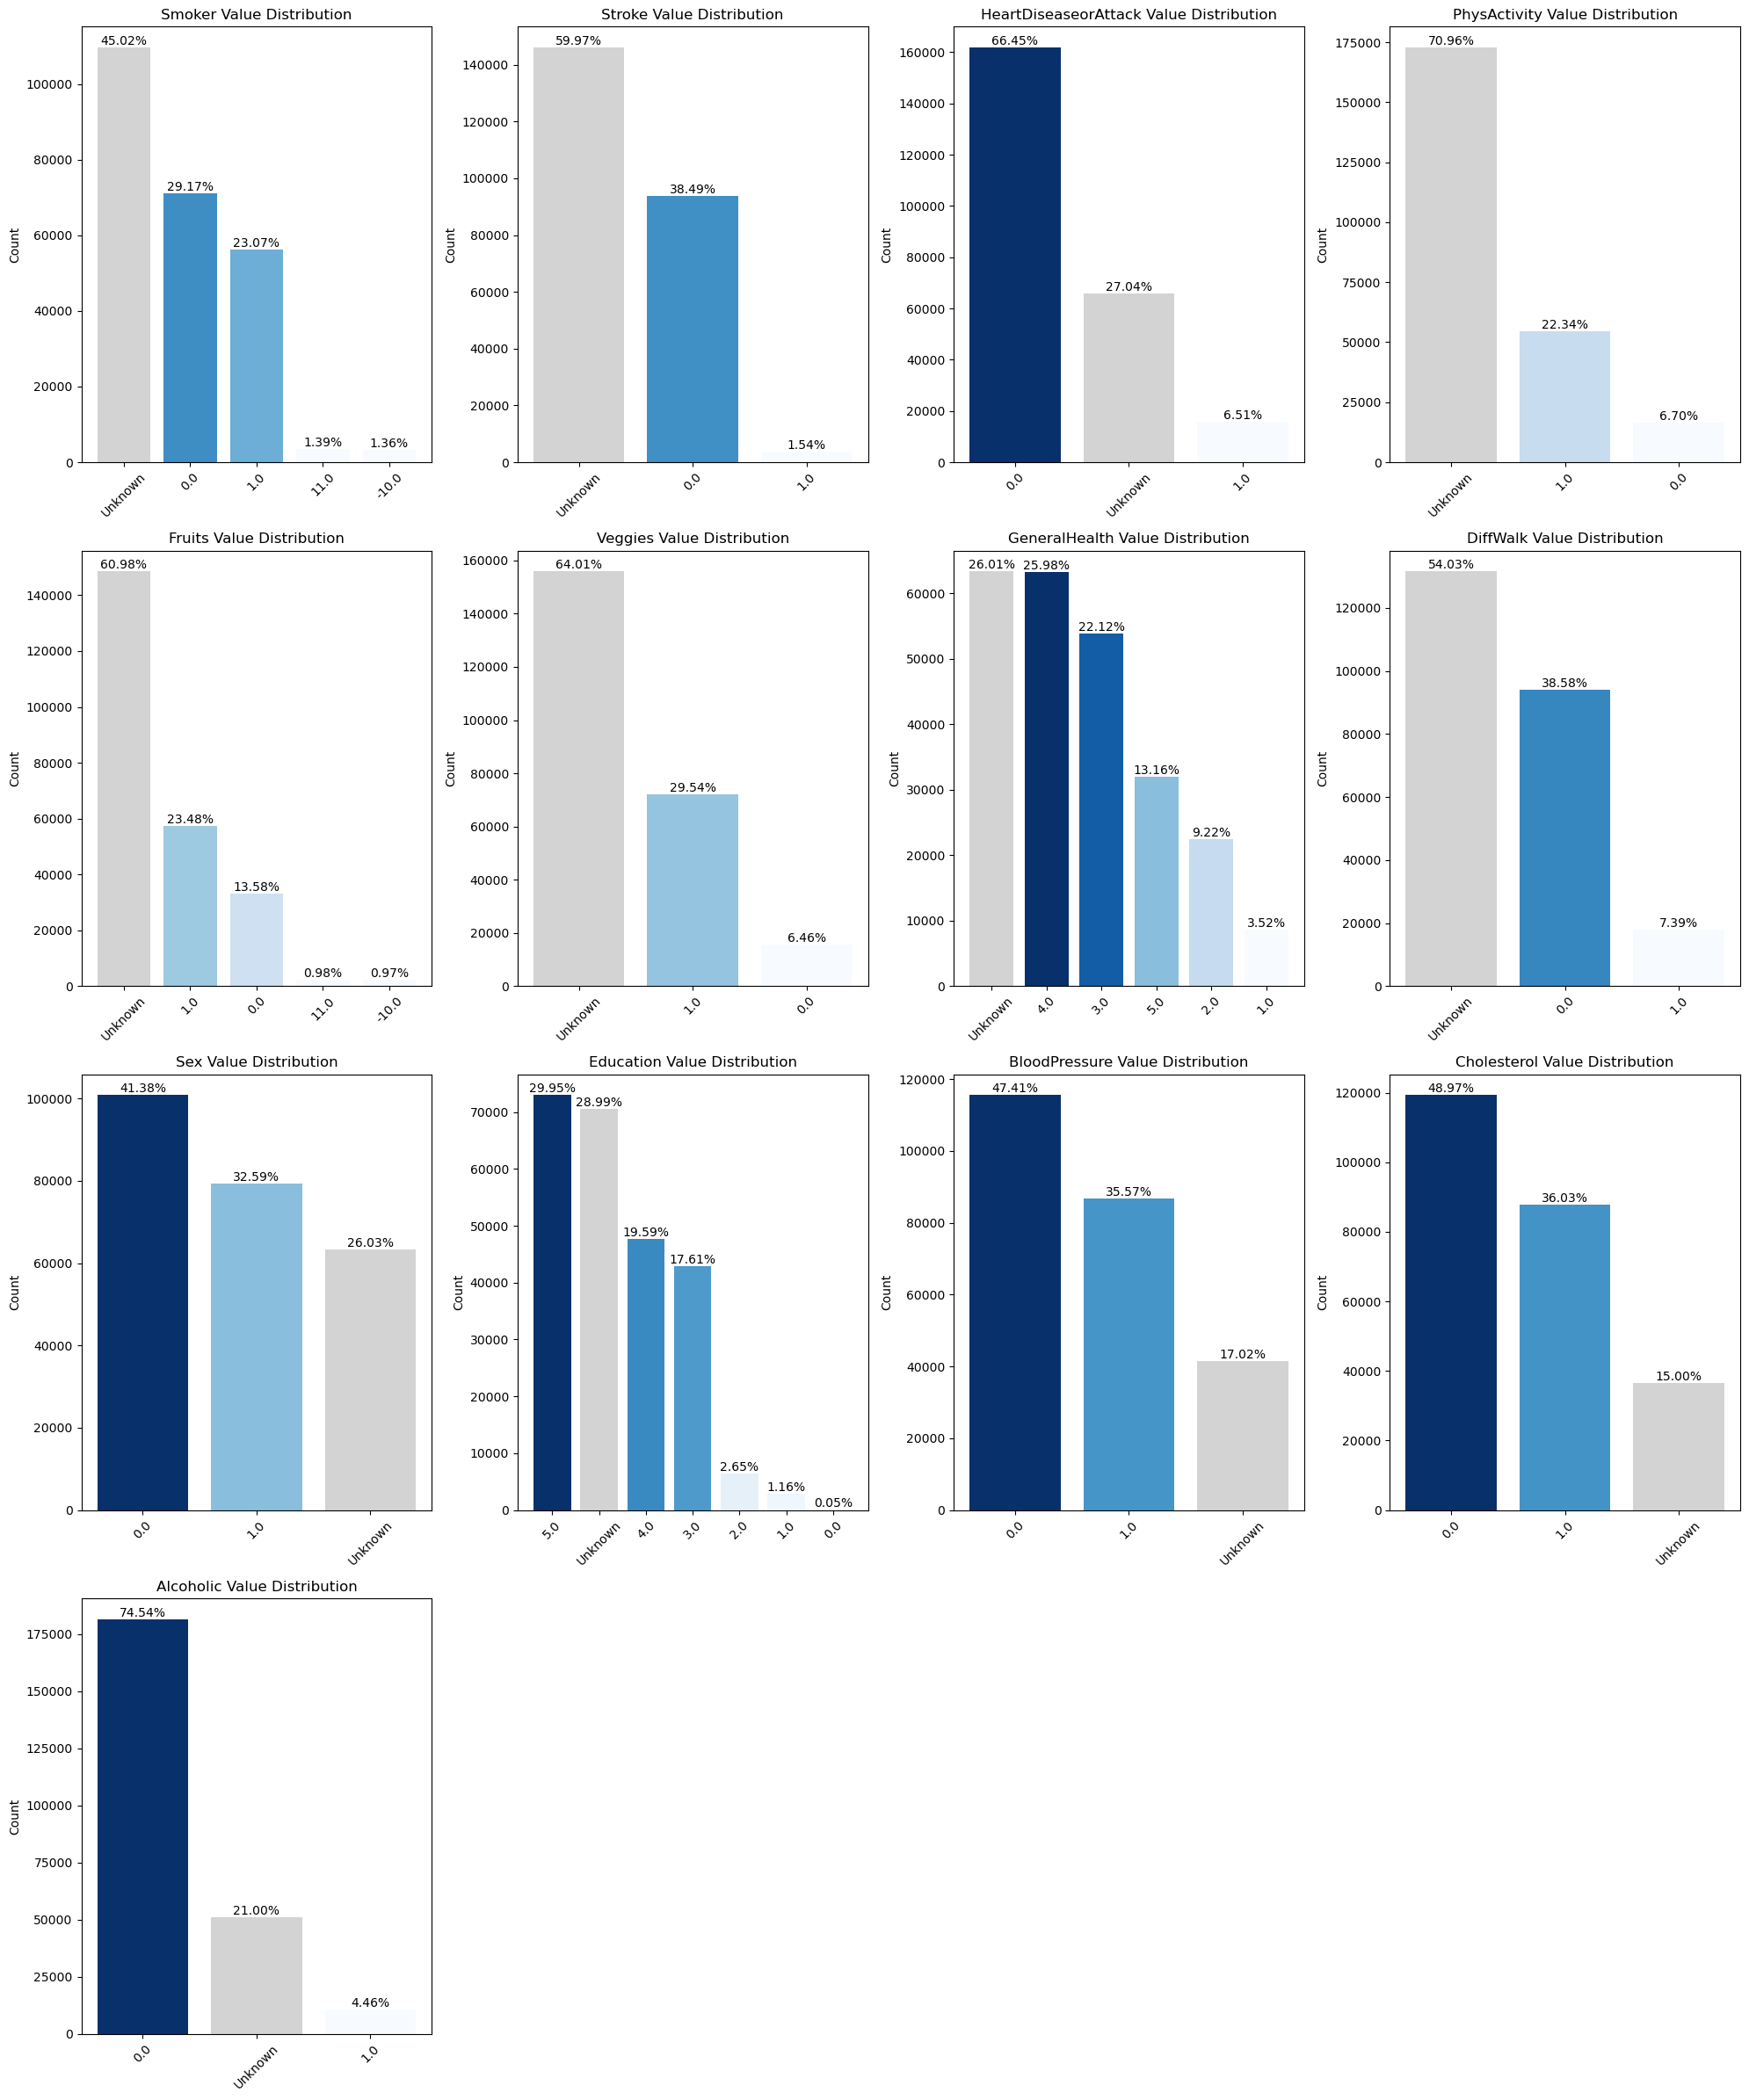

=== 缺失值信息（柱状图） ===


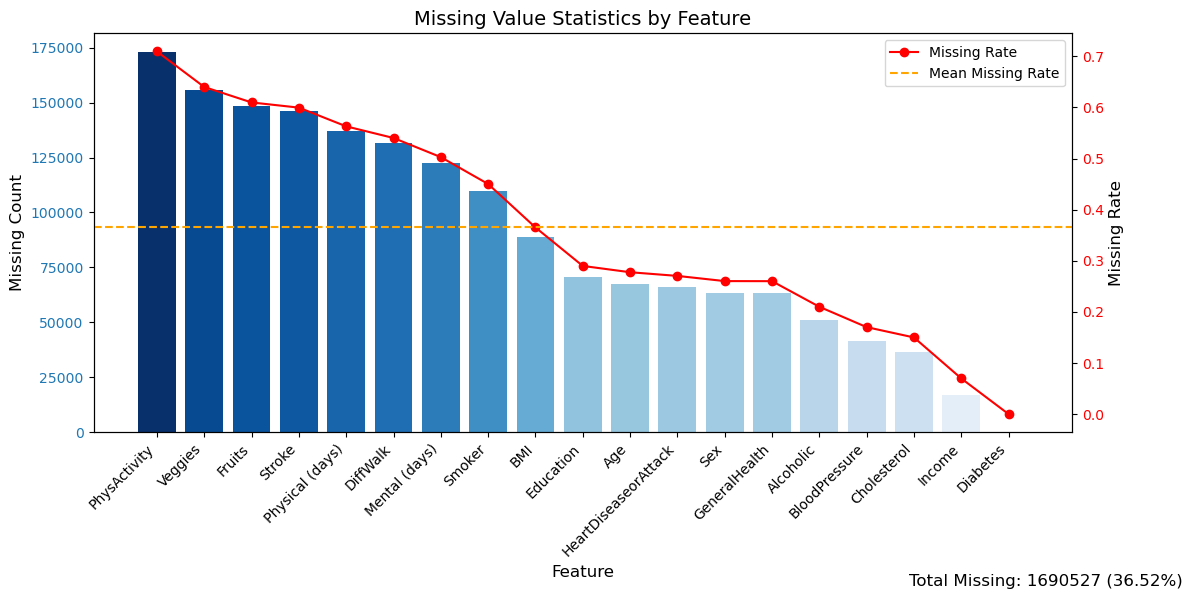

In [105]:
df, X, y = load_preprocess_plot('diabetes_diagnosis_drop.csv', numeric_features, categorical_features, do_plot=True)

In [106]:
def multi_method_imputation(df, numeric_features, methods=[1,2,3,4], n_imputations=1, verbose=True):
    """
    对完整 df 进行多种插补方法，返回插补后的完整 df 列表。
    支持选择方法 1~4，每种方法可以生成多个插补表。
    同时统计截断（删除负数 / 超限）的样本数和比例。
    
    参数
    ----
    df : pd.DataFrame
        包含特征和目标列（目标列名固定为 'Diabetes'）
    numeric_features : list
        连续型变量列表
    methods : list of int
        选择要运行的插补方法，1~4，对应：
            1: Mean/Median
            2: Random Sampling
            3: MICE + LinearRegression
            4: Deterministic Regression
    n_imputations : int
        每个方法生成的插补表数量
    verbose : bool
        是否打印截断信息

    返回
    ----
    processed : list of pd.DataFrame
        插补并合并 y 后的完整数据列表
    truncation_info : list of dict
        每个插补方法的截断信息，包含删除样本数和比例
    """

    # 拆分 X, y
    X = df.drop(columns=['Diabetes'])
    y = df['Diabetes']

    imputations = []
    truncation_info = []

    # ================= 方法1: Mean/Median =================
    if 1 in methods:
        for _ in range(n_imputations):
            X1 = X.copy()
            mean_imputer = SimpleImputer(strategy="mean")
            median_imputer = SimpleImputer(strategy="median")

            for col in X1.columns:
                if col in numeric_features:
                    X1[col] = mean_imputer.fit_transform(X1[[col]])
                else:
                    X1[col] = median_imputer.fit_transform(X1[[col]])

            imputations.append(X1)

    # ================= 方法2: Random Sampling =================
    if 2 in methods:
        for _ in range(n_imputations):
            X2 = X.copy()
            median_imputer = SimpleImputer(strategy="median")
            for col in numeric_features:
                missing = X2[col].isna()
                observed = X2[col].dropna().values
                if len(observed) > 0:
                    X2.loc[missing, col] = np.random.choice(observed, size=missing.sum())
            for col in X2.columns:
                if col not in numeric_features:
                    X2[col] = median_imputer.fit_transform(X2[[col]])
            imputations.append(X2)

    # ================= 方法3: MICE + LinearRegression =================
    if 3 in methods:
        for _ in range(n_imputations):
            X3 = X.copy()
            imputer3 = IterativeImputer(
                estimator=LinearRegression(),
                sample_posterior=False,
                random_state=np.random.randint(0,1e6),
                max_iter=10,
                min_value=0
            )
            X3[:] = imputer3.fit_transform(X3)
            imputations.append(X3)

    # ================= 方法4: Deterministic Regression =================
    if 4 in methods:
        for _ in range(n_imputations):
            X4 = X.copy()
            imputer4 = IterativeImputer(
                estimator=LinearRegression(),
                sample_posterior=False,
                random_state=np.random.randint(0,1e6),
                max_iter=10,
                min_value=0
            )
            X4[:] = imputer4.fit_transform(X4)
            imputations.append(X4)

    # ================= 插补后截断并合并 y =================
    processed = []
    for idx, X_df in enumerate(imputations):
        df_clean = X_df.copy()
        n_before = df_clean.shape[0]

        # 删除负数样本
        mask_valid = (df_clean >= 0).all(axis=1)

        # BMI 限制
        if "BMI" in df_clean.columns:
            mask_valid &= (df_clean["BMI"] >= 10) & (df_clean["BMI"] <= 60)

        # Mental/Physical (days) 限制
        for col in ["Mental (days)", "Physical (days)"]:
            if col in df_clean.columns:
                mask_valid &= (df_clean[col] >= 0) & (df_clean[col] <= 31)

        # 截断后的 X
        df_clean = df_clean[mask_valid].reset_index(drop=True)
        # 对应的 y
        y_clean = y[mask_valid].reset_index(drop=True)

        n_after = df_clean.shape[0]
        n_removed = n_before - n_after
        prop_removed = n_removed / n_before if n_before > 0 else 0

        truncation_info.append({
            'method': f'Imputation_{idx+1}',
            'removed_samples': n_removed,
            'removed_ratio': prop_removed
        })

        if verbose:
            print(f"Imputation_{idx+1}: 删除 {n_removed} 样本，比例 {prop_removed:.2%}")

        # 合并 X 和 y
        df_full = pd.concat([df_clean, y_clean], axis=1)
        processed.append(df_full)

    return processed, truncation_info


In [107]:
imputations ,truncation_info= multi_method_imputation(df, numeric_features, methods=[1,2,3,4], n_imputations=3, verbose=True)

Imputation_1: 删除 5644 样本，比例 2.32%
Imputation_2: 删除 5644 样本，比例 2.32%
Imputation_3: 删除 5644 样本，比例 2.32%
Imputation_4: 删除 5644 样本，比例 2.32%
Imputation_5: 删除 5644 样本，比例 2.32%
Imputation_6: 删除 5644 样本，比例 2.32%
Imputation_7: 删除 6536 样本，比例 2.68%
Imputation_8: 删除 6536 样本，比例 2.68%
Imputation_9: 删除 6536 样本，比例 2.68%
Imputation_10: 删除 6536 样本，比例 2.68%
Imputation_11: 删除 6536 样本，比例 2.68%
Imputation_12: 删除 6536 样本，比例 2.68%


#### 3.3.6.1 多重插补结果选取

In [108]:
def feature_diff(col1, col2, weights=None):
    """
    计算两列数值型数据的数学特征差异。
    
    参数：
    col1, col2 : array-like, pd.Series 或 np.array
        待比较的两列数据
    weights : dict, 可选
        各特征的权重，如 {'mean':1, 'std':1, 'median':1, 'iqr':1, 'skew':0.5, 'kurt':0.5}
    
    返回：
    total_score : float
        综合差异分数
    detail : dict
        各数学特征的差异
    """
    
    col1 = pd.Series(col1).dropna()
    col2 = pd.Series(col2).dropna()
    
    # 默认权重
    if weights is None:
        weights = {'mean':1, 'std':1, 'median':1, 'iqr':1, 'skew':0.5, 'kurt':0.5}
    
    # 计算特征
    f1 = {
        'mean': col1.mean(),
        'std': col1.std(),
        'median': col1.median(),
        'iqr': iqr(col1),
        'skew': skew(col1),
        'kurt': kurtosis(col1)
    }
    f2 = {
        'mean': col2.mean(),
        'std': col2.std(),
        'median': col2.median(),
        'iqr': iqr(col2),
        'skew': skew(col2),
        'kurt': kurtosis(col2)
    }
    
    # 计算差异
    detail = {}
    total_score = 0
    for key in f1.keys():
        diff = np.abs(f1[key] - f2[key])
        weighted_diff = weights.get(key, 1) * diff
        detail[key] = weighted_diff
        total_score += weighted_diff
    
    return total_score, detail

In [109]:
def dataframe_diff(df1, df2, weights=None):
    """
    计算两个 DataFrame 的数学特征差异。
    
    参数：
    df1, df2 : pd.DataFrame
        待比较的两个数据框
    weights : dict, 可选
        feature_diff 中使用的权重
    
    返回：
    total_score : float
        两个 DataFrame 的总差异分数
    col_detail : dict
        每列的差异分数和各特征明细
    """
    # 对齐列名
    common_cols = [col for col in df1.columns if col in df2.columns]
    
    total_score = 0
    col_detail = {}
    
    for col in common_cols:
        score, detail = feature_diff(df1[col], df2[col], weights=weights)
        col_detail[col] = {'total_score': score, 'detail': detail}
        total_score += score
    
    return total_score, col_detail

In [110]:
def build_feature_diff_matrix_with_total(imputed_datasets, X, weights=None):
    diff_matrix = pd.DataFrame(columns=list(X.columns) + ['Total'])

    for i, imputed_df in enumerate(imputed_datasets):
        df_imputed = pd.DataFrame(imputed_df, columns=X.columns)
        total_score, col_detail = dataframe_diff(X, df_imputed, weights=weights)
        row = {col: col_detail[col]['total_score'] for col in X.columns}
        row['Total'] = total_score
        diff_matrix.loc[f"Imputation_{i+1}"] = row

    return diff_matrix


+---------------+-------+----------+----------+------------------------+----------------+----------+-----------+-----------------+-----------------+-------------------+------------+-------+-------+-------------+----------+------------+-----------------+---------------+-------------+---------+
|               |   BMI |   Smoker |   Stroke |   HeartDiseaseorAttack |   PhysActivity |   Fruits |   Veggies |   GeneralHealth |   Mental (days) |   Physical (days) |   DiffWalk |   Sex |   Age |   Education |   Income |   Diabetes |   BloodPressure |   Cholesterol |   Alcoholic |   Total |
+===============+=======+==========+==========+========================+================+==========+===========+=================+=================+===================+============+=======+=======+=============+==========+============+=================+===============+=============+=========+
| Imputation_1  |  8.09 |    24.37 |    21.18 |                   2.46 |           6.61 |    37.61 |      6.06 |      

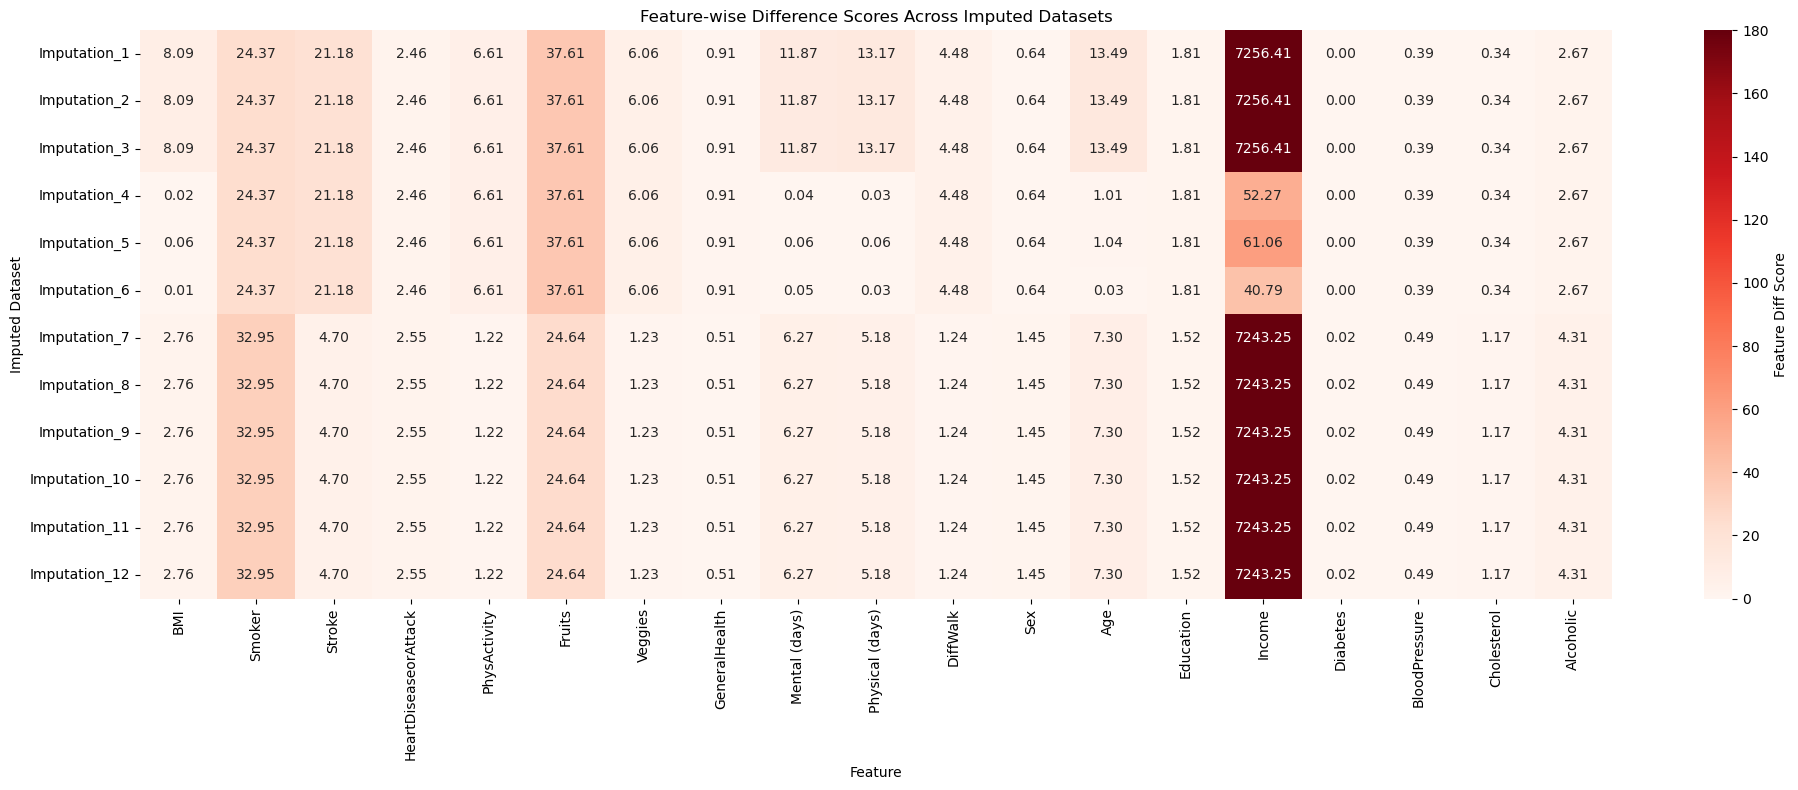

In [111]:
diff_matrix = build_feature_diff_matrix_with_total(imputations, df)

# 打印表格
print(tabulate(diff_matrix, headers='keys', tablefmt='grid', floatfmt=".2f"))

# 绘制热图
plt.figure(figsize=(20,8))
sns.heatmap(diff_matrix.drop(columns=['Total']).astype(float), 
            cmap="Reds", annot=True, fmt=".2f",
            cbar_kws={'label': 'Feature Diff Score'},
            vmin=0, vmax=180)  # 设置颜色上下界
plt.title("Feature-wise Difference Scores Across Imputed Datasets")
plt.ylabel("Imputed Dataset")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

In [112]:
df_income_complete = df.dropna(subset=['Income'])

# 查看删除后的数据情况
print(f"原始样本数: {len(df)}, 删除缺失Income后的样本数: {len(df_income_complete)}")

# 保存为 CSV
df_income_complete.to_csv('diabetes_diagnosis_income_complete.csv', index=False)

原始样本数: 243618, 删除缺失Income后的样本数: 226619


=== 数据集基本信息 ===
维度: (226619, 19)
=== 连续特征分布（小提琴图） ===


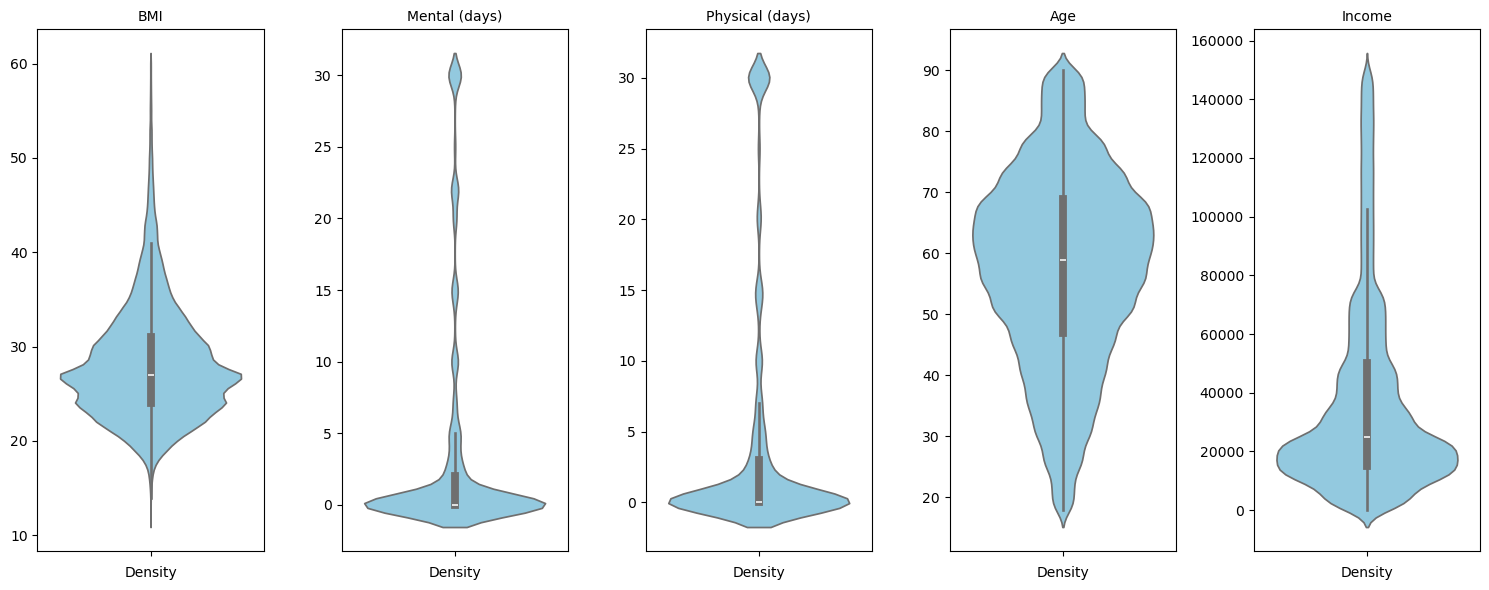


=== 分类特征分布（柱状图） ===
⚠️ 警告：以下分类列在 DataFrame 中不存在，将被跳过：['CholCheck', 'AnyHealthcare', 'NoDocbcCost']


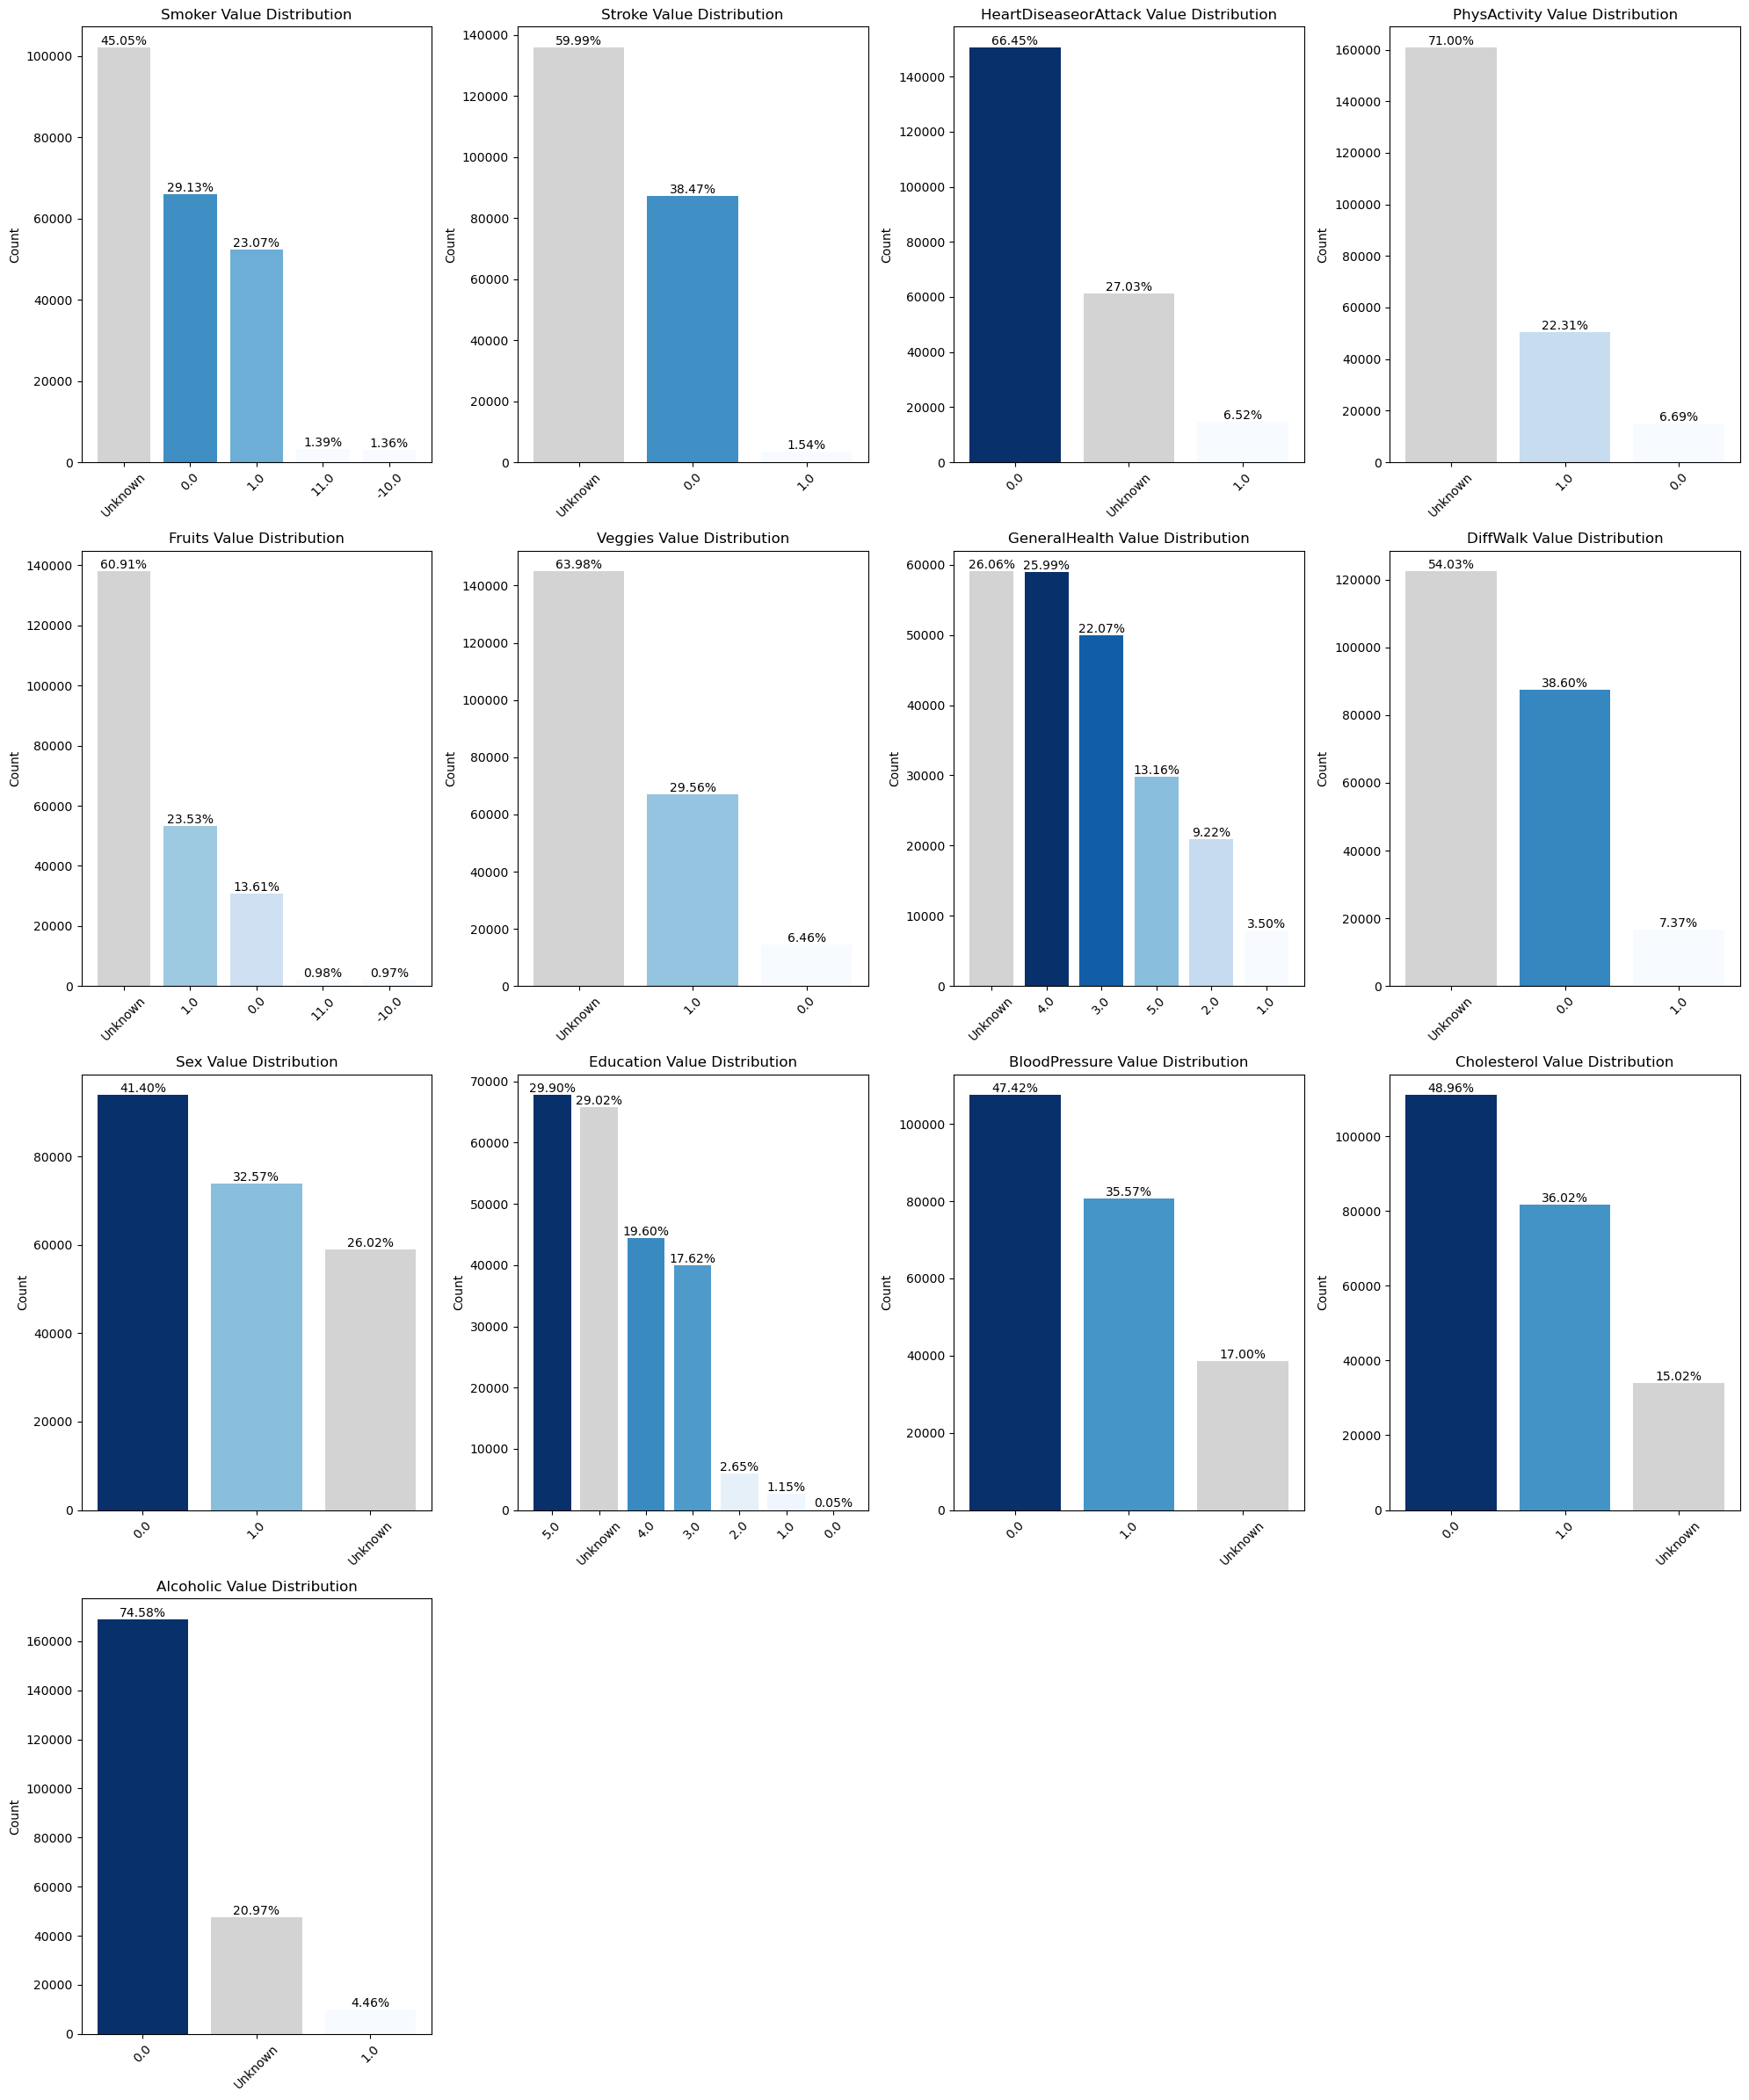

=== 缺失值信息（柱状图） ===


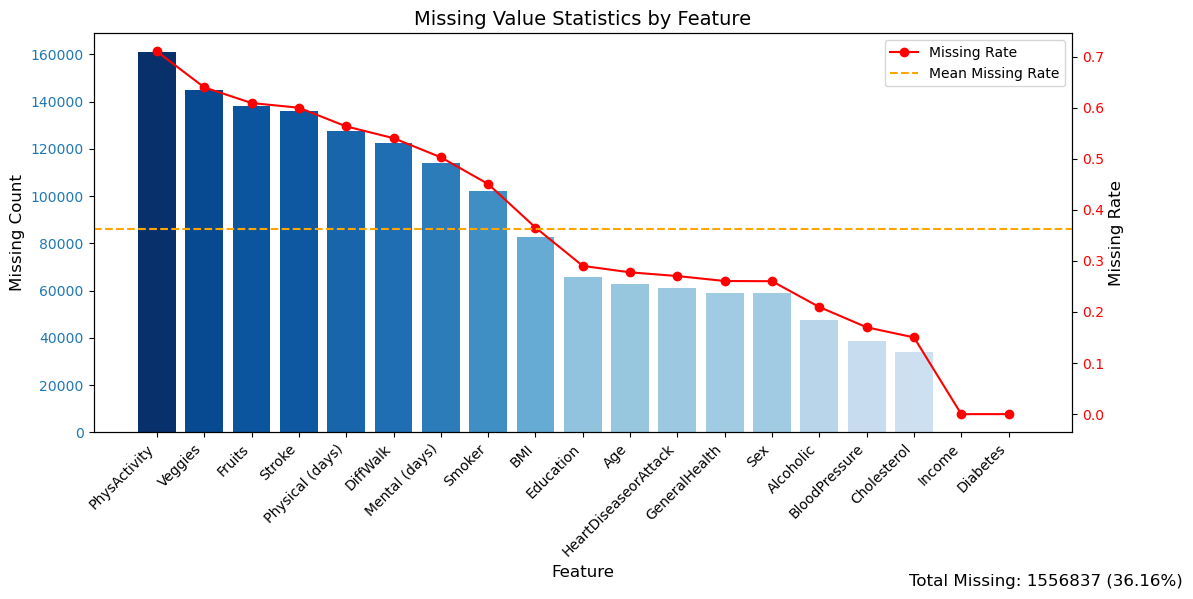

Imputation_1: 删除 5247 样本，比例 2.32%
Imputation_2: 删除 5247 样本，比例 2.32%
Imputation_3: 删除 5247 样本，比例 2.32%
Imputation_4: 删除 5247 样本，比例 2.32%
Imputation_5: 删除 5247 样本，比例 2.32%
Imputation_6: 删除 5247 样本，比例 2.32%
Imputation_7: 删除 5247 样本，比例 2.32%
Imputation_8: 删除 5247 样本，比例 2.32%
Imputation_9: 删除 5247 样本，比例 2.32%
Imputation_10: 删除 5247 样本，比例 2.32%
Imputation_11: 删除 5247 样本，比例 2.32%
Imputation_12: 删除 5247 样本，比例 2.32%


In [114]:
df, X, y = load_preprocess_plot('diabetes_diagnosis_income_complete.csv', numeric_features, categorical_features, do_plot=True)

new_imputations ,new_truncation_info= multi_method_imputation(df, numeric_features, methods=[1,2,3,4], n_imputations=3, verbose=True)

+---------------+-------+----------+----------+------------------------+----------------+----------+-----------+-----------------+-----------------+-------------------+------------+-------+-------+-------------+----------+------------+-----------------+---------------+-------------+---------+
|               |   BMI |   Smoker |   Stroke |   HeartDiseaseorAttack |   PhysActivity |   Fruits |   Veggies |   GeneralHealth |   Mental (days) |   Physical (days) |   DiffWalk |   Sex |   Age |   Education |   Income |   Diabetes |   BloodPressure |   Cholesterol |   Alcoholic |   Total |
+===============+=======+==========+==========+========================+================+==========+===========+=================+=================+===================+============+=======+=======+=============+==========+============+=================+===============+=============+=========+
| Imputation_1  |  8.09 |    24.27 |    21.26 |                   2.46 |           6.62 |    37.32 |      6.05 |      

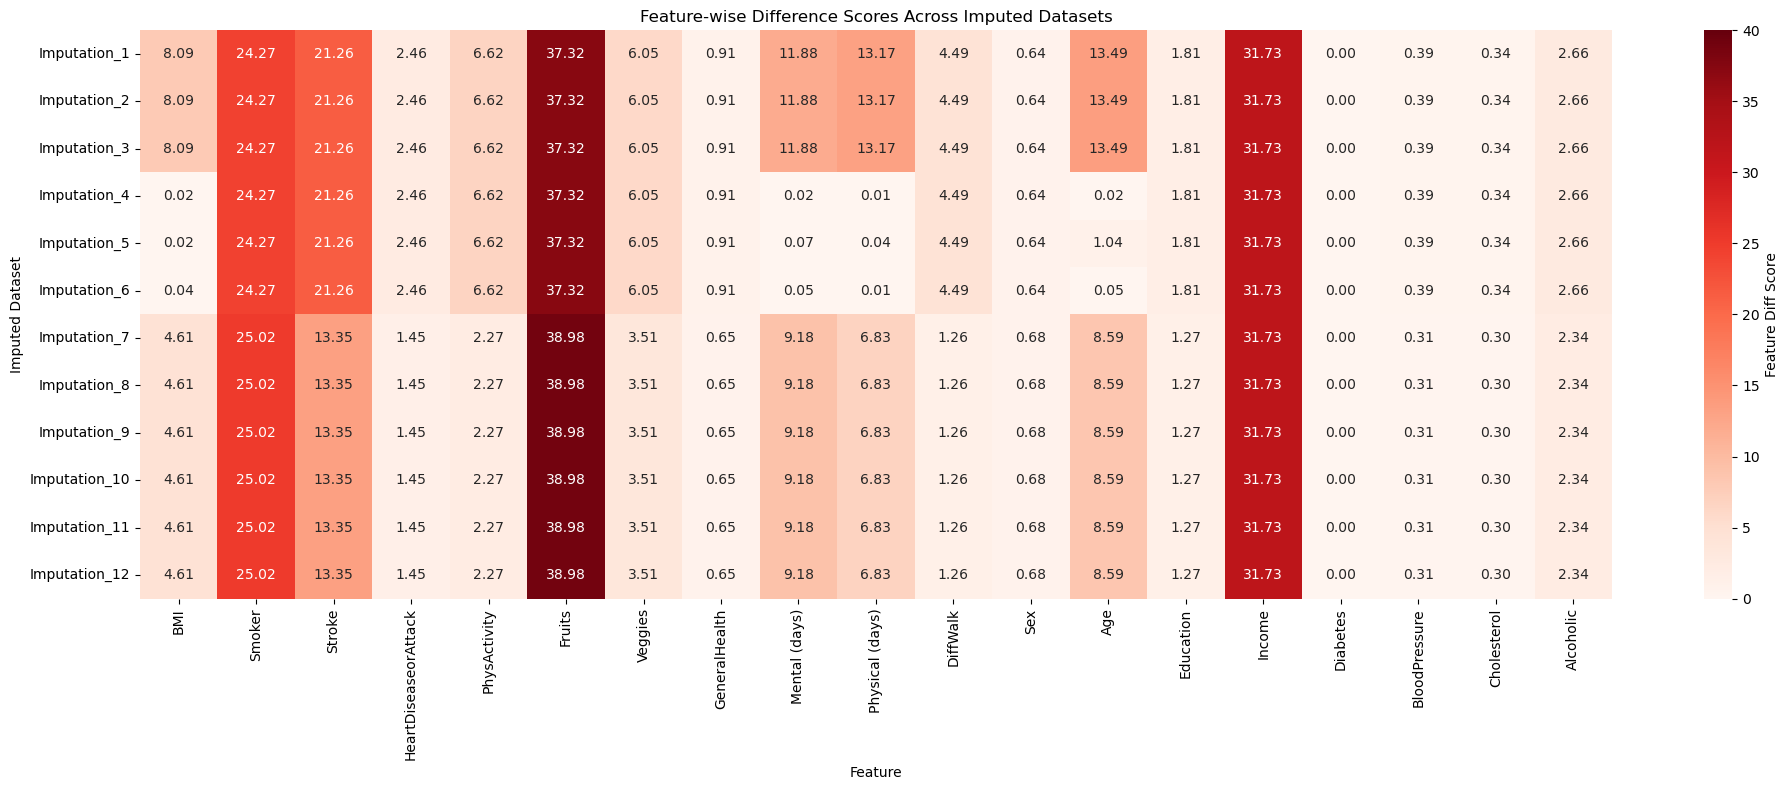

In [115]:
new_diff_matrix = build_feature_diff_matrix_with_total(new_imputations, df)

# 打印表格
print(tabulate(new_diff_matrix, headers='keys', tablefmt='grid', floatfmt=".2f"))

# 绘制热图
plt.figure(figsize=(20,8))
sns.heatmap(new_diff_matrix.drop(columns=['Total']).astype(float), 
            cmap="Reds", annot=True, fmt=".2f",
            cbar_kws={'label': 'Feature Diff Score'},
            vmin=0, vmax=40)  # 设置颜色上下界
plt.title("Feature-wise Difference Scores Across Imputed Datasets")
plt.ylabel("Imputed Dataset")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

In [118]:
df_final = new_imputations[3]  # Python 从0开始，Imputation_4 对应索引3

# 保存 CSV
df_final.to_csv('diabetes_diagnosis_complete.csv', index=False)
print(df_final.columns.tolist())

print(f"保存完成，文件名：diabetes_diagnosis_complete.csv，样本数：{df_final.shape[0]}")


['BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'GeneralHealth', 'Mental (days)', 'Physical (days)', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'BloodPressure', 'Cholesterol', 'Alcoholic', 'Diabetes']
保存完成，文件名：diabetes_diagnosis_complete.csv，样本数：221372


=== 数据集基本信息 ===
维度: (221372, 19)
=== 连续特征分布（小提琴图） ===


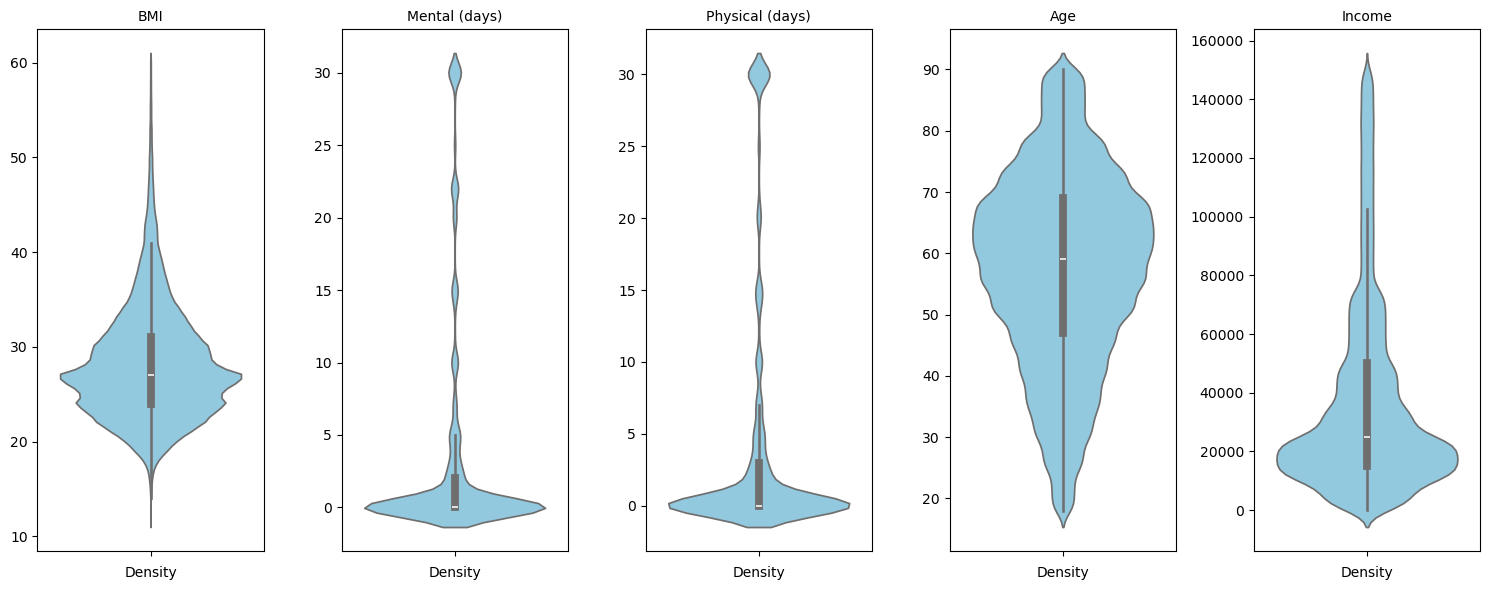


=== 分类特征分布（柱状图） ===
⚠️ 警告：以下分类列在 DataFrame 中不存在，将被跳过：['CholCheck', 'AnyHealthcare', 'NoDocbcCost']


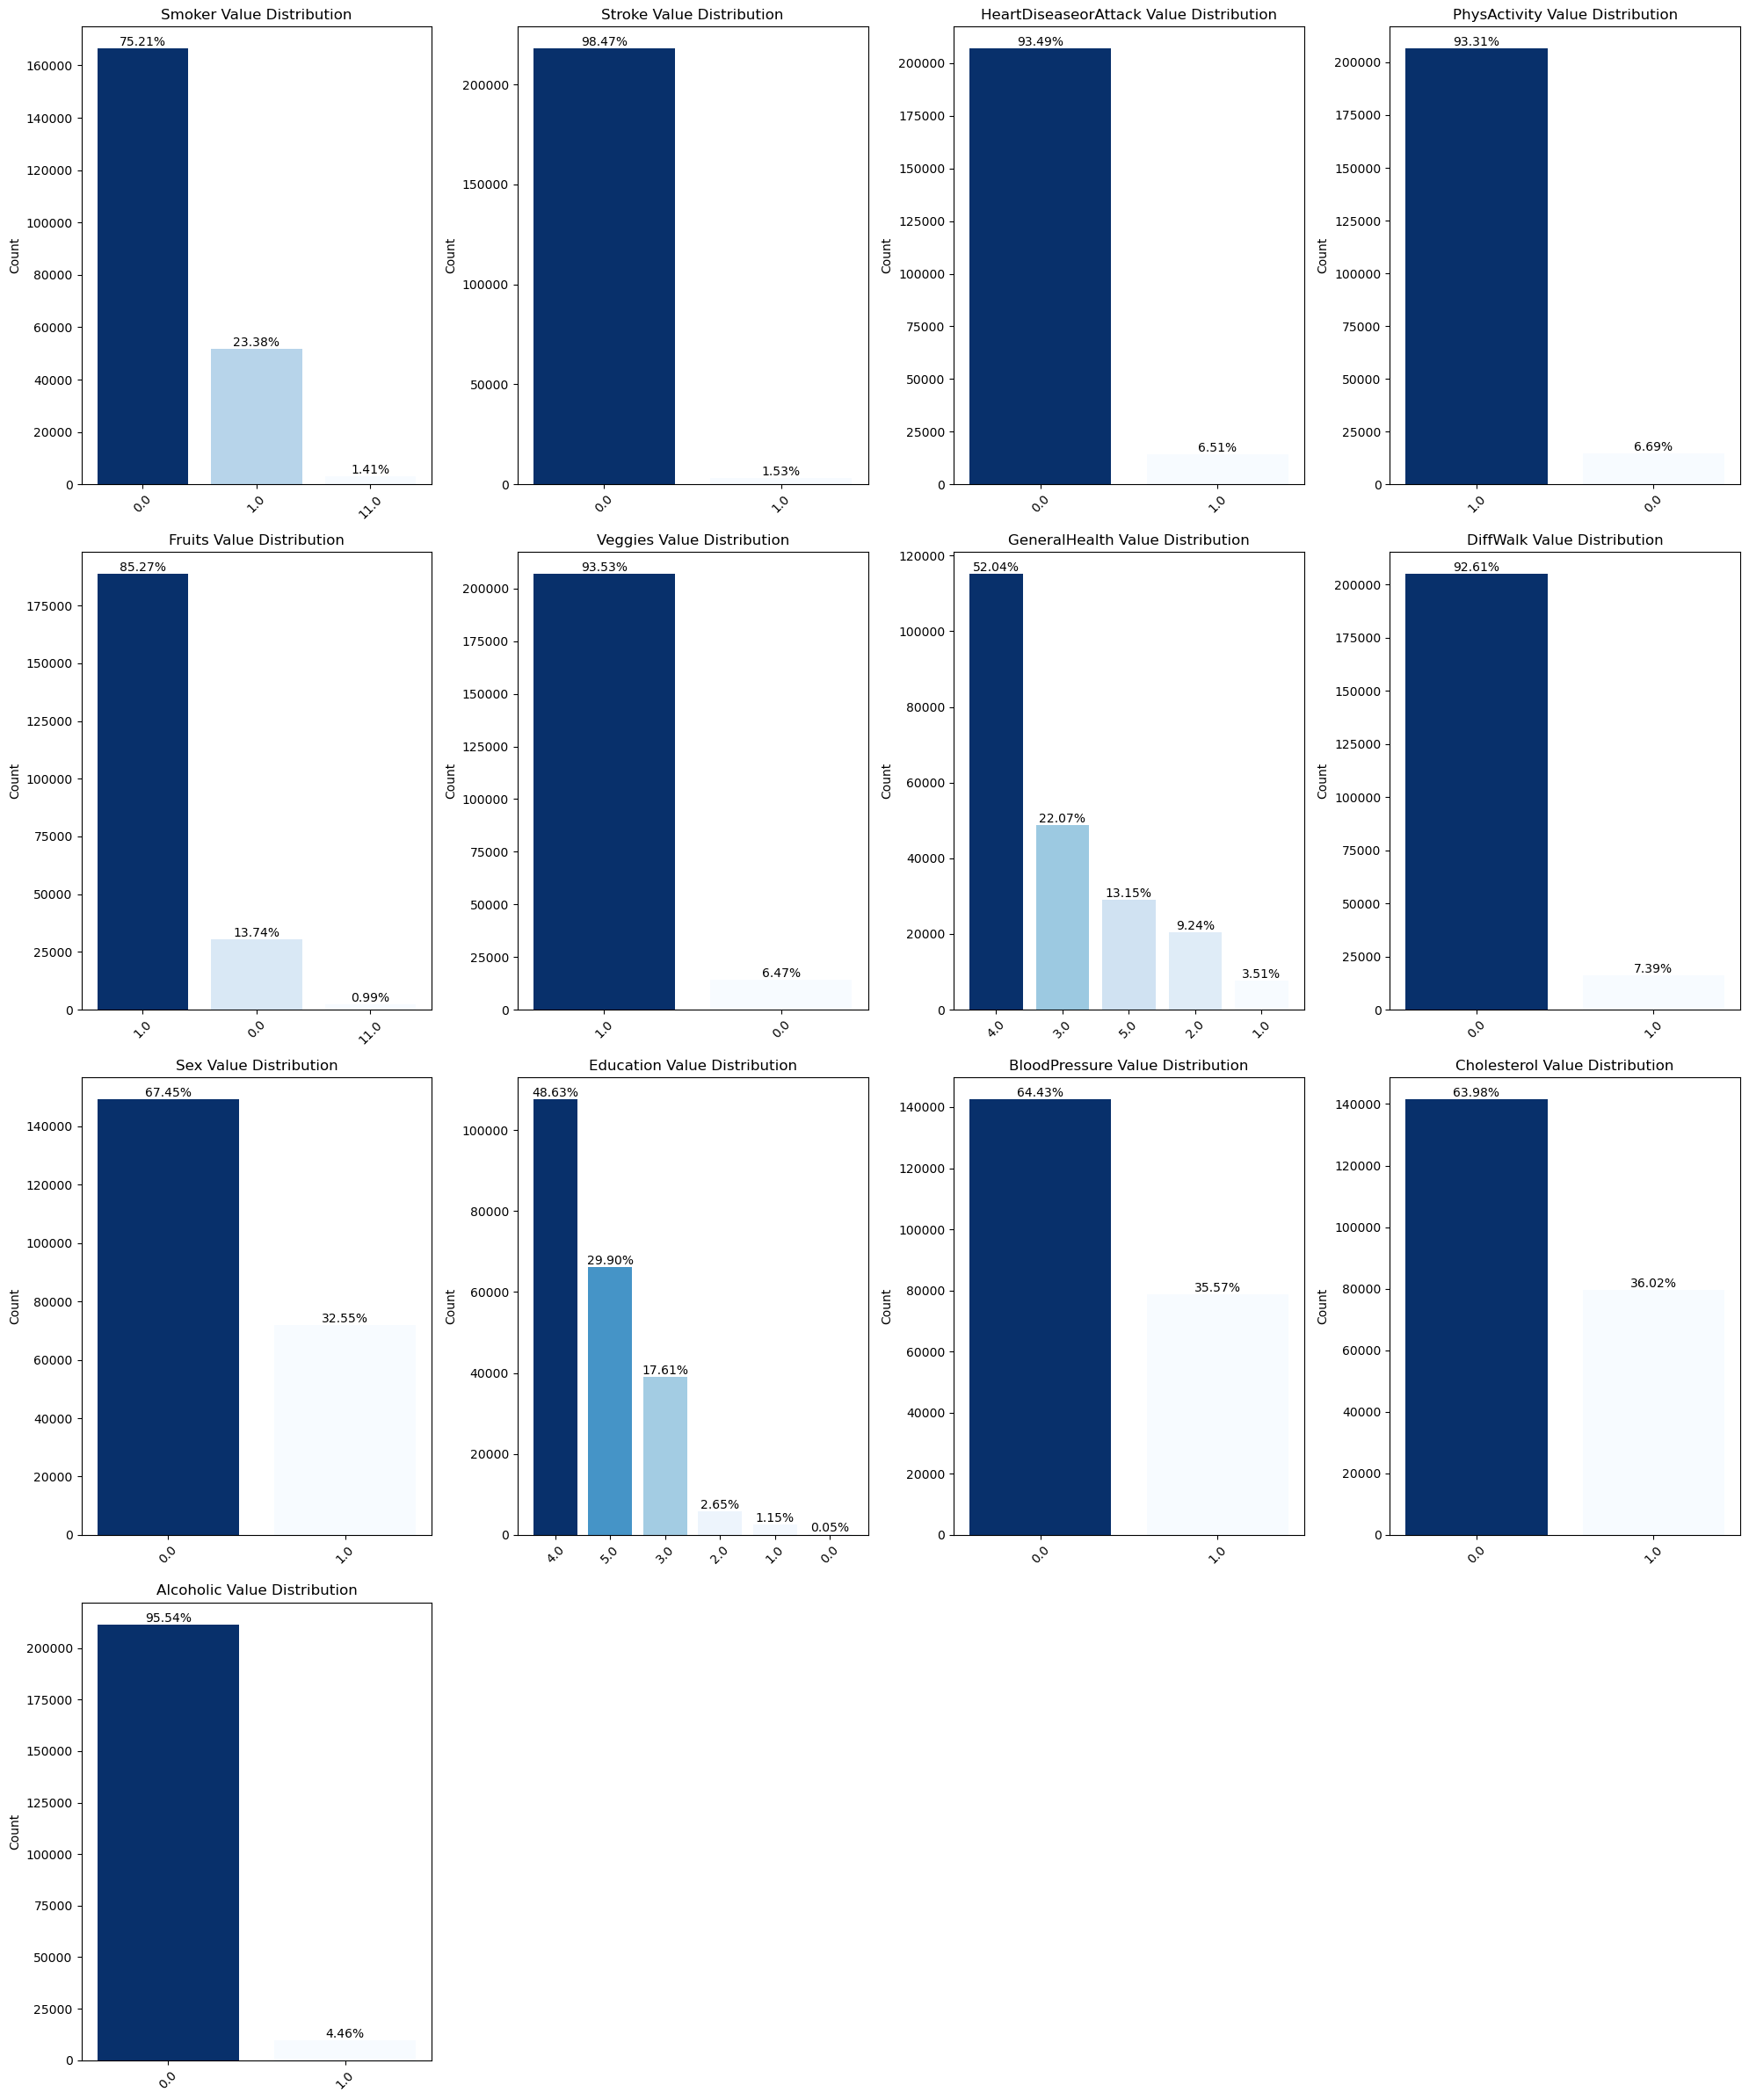

=== 缺失值信息（柱状图） ===


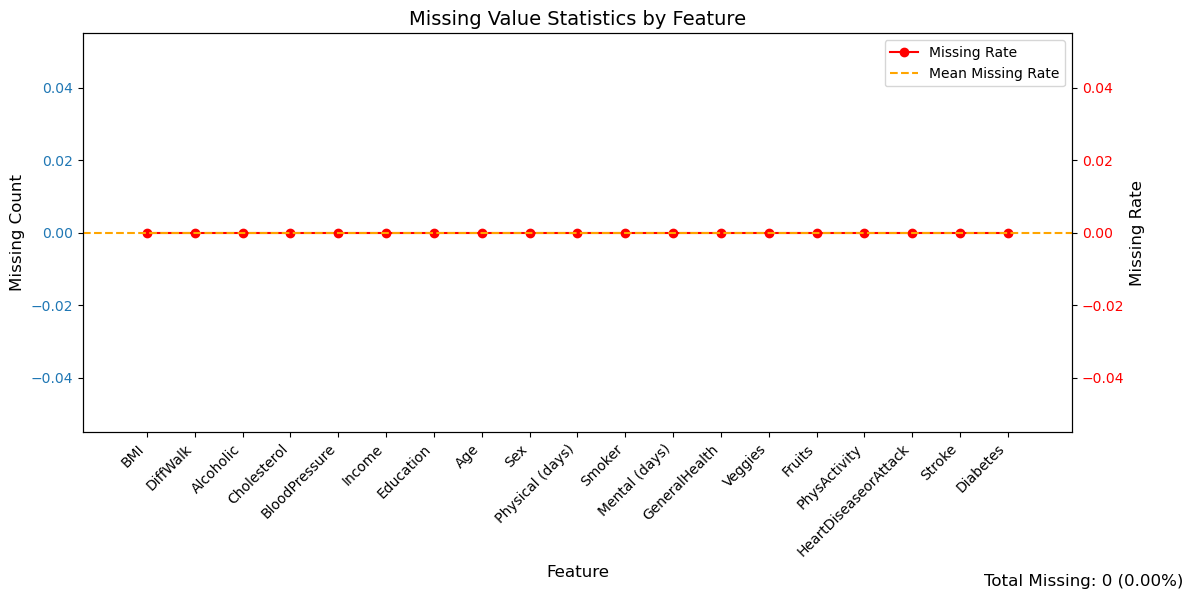

In [119]:
df,X,y = load_preprocess_plot('diabetes_diagnosis_complete.csv', numeric_features, categorical_features, do_plot=True)

### 3.4 特征工程

#### 3.4.1 特征变换

In [162]:
df,X,y = load_preprocess_plot('diabetes_diagnosis_complete.csv', numeric_features, categorical_features)

In [152]:
def analyze_numeric_features(df, numeric_features, sample_size=5000):
    results = []

    n_cols = 3
    n_rows = math.ceil(len(numeric_features) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    for idx, col in enumerate(numeric_features):
        data = df[col].dropna()
        desc = data.describe()
        skew = data.skew()
        kurt = data.kurt()

        # 正态性检验
        if len(data) > sample_size:
            sample = data.sample(sample_size, random_state=42)
        else:
            sample = data
        try:
            stat, p = shapiro(sample)
            p_val = round(p, 4)
        except Exception:
            p_val = "NA"

        results.append({
            "feature": col,
            "count": desc["count"],
            "mean": desc["mean"],
            "std": desc["std"],
            "min": desc["min"],
            "25%": desc["25%"],
            "50%": desc["50%"],
            "75%": desc["75%"],
            "max": desc["max"],
            "skew": skew,
            "kurt": kurt,
            "shapiro_p": p_val
        })

        sns.histplot(data, kde=True, bins=30, ax=axes[idx])
        axes[idx].set_title(f"{col} distribution")

    for j in range(len(numeric_features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame(results)
    print(tabulate(results_df, headers="keys", tablefmt="grid", floatfmt=".2f"))

    return results_df

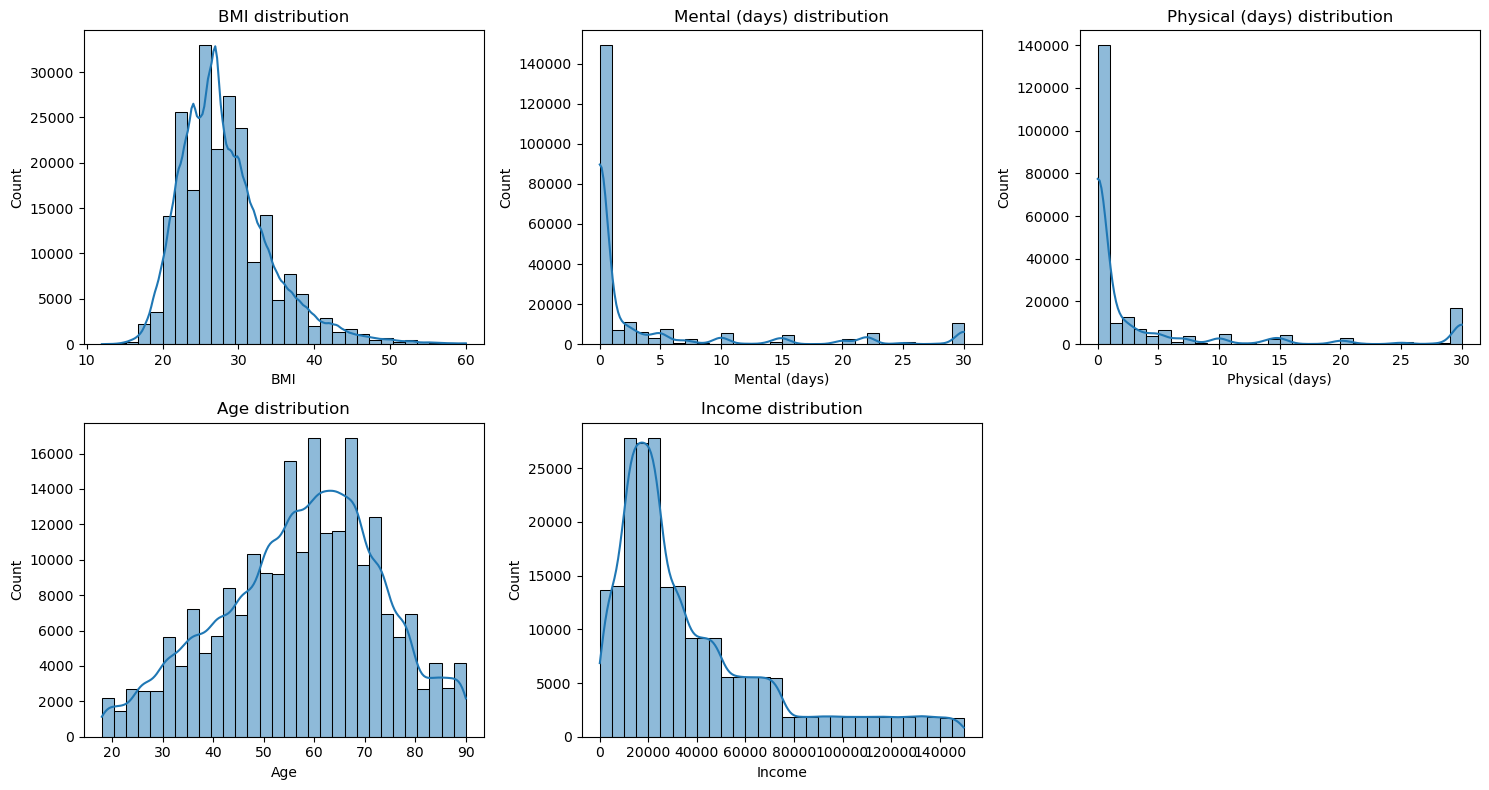

+----+-----------------+-----------+----------+----------+-------+----------+----------+----------+-----------+--------+--------+-------------+
|    | feature         |     count |     mean |      std |   min |      25% |      50% |      75% |       max |   skew |   kurt |   shapiro_p |
+====+=================+===========+==========+==========+=======+==========+==========+==========+===========+========+========+=============+
|  0 | BMI             | 221372.00 |    28.25 |     6.04 | 12.00 |    24.00 |    27.00 |    31.00 |     60.00 |   1.14 |   2.15 |        0.00 |
+----+-----------------+-----------+----------+----------+-------+----------+----------+----------+-----------+--------+--------+-------------+
|  1 | Mental (days)   | 221372.00 |     3.68 |     7.91 |  0.00 |     0.00 |     0.00 |     2.00 |     30.00 |   2.35 |   4.35 |        0.00 |
+----+-----------------+-----------+----------+----------+-------+----------+----------+----------+-----------+--------+--------+-------

In [153]:
# 使用方法
results_df = analyze_numeric_features(df, numeric_features)

1. BMI  
统计特征：均值 28.2，标准差 6.0，取值范围 12–60。  
偏度：1.14（轻度右偏），峰度 2.15。  
分布特征：接近正态，但有一定右偏和长尾。  
建议处理：建模时标准化，当前保持原样。  

2. Mental (days)  
统计特征：均值 3.68，中位数 0，取值 0–30。  
偏度：2.35（明显右偏），峰度 4.35。  
分布特征：大多数为 0，少数高值。  
建议处理：log1p 变换后分桶（如 0, 1–7, 8–30）；新建二值变量（是否大于0）。  

3. Physical (days)  
统计特征：均值 4.24，中位数 0，取值 0–30。  
偏度：2.21（明显右偏），峰度 3.50。  
分布特征：与 Mental 类似。  
建议处理：log1p 变换后分桶（如 0, 1–7, 8–30）；新建二值变量（是否大于0）。  

4. Age  
统计特征：均值 57.4，标准差 15.7，取值 18–90。  
偏度：-0.27（轻微左偏），峰度 -0.44。  
分布特征：近似正态。  
建议处理：建模时标准化，当前保持原样；也可按年龄段分桶以增强解释性。  

5. Income  
统计特征：均值 3.8 万，中位数 2.5 万，最大 15 万。  
偏度：1.49（明显右偏），峰度 1.63。  
分布特征：长尾分布，高收入拉高均值。  
建议处理：先做对数变换（log1p）以拉平长尾，再在建模时标准化；也可根据对数后的分布进一步分层，如低收入（log≤10）、中等收入（10<log≤11）、高收入（>11）。  

In [163]:
def transform_days_features(df, cols=["Mental (days)", "Physical (days)"], plot=False):
    """
    生成仅数值型输出：
      *_any            -> int8 (0/1)
      *_log1p          -> float
      *_qcut           -> int8 (0..3, 等频四分位)
      *_cut            -> int8 (0..4, 等宽五等分)
      *_bin_logic      -> int8 (0..2, 业务逻辑: 0days/1-7/8-30)
    同名列将被覆盖。
    """
    n = len(df)
    for col in cols:
        base = col.replace(" ", "_").lower()  # 与你现有命名保持一致

        # 1) 二元化
        any_col = f"{base}_any"
        df[any_col] = (df[col].astype(float) > 0).astype("int8")

        # 2) log1p
        log_col = f"{base}_log1p"
        df[log_col] = np.log1p(df[col].astype(float))

        # 3) 等频分桶（四分位）→ 整数编码 0..3
        qcut_col = f"{base}_qcut"
        try:
            qcodes = pd.qcut(df[log_col], q=4, labels=False, duplicates="drop")
            # 如遇到重复边界导致缺失，用微扰重算
            if pd.isna(qcodes).any():
                qcodes = pd.qcut(df[log_col] + np.random.normal(0, 1e-6, n),
                                 q=4, labels=False)
        except Exception:
            qcodes = pd.qcut(df[log_col] + np.random.normal(0, 1e-6, n),
                             q=4, labels=False)
        df[qcut_col] = qcodes.astype("int8")

        # 4) 等宽分桶（5等分）→ 整数编码 0..4
        cut_col = f"{base}_cut"
        ccodes = pd.cut(df[log_col], bins=5, labels=False, include_lowest=True)
        # 可能出现极端边界NaN，做一次兜底
        if pd.isna(ccodes).any():
            lo, hi = df[log_col].min(), df[log_col].max()
            eps = (hi - lo) * 1e-9 if hi > lo else 1e-9
            ccodes = pd.cut(df[log_col].clip(lo - eps, hi + eps),
                            bins=5, labels=False, include_lowest=True)
        df[cut_col] = ccodes.astype("int8")

        # 5) 业务逻辑分桶（0, 1–7, 8–30）→ 整数编码 0..2
        logic_col = f"{base}_bin_logic"
        lcodes = pd.cut(df[col].astype(float),
                        bins=[-1, 0, 7, 30], labels=False, include_lowest=True)
        df[logic_col] = lcodes.astype("int8")

        # 可视化（可选）
        if plot:
            fig, axes = plt.subplots(2, 2, figsize=(12, 9))
            fig.suptitle(f"Feature engineering for {col}", fontsize=14)

            df[any_col].value_counts().sort_index().plot(kind="bar", ax=axes[0,0])
            axes[0,0].set_title(f"{any_col} (0/1)")

            df[log_col].hist(bins=30, ax=axes[0,1])
            axes[0,1].set_title(f"{log_col}")

            df[qcut_col].value_counts().sort_index().plot(kind="bar", ax=axes[1,0])
            axes[1,0].set_title(f"{qcut_col} (0..3)")

            df[cut_col].value_counts().sort_index().plot(kind="bar", ax=axes[1,1])
            axes[1,1].set_title(f"{cut_col} (0..4)")

            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(4,3))
            df[logic_col].value_counts().sort_index().plot(kind="bar")
            plt.title(f"{logic_col} (0..2)")
            plt.tight_layout()
            plt.show()

    return df

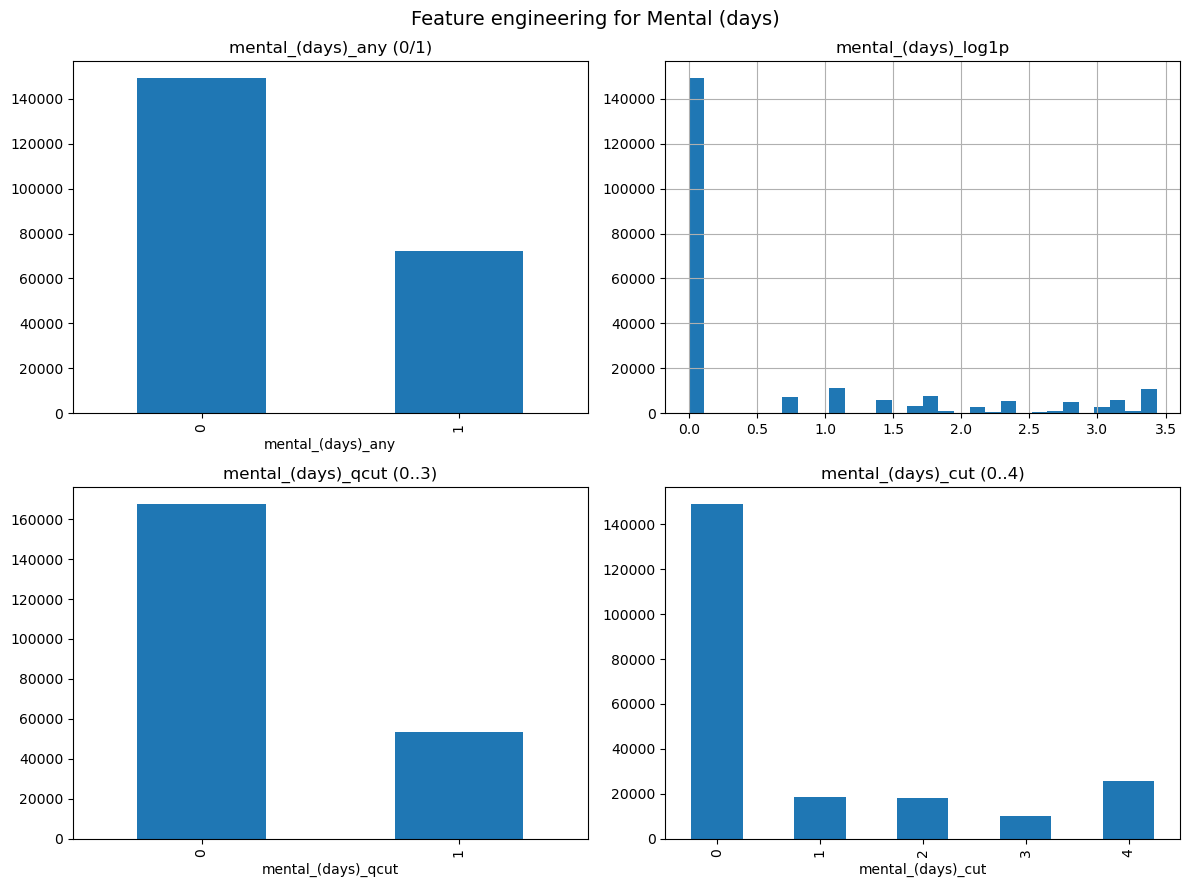

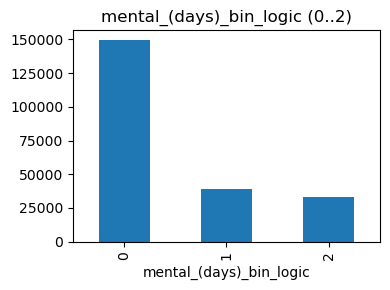

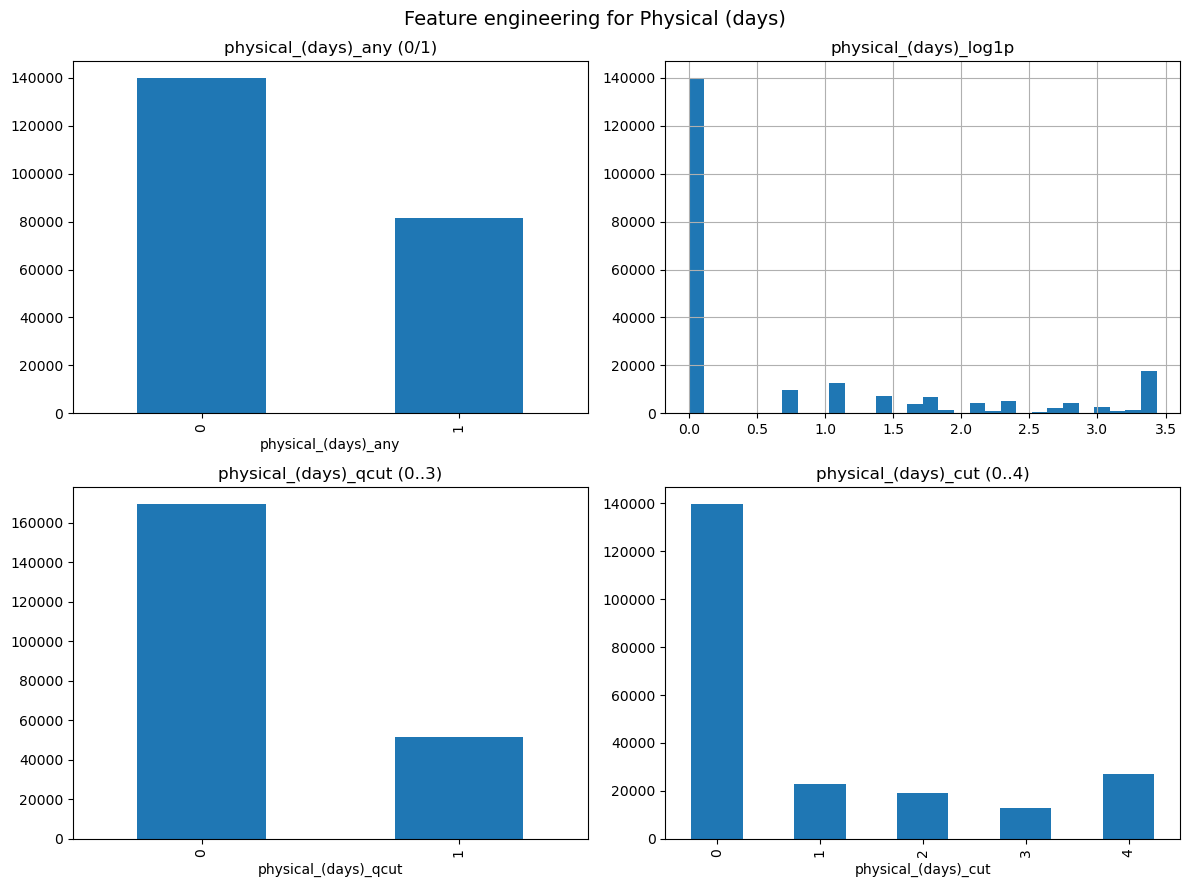

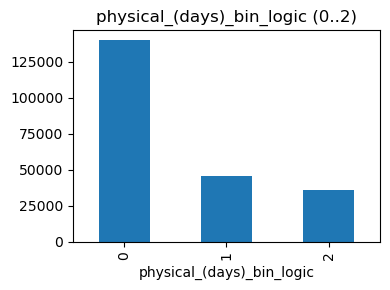

In [164]:
df = transform_days_features(df, cols=["Mental (days)", "Physical (days)"], plot=True)

In [167]:
def evaluate_features(X, y, features, continuous_features, discrete_features):
    """
    X: pd.DataFrame 特征数据
    y: pd.Series 目标变量 (多分类)
    features: list, 要比较的特征名
    continuous_features: list, 属于连续特征
    discrete_features: list, 属于离散特征
    """
    results = []

    for feat in features:
        if feat in continuous_features:
            score = anova_eta_squared(X[feat], y)
            metric = "eta_squared"
        elif feat in discrete_features:
            score = cramers_v(X[feat], y)
            metric = "cramers_v"
        else:
            score = None
            metric = "N/A"
        
        results.append({
            "feature": feat,
            "metric": metric,
            "score": score
        })
    
    return pd.DataFrame(results).sort_values("score", ascending=False)


# ===== 特征划分 =====
features_mental = [
    "Mental (days)", "mental_(days)_log1p",
    "mental_(days)_any", "mental_(days)_qcut",
    "mental_(days)_cut", "mental_(days)_bin_logic"
]

features_physical = [
    "Physical (days)", "physical_(days)_log1p",
    "physical_(days)_any", "physical_(days)_qcut",
    "physical_(days)_cut", "physical_(days)_bin_logic"
]

continuous_features = [
    "Mental (days)", "mental_(days)_log1p",
    "Physical (days)", "physical_(days)_log1p"
]

discrete_features = list(set(features_mental + features_physical) - set(continuous_features))


# ===== 计算结果 =====
results_mental = evaluate_features(df, y, features_mental, continuous_features, discrete_features)
results_physical = evaluate_features(df, y, features_physical, continuous_features, discrete_features)

from tabulate import tabulate

print("Mental features:")
print(tabulate(results_mental, headers="keys", tablefmt="grid", floatfmt=".3f"))

print("\nPhysical features:")
print(tabulate(results_physical, headers="keys", tablefmt="grid", floatfmt=".3f"))

Mental features:
+----+-------------------------+-------------+---------+
|    | feature                 | metric      |   score |
+====+=========================+=============+=========+
|  3 | mental_(days)_qcut      | cramers_v   |   0.024 |
+----+-------------------------+-------------+---------+
|  4 | mental_(days)_cut       | cramers_v   |   0.023 |
+----+-------------------------+-------------+---------+
|  5 | mental_(days)_bin_logic | cramers_v   |   0.022 |
+----+-------------------------+-------------+---------+
|  2 | mental_(days)_any       | cramers_v   |   0.015 |
+----+-------------------------+-------------+---------+
|  0 | Mental (days)           | eta_squared |   0.001 |
+----+-------------------------+-------------+---------+
|  1 | mental_(days)_log1p     | eta_squared |   0.001 |
+----+-------------------------+-------------+---------+

Physical features:
+----+---------------------------+-------------+---------+
|    | feature                   | metric      | 

In [169]:
def evaluate_feature_sets_linear(X, y, feature_sets):
    """
    使用线性回归/逻辑回归评估不同特征集
    """
    results = []
    
    for name, feats in feature_sets.items():
        X_sub = sm.add_constant(X[feats])  # 加常数项
        model = sm.MNLogit(y, X_sub)  # 多分类逻辑回归 (如果是二分类也适用)
        result = model.fit(disp=False)
        
        results.append({
            "feature_set": name,
            "n_features": len(feats),
            "aic": result.aic,
            "bic": result.bic,
            "pseudo_r2": result.prsquared
        })
    
    return pd.DataFrame(results).sort_values("pseudo_r2", ascending=False)

+----+------------------+--------------+------------+------------+-------------+
|    | feature_set      |   n_features |        aic |        bic |   pseudo_r2 |
+====+==================+==============+============+============+=============+
|  3 | 原始+分桶+二元化 |           10 | 216876.677 | 217103.445 |       0.007 |
+----+------------------+--------------+------------+------------+-------------+
|  2 | 原始+分桶        |            8 | 216882.940 | 217068.477 |       0.007 |
+----+------------------+--------------+------------+------------+-------------+
|  1 | 原始+二元化      |            4 | 216908.873 | 217011.949 |       0.007 |
+----+------------------+--------------+------------+------------+-------------+
|  0 | 原始             |            2 | 216964.940 | 217026.786 |       0.006 |
+----+------------------+--------------+------------+------------+-------------+


In [170]:
# 生成按要求的 feature_sets（Mental 与 Physical 分开）
orig_cols = ["Mental (days)", "Physical (days)"]

feature_sets = {}
for col in orig_cols:
    base = col.replace(" ", "_").lower()       # e.g. "mental_(days)"
    short = base.split("_")[0].capitalize()    # "Mental" or "Physical"

    # 原始 / 原始+二元化（保留原始）
    feature_sets[f"{short}_原始"] = [col]
    feature_sets[f"{short}_原始+二元化"] = [col, f"{base}_any"]

    # 仅分桶（不包含原始）
    feature_sets[f"{short}_等频分桶"] = [f"{base}_qcut"]
    feature_sets[f"{short}_等宽分桶"] = [f"{base}_cut"]
    feature_sets[f"{short}_业务逻辑分桶"] = [f"{base}_bin_logic"]

    # 分桶 + 二元化（不包含原始）
    feature_sets[f"{short}_等频分桶+二元化"] = [f"{base}_qcut", f"{base}_any"]
    feature_sets[f"{short}_等宽分桶+二元化"] = [f"{base}_cut", f"{base}_any"]
    feature_sets[f"{short}_业务逻辑分桶+二元化"] = [f"{base}_bin_logic", f"{base}_any"]

# 检查
from tabulate import tabulate
rows = [(k, len(v), v) for k,v in feature_sets.items()]
print(tabulate(rows, headers=["feature_set","n_feats","features"], tablefmt="grid"))

+------------------------------+-----------+------------------------------------------------------+
| feature_set                  |   n_feats | features                                             |
+==============================+===========+======================================================+
| Mental_原始                  |         1 | ['Mental (days)']                                    |
+------------------------------+-----------+------------------------------------------------------+
| Mental_原始+二元化           |         2 | ['Mental (days)', 'mental_(days)_any']               |
+------------------------------+-----------+------------------------------------------------------+
| Mental_等频分桶              |         1 | ['mental_(days)_qcut']                               |
+------------------------------+-----------+------------------------------------------------------+
| Mental_等宽分桶              |         1 | ['mental_(days)_cut']                                |
+--------------

In [171]:
results_linear = evaluate_feature_sets_linear(df, y, feature_sets)
print(tabulate(results_linear, headers="keys", tablefmt="grid", floatfmt=".3f"))

+----+------------------------------+--------------+------------+------------+-------------+
|    | feature_set                  |   n_features |        aic |        bic |   pseudo_r2 |
+====+==============================+==============+============+============+=============+
| 14 | Physical_等宽分桶+二元化     |            2 | 217068.780 | 217130.626 |       0.006 |
+----+------------------------------+--------------+------------+------------+-------------+
|  9 | Physical_原始+二元化         |            2 | 217097.177 | 217159.023 |       0.006 |
+----+------------------------------+--------------+------------+------------+-------------+
| 11 | Physical_等宽分桶            |            1 | 217105.601 | 217146.831 |       0.006 |
+----+------------------------------+--------------+------------+------------+-------------+
|  8 | Physical_原始                |            1 | 217127.832 | 217169.062 |       0.006 |
+----+------------------------------+--------------+------------+------------+----------

我们针对单变量线性回归（多项式逻辑回归）对 **Mental (days)** 与 **Physical (days)** 的不同特征处理方法进行了比较，处理方式包括：

1. 原始特征
2. 原始 + 二元化
3. 分桶（等频/等宽/业务逻辑）
4. 分桶 + 二元化

通过 **AIC、BIC、pseudo-R²** 指标评估模型拟合效果。

**Mental (days)**

- **原始+二元化**略优于原始，AIC/BIC下降，但 pseudo-R² 改变微小。
- **分桶单独使用**未明显提升拟合度，反而 AIC/BIC 有时上升。
- **分桶+二元化**略优于分桶单独使用（尤其等宽分桶+二元化），但整体 pseudo-R² 仍极低（0.001）。
- **结论**：Mental 对目标类别的解释力有限，单变量层面优化收益微小。

**Physical (days)**

- **原始+二元化**比原始略优，AIC/BIC下降约 30~35。
- **等宽分桶+二元化**组合效果最佳（AIC 最低，pseudo-R²=0.006）。
- **分桶单独使用**（尤其等频和业务逻辑分桶）效果一般，有时略差于原始。
- **结论**：Physical 信息量比 Mental 高，二元化或分桶+二元化能够带来微小提升，但总体单变量贡献仍属弱特征。

分桶+二元化收益微弱，单变量解释力低，不推荐单独使用该方法。  


=== 数据集基本信息 ===
维度: (221372, 19)
=== 连续特征分布（小提琴图） ===


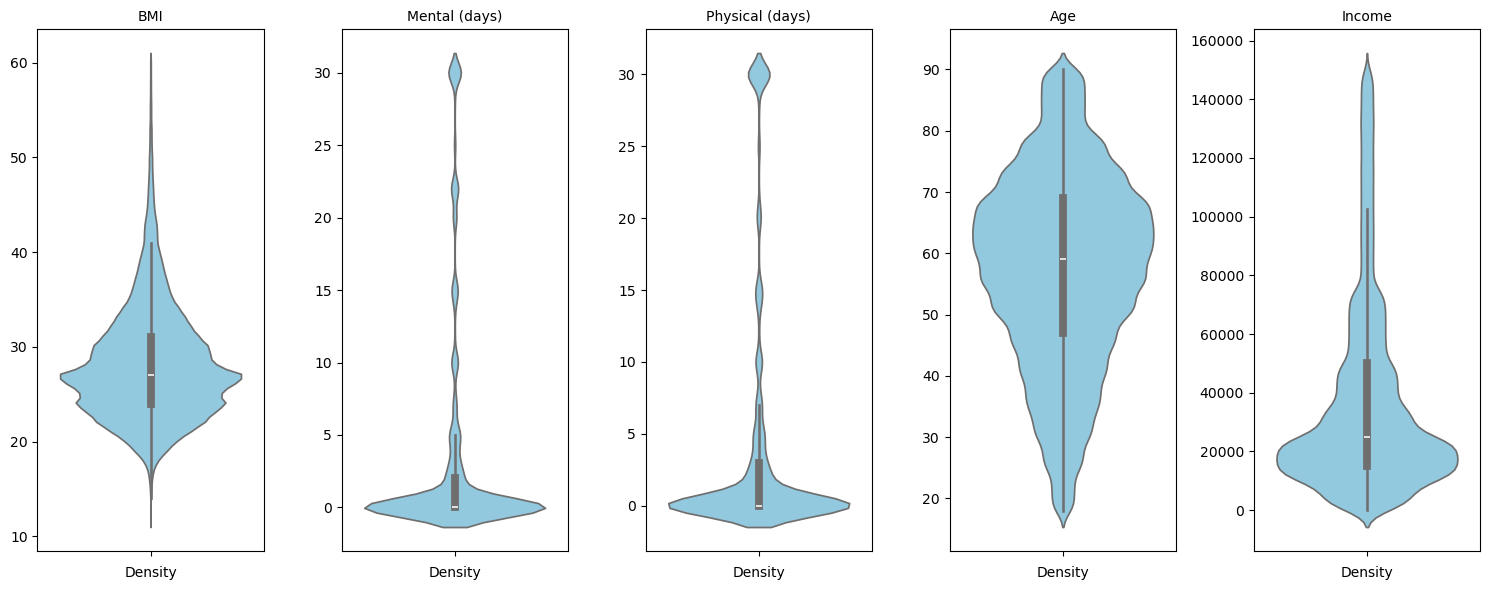


=== 分类特征分布（柱状图） ===
⚠️ 警告：以下分类列在 DataFrame 中不存在，将被跳过：['CholCheck', 'AnyHealthcare', 'NoDocbcCost']


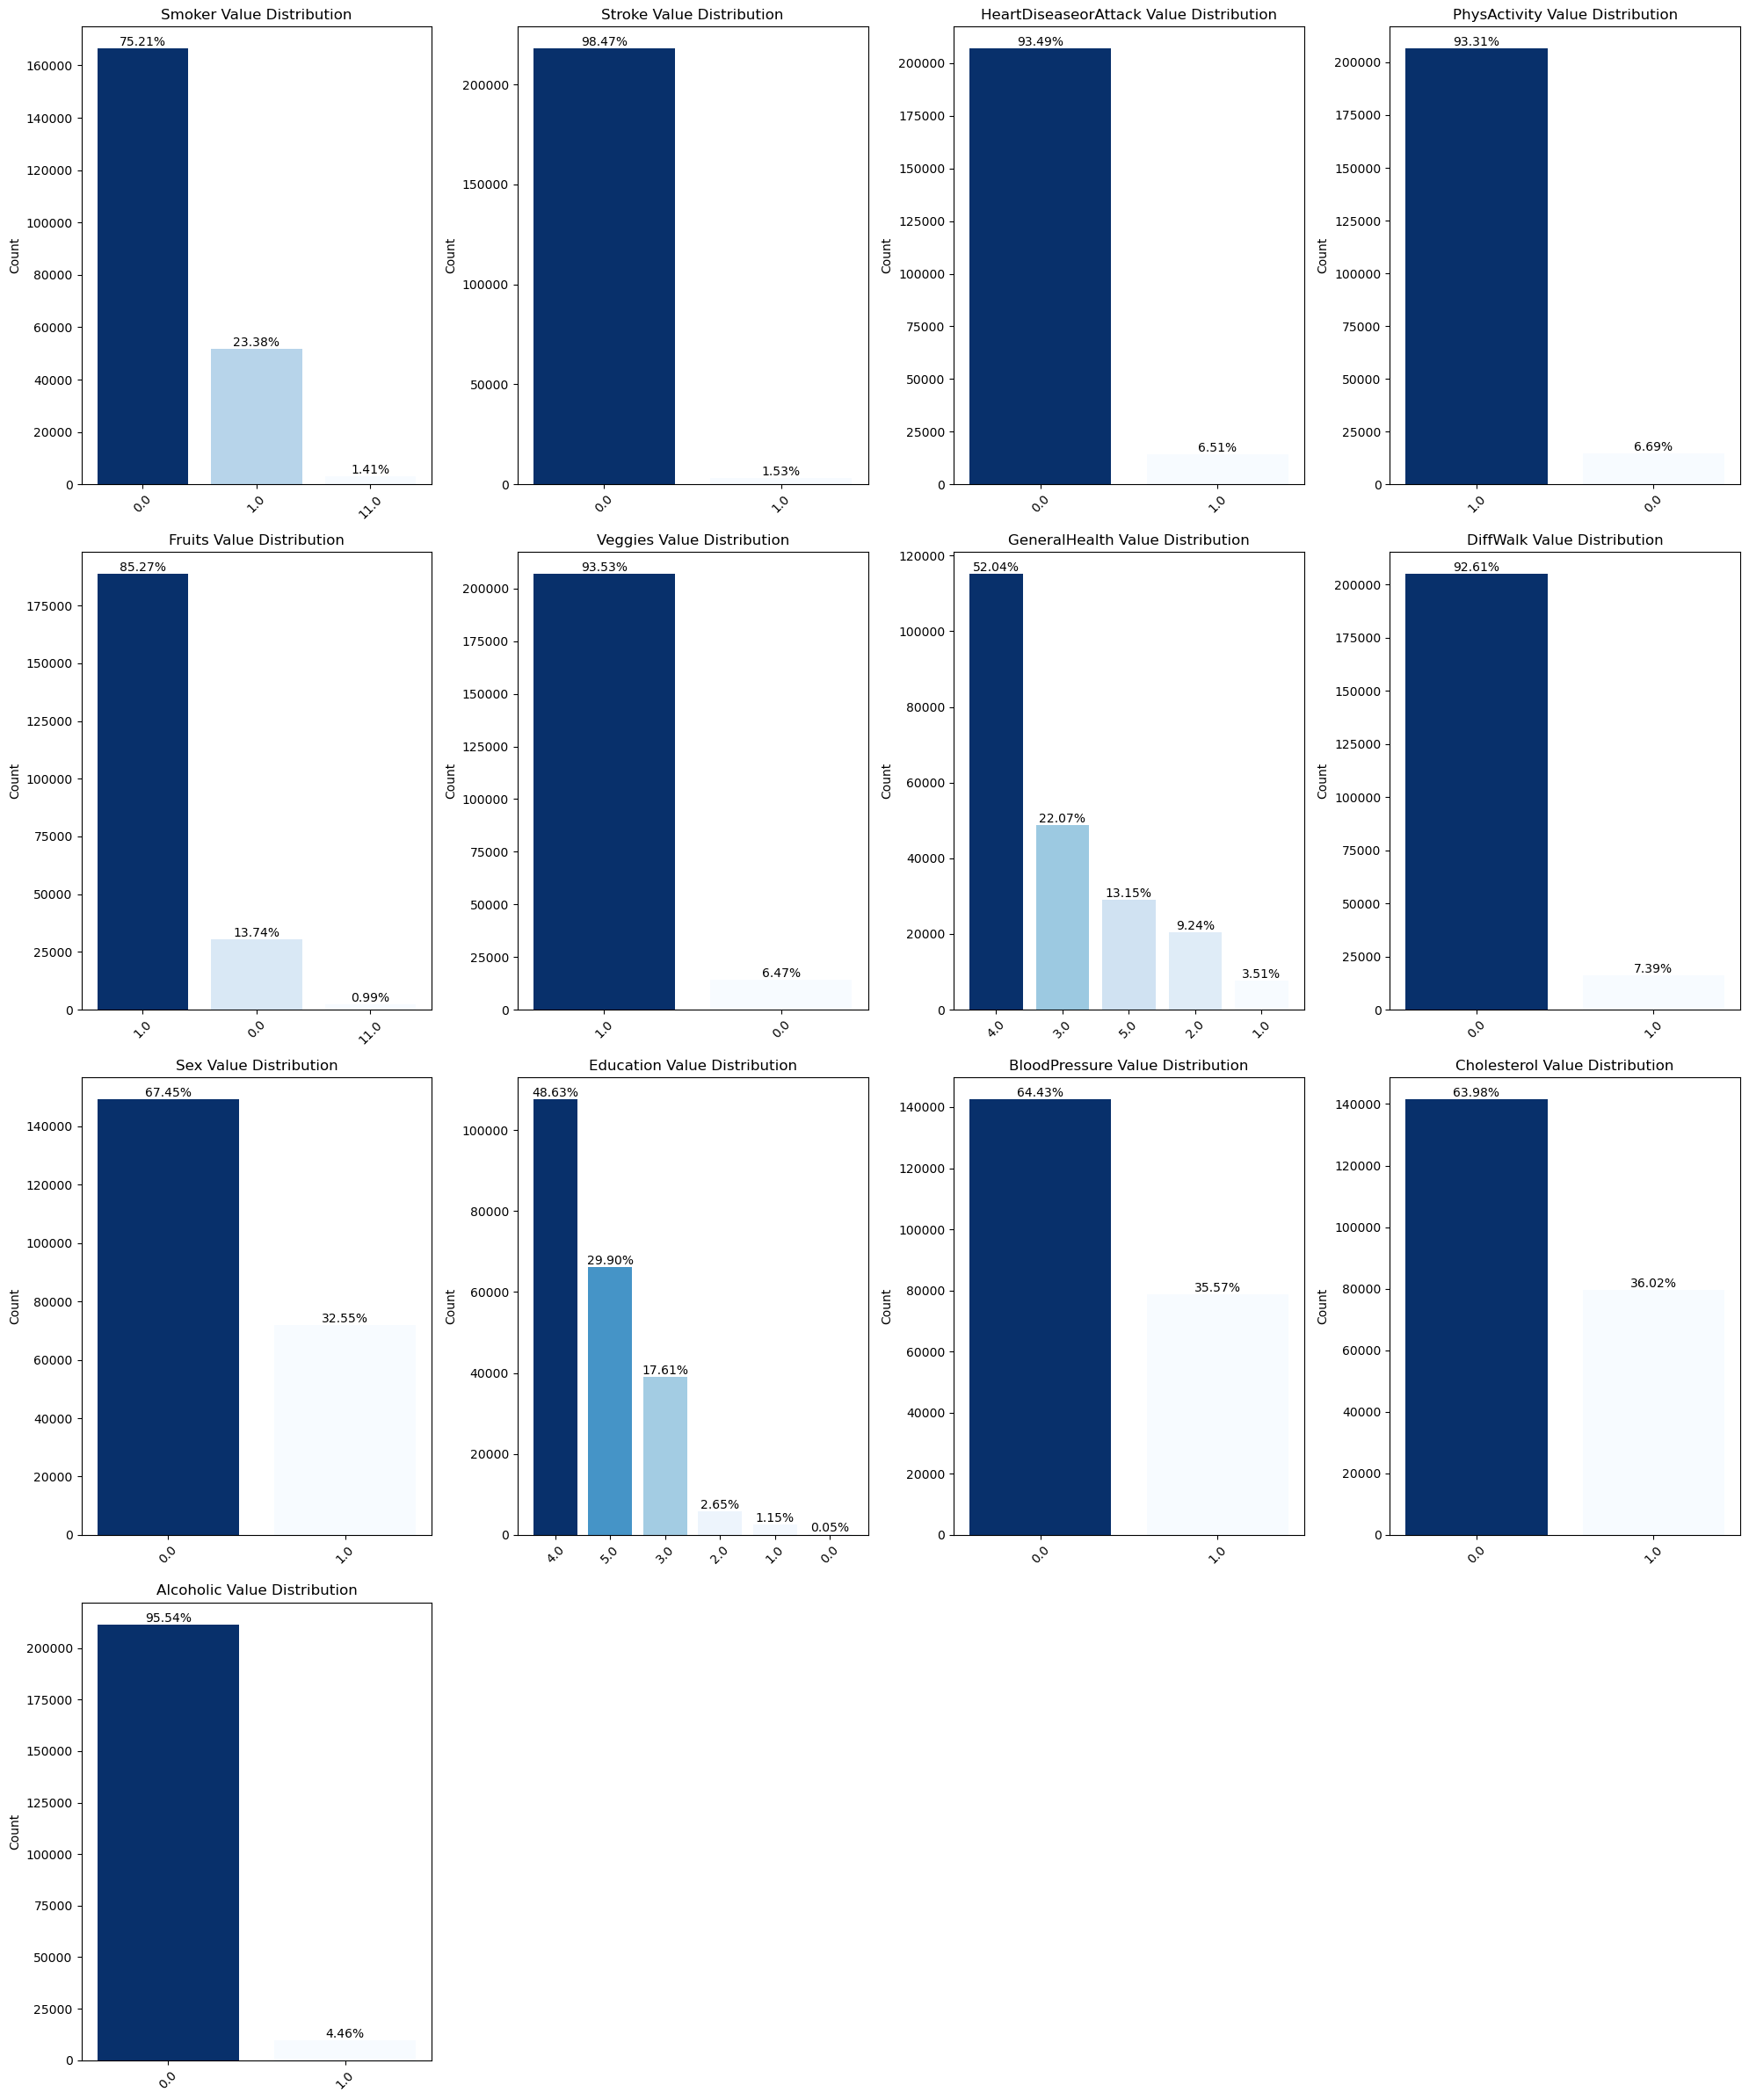

=== 缺失值信息（柱状图） ===


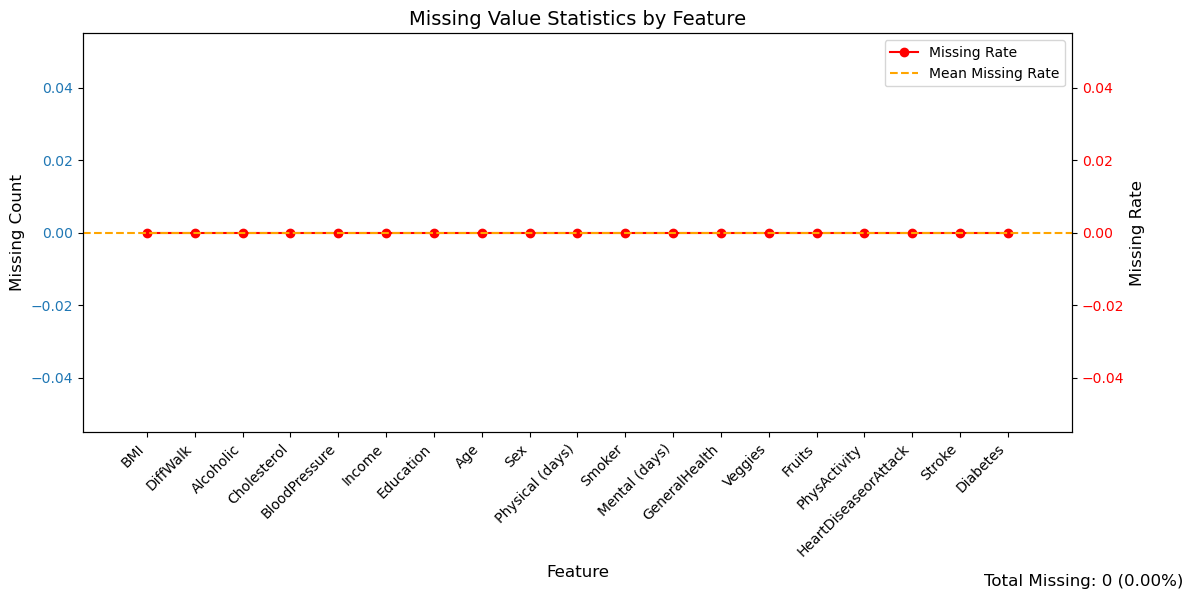

In [172]:
df,X,y = load_preprocess_plot('diabetes_diagnosis_complete.csv', numeric_features, categorical_features,do_plot=True)

#### 3.4.2 降维

数据维度与特征数量
- 数据集维度: **(221,372, 19)**  
- 特征数量适中（19 个特征），远低于样本数量 (n_features << n_samples)，无需强制降维。
- 特征冗余有限，主要集中在少数特征。  
- 多数特征信息独立，降维可能丢失有价值信息。

**综合判断**：
> 当前数据集不需要额外进行降维处理。  
> 建议在模型训练阶段直接使用原始或经过轻微编码/二元化的特征即可，同时监控 GeneralHealth 与 DiffWalk 的共线性情况。

# 四、探索性数据分析

=== 数据集基本信息 ===
维度: (221372, 19)
=== 连续特征分布（小提琴图） ===


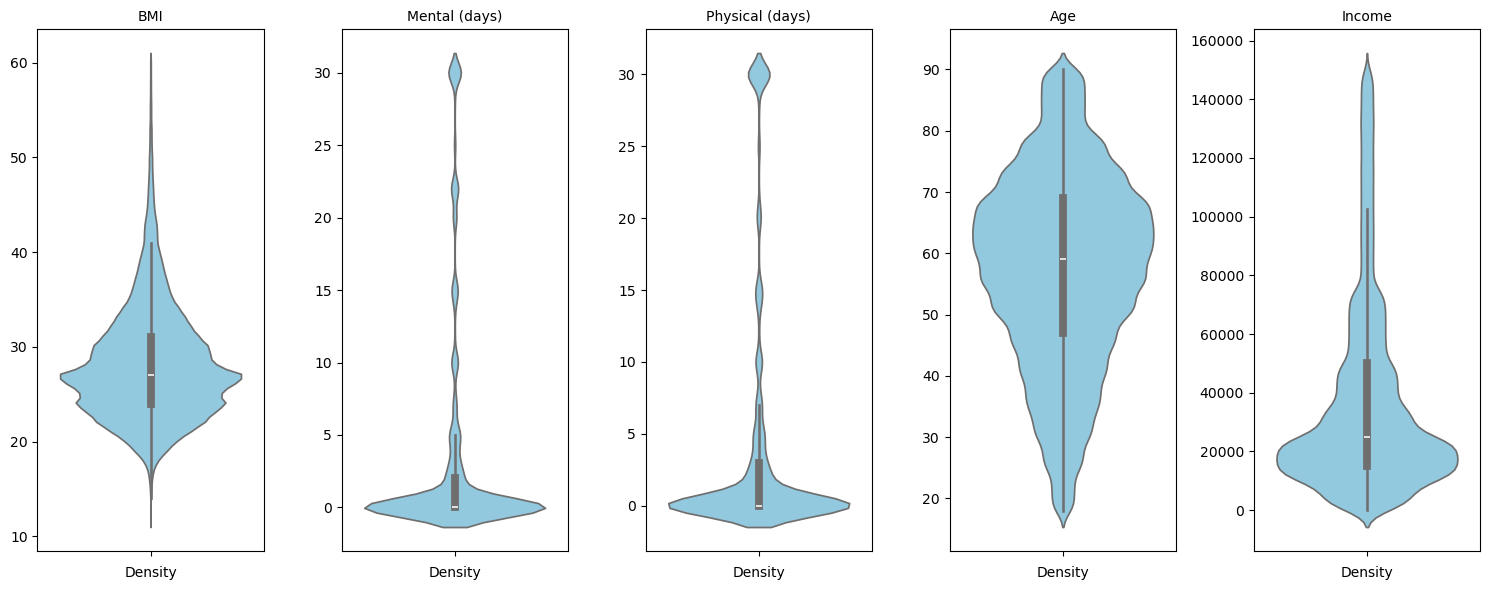


=== 分类特征分布（柱状图） ===
⚠️ 警告：以下分类列在 DataFrame 中不存在，将被跳过：['CholCheck', 'AnyHealthcare', 'NoDocbcCost']


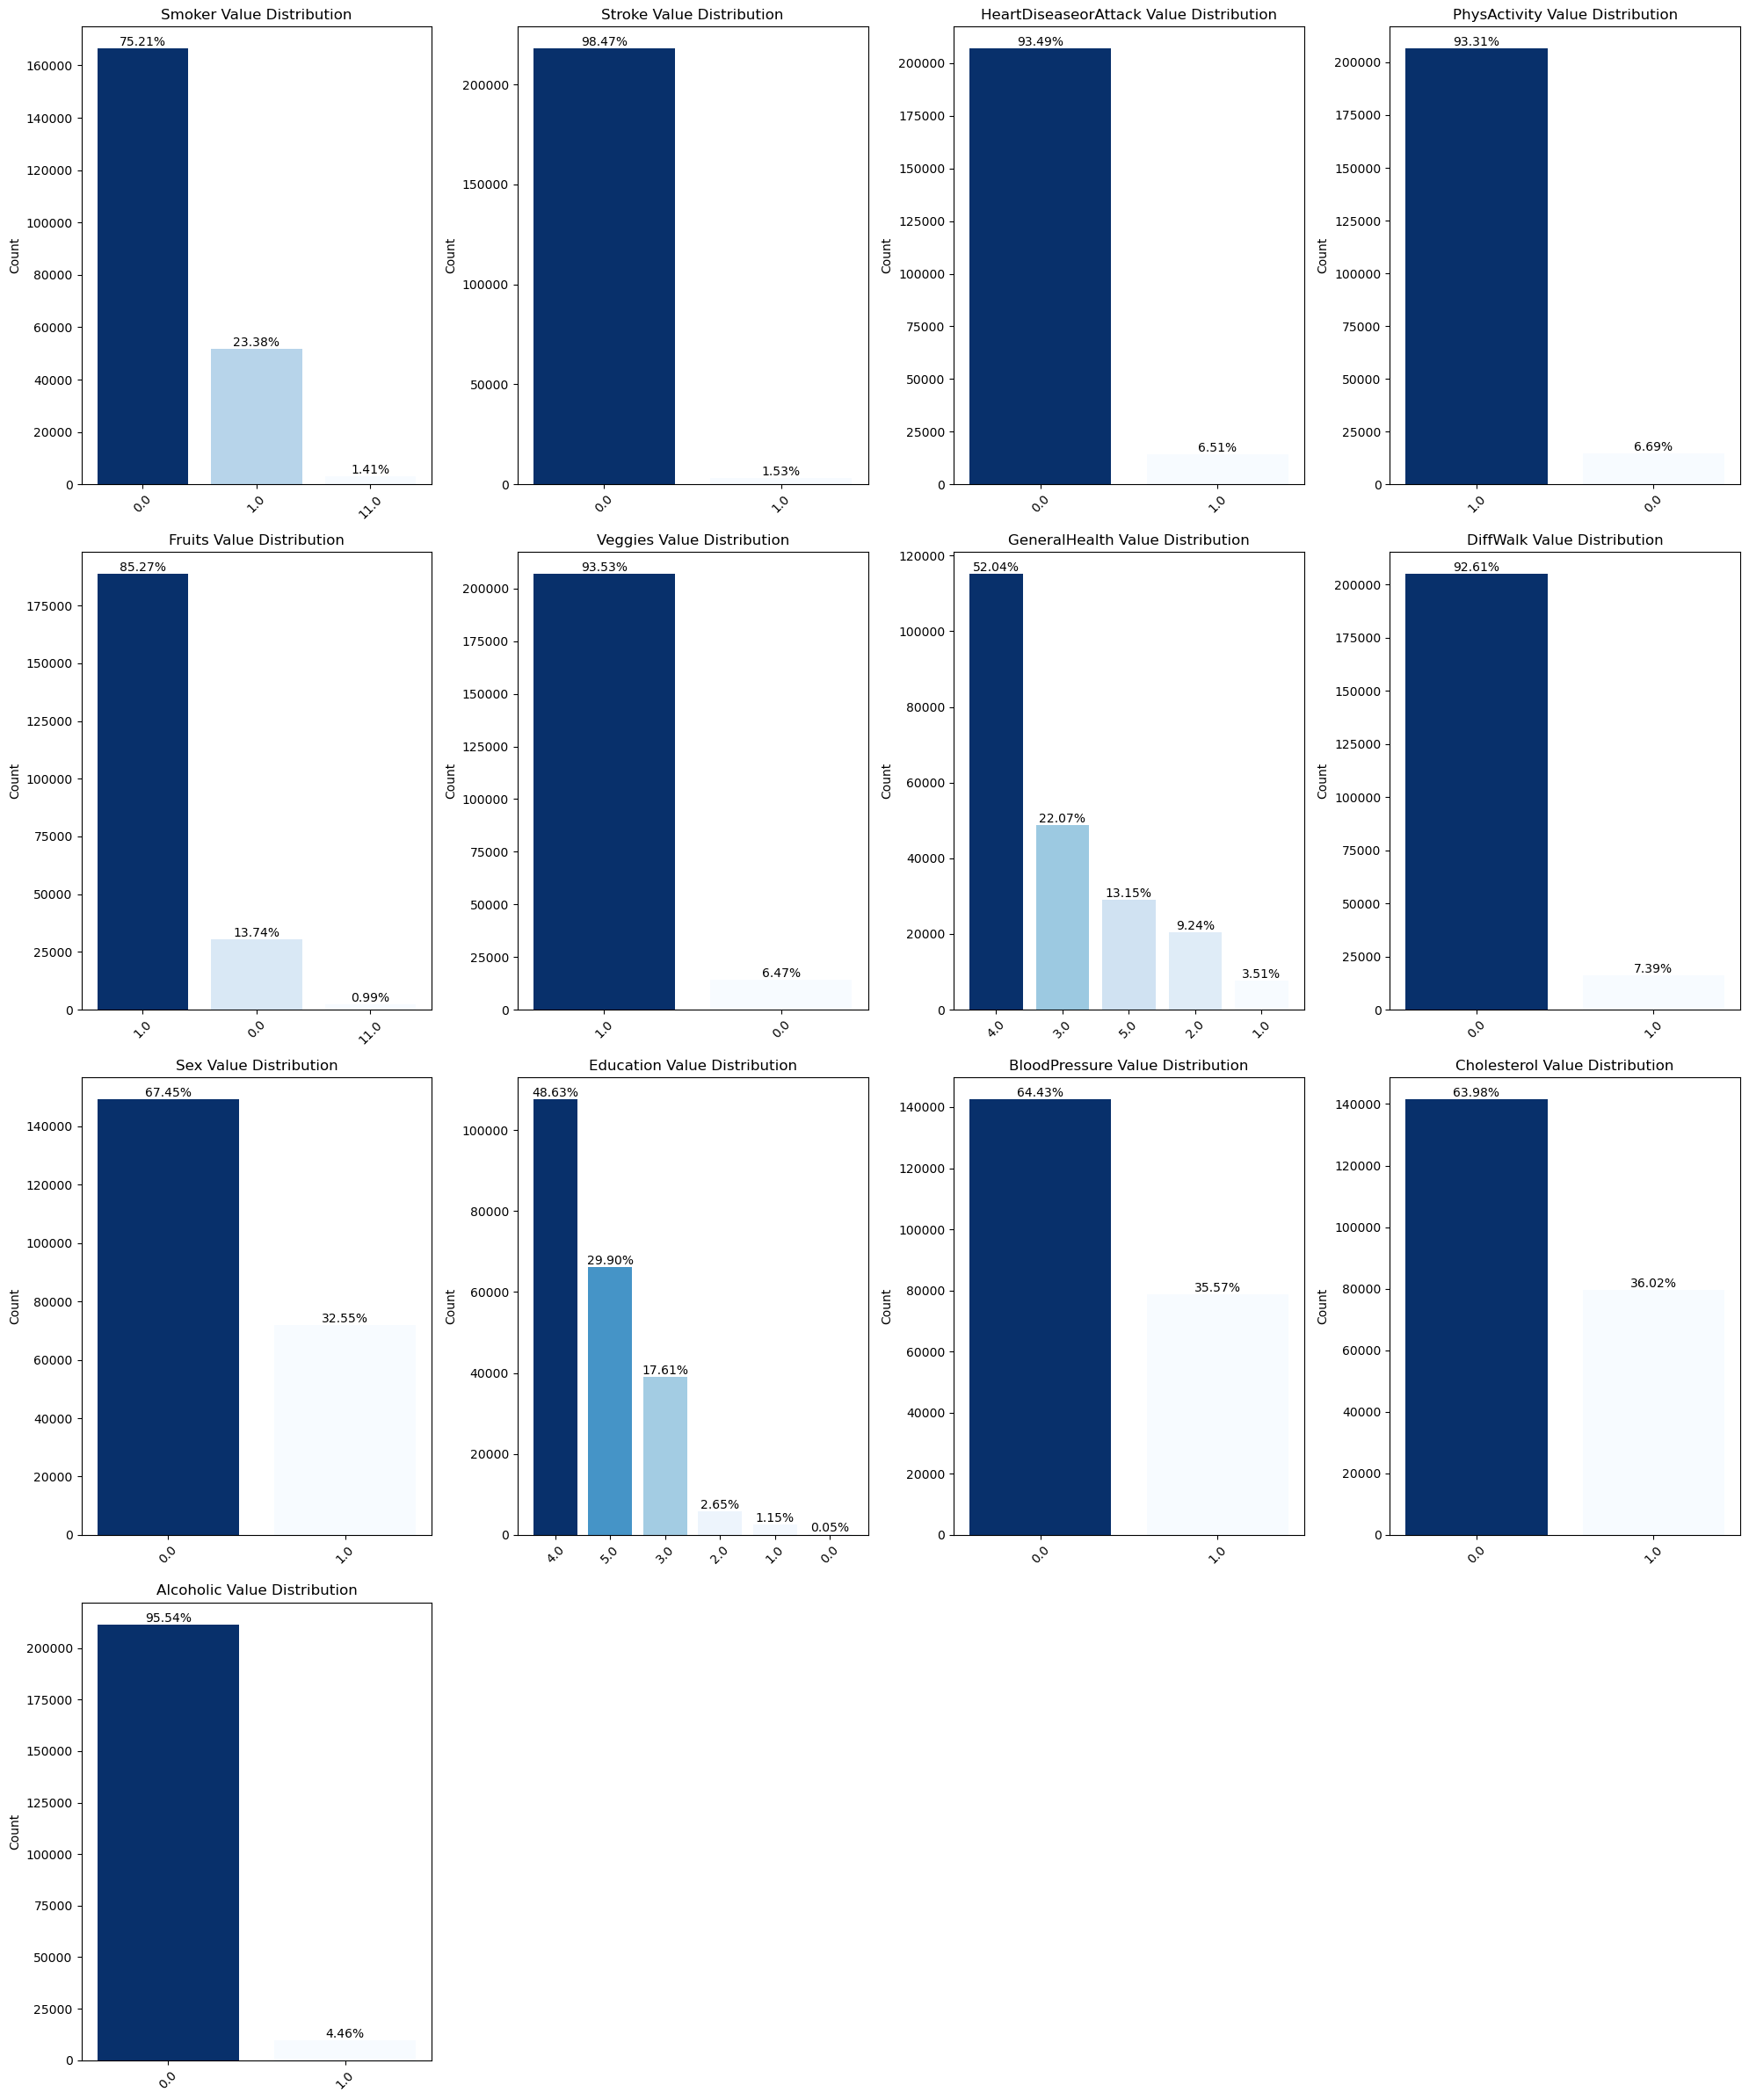

=== 缺失值信息（柱状图） ===


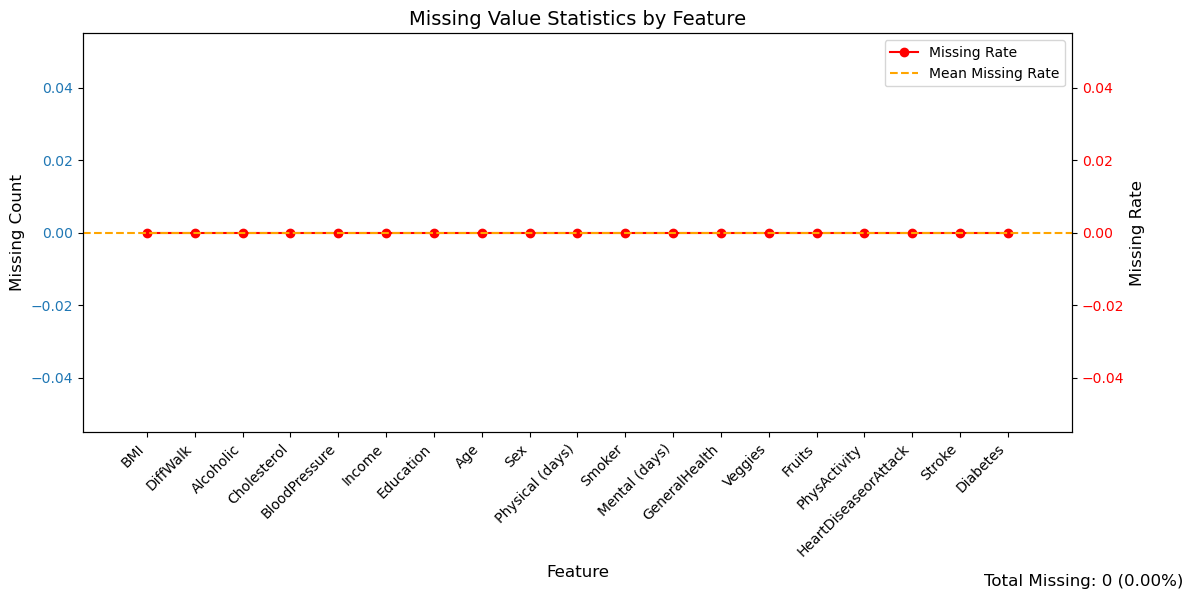

In [203]:
df, X, y = load_preprocess_plot('diabetes_diagnosis_complete.csv', numeric_features, categorical_features, do_plot=True)

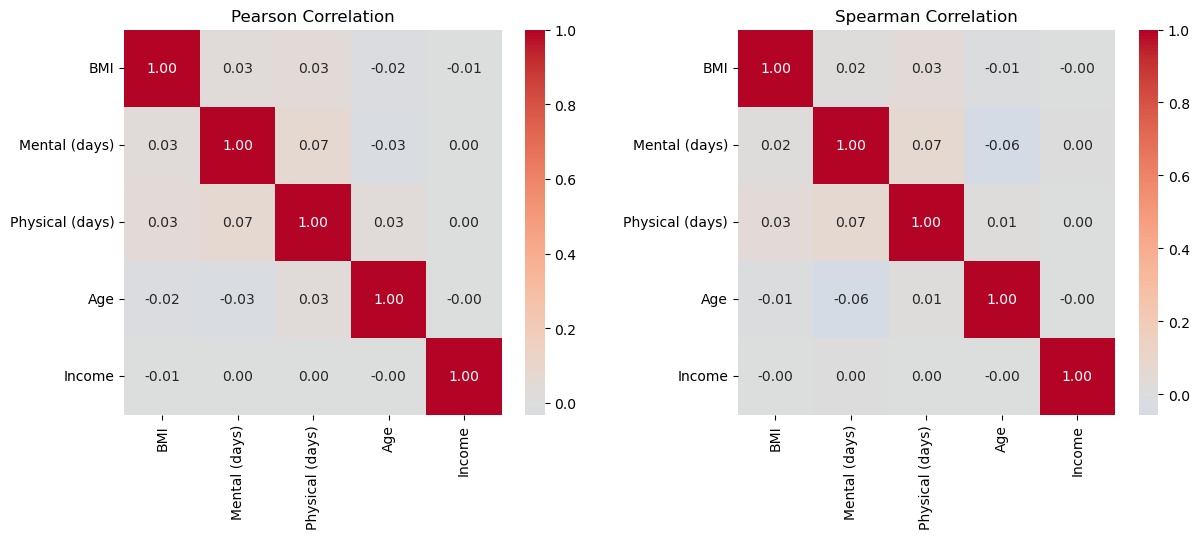

In [198]:
plot_numeric_correlations(df,numeric_features=numeric_features)

警告：以下特征在数据中不存在，将被忽略: ['CholCheck', 'AnyHealthcare', 'NoDocbcCost']


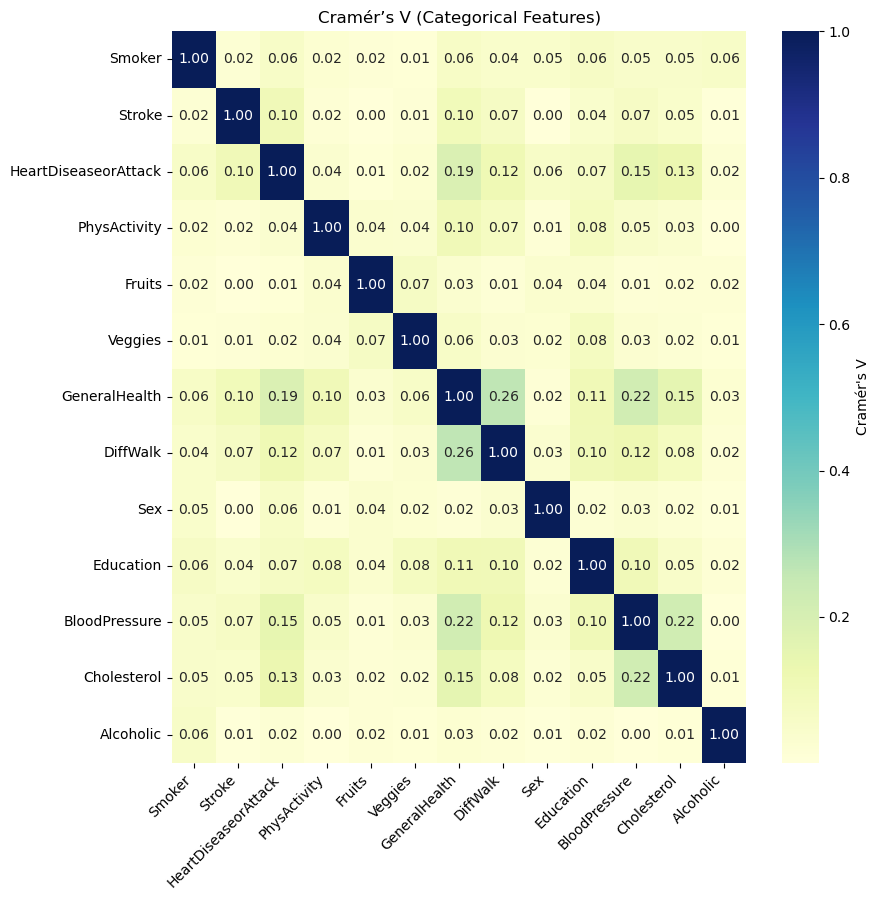

In [206]:
plot_cramers_v(df, categorical_features=categorical_features, per_feature_size=0.7)

In [213]:
def plot_scatter_matrix(df: pd.DataFrame, numeric_features: list, sample_size: int = 500):
    """
    绘制数值型特征的散点矩阵和对角线直方图。

    参数：
    ----
    df : pd.DataFrame
        输入的数据集
    numeric_features : list
        需要绘制散点矩阵的数值型特征列表
    sample_size : int, default=500
        为提高绘图效率，随机采样的数据行数上限

    返回：
    ----
    None，直接显示图形
    """
    sampled_X = df.sample(min(sample_size, len(df)), random_state=42).reset_index(drop=True)
    features = list(numeric_features)
    n = len(features)

    fig, axes = plt.subplots(n, n, figsize=(max(6, n*3), max(6, n*3)), squeeze=False)
    fig.suptitle("Scatter Matrix of Continuous Features", y=1.02)

    for i, yvar in enumerate(features):
        for j, xvar in enumerate(features):
            ax = axes[i, j]
            if i == j:
                sns.histplot(sampled_X[xvar].dropna(), bins='auto', edgecolor="black", ax=ax)
            else:
                sns.regplot(
                    data=sampled_X, x=xvar, y=yvar, ax=ax,
                    order=3,
                    line_kws={"lw": 2, "alpha": 0.8},
                    scatter_kws={"s": 8, "alpha": 0.4, "edgecolor": "k", "linewidths": 0.3}
                )

            if j > 0:
                ax.set_ylabel("")
            if i < n - 1:
                ax.set_xlabel("")

    plt.tight_layout()
    plt.show()

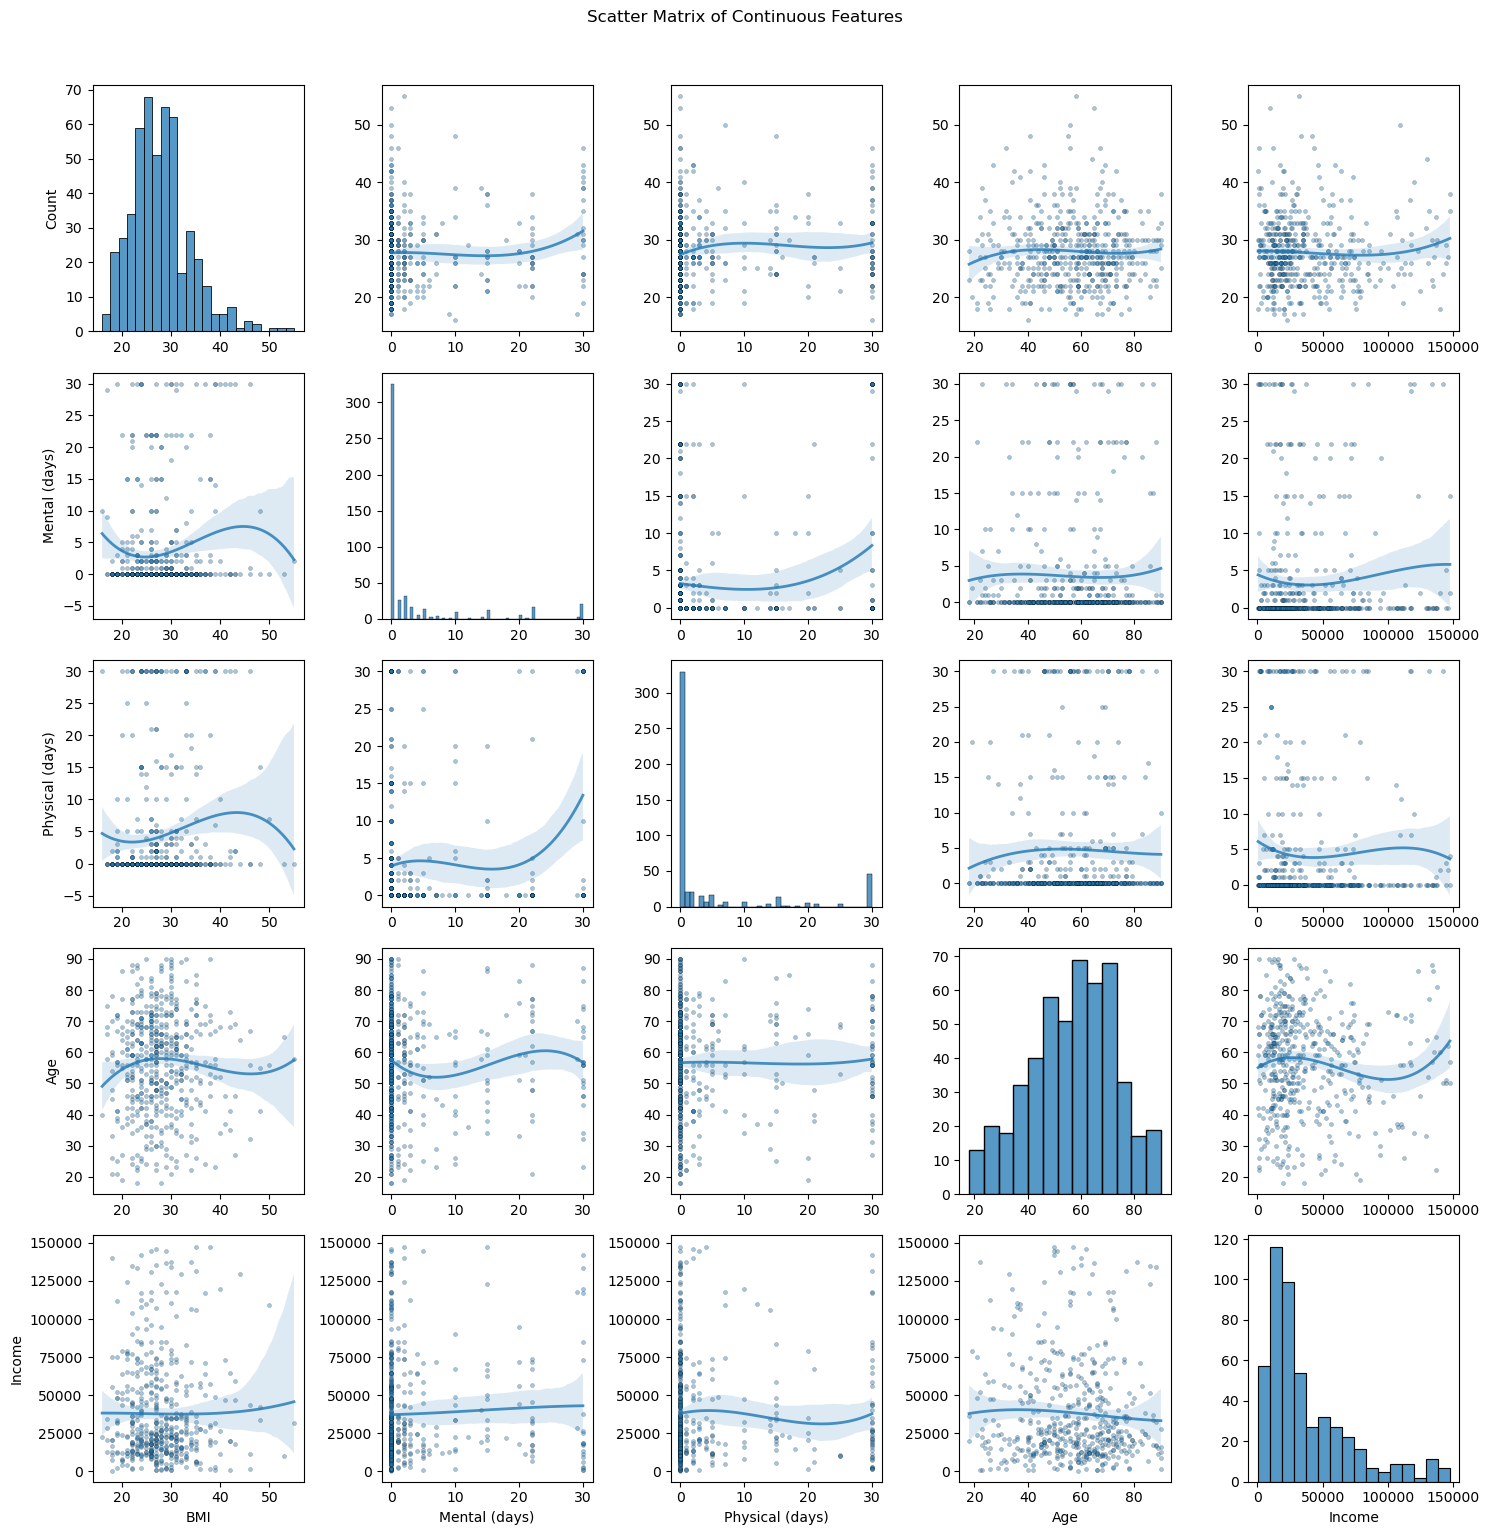

In [214]:
plot_scatter_matrix(df, numeric_features=numeric_features)